$HI$  
       Here I am Testing BackTrader Module

In [2]:
import pandas as pd 
import numpy as np
import tkinter
import matplotlib.pyplot as plt
# matplotlib.use("tkagg")
from backtesting.lib import crossover
%matplotlib inline

/home/nimac/.local/lib/python3.6/site-packages/backtesting/_plotting.py:37: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `bokeh.io.reset_output()`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
from models.data_provider import DataModel
dm = DataModel()
dm.read_from_csvs("../xcels",["master0.csv","master1.csv"])

In [4]:
df = dm.get(dm.TA_SYMBOLS[0],"1390-01-01")

2020-02-11 12:11:10.401 | DEBUG    | models.data_provider:get:172 - symbol is not scaled: خپارس
2020-02-11 12:11:10.472 | DEBUG    | models.data_provider:adjust_and_log:57 - start adjust and log for خپارس
2020-02-11 12:11:10.474 | DEBUG    | models.data_provider:adjust_and_log:58 - calculating scale
2020-02-11 12:11:10.538 | DEBUG    | models.data_provider:adjust_and_log:60 - adding adjust
2020-02-11 12:11:10.541 | DEBUG    | models.data_provider:add_adjust:28 - new part len is 3459, shape: (3459,)
2020-02-11 12:11:10.577 | DEBUG    | models.data_provider:add_adjust:38 - found adj date: 2009-06-08 00:00:00
2020-02-11 12:11:10.591 | DEBUG    | models.data_provider:add_adjust:38 - found adj date: 2010-07-05 00:00:00
2020-02-11 12:11:10.600 | DEBUG    | models.data_provider:add_adjust:38 - found adj date: 2011-07-05 00:00:00
2020-02-11 12:11:10.610 | DEBUG    | models.data_provider:add_adjust:38 - found adj date: 2012-06-23 00:00:00
2020-02-11 12:11:10.620 | DEBUG    | models.data_provide

In [5]:
df.columns = ['symbol', 'name', 'amount', 'volume', 'value', 'lastday', 'open1',
       'close1', 'last-change', 'last-percent', 'ending', 'ending-change',
       'ending-percent', 'min', 'max', 'year', 'month', 'day', 'diff_min_max',
       'diff_open', 'low', 'high', 'close', 'open',
       'adj_ending', 'log_adj_open', 'log_adj_close', 'log_adj_ending',
       'log_adj_min', 'log_adj_max', 'adj_scale']

100

In [6]:
%%time
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

buys=[]
sells=[]
data_arr=[]
class MyStrategy(bt.Strategy):
    params = (('period', 20),)
    buy_avg_arr=[0]
    prices=[]
    counter=0
    sell_history=[]
    sell_days=[]
    last_trade_price=0
    buy_history=[]
    buy_days=[]
    buy_avg=0
    
    def __init__(self):
        self.sma=bt.talib.SMA(self.data.close, timeperiod=25, plotname='TA_SMA')
        
    def stock_inv(self,price):
        current_cash=cerebro.broker.get_cash()
        value=cerebro.broker.get_value()
        stock_inventory=((value-current_cash)/price)
        
        return stock_inventory
        
    def sell_func(self,price,day):
        amount=0
        diff=100*abs(price-MyStrategy.buy_avg)/MyStrategy.buy_avg
        stock_inventory=self.stock_inv(price)
        amount=((diff//30))*(stock_inventory/5)
        if(amount>stock_inventory):
            amount=stock_inventory
        if(amount!=0):
            self.sell(size=amount)
            MyStrategy.last_trade_price=price
            MyStrategy.sell_history.append([price,amount])
            MyStrategy.sell_days.append(day)
            stock_inventory=self.stock_inv(price)
  
    def buy_func(self,price,day):
        amount=0
        diff=100*abs(price-MyStrategy.buy_avg)/MyStrategy.buy_avg
        stock_inventory=self.stock_inv(price)
        if(price<MyStrategy.buy_avg):
            amount=((diff//30)+1)*int((cerebro.broker.cash/5)/price)
        else:
            amount=int((cerebro.broker.cash/10)/price)
        self.buy(size=amount)
        MyStrategy.last_trade_price=price
        MyStrategy.buy_history.append([price,amount])
        MyStrategy.buy_days.append(day)
        MyStrategy.buy_avg=np.average([MyStrategy.buy_avg,price],weights=[stock_inventory,amount])
        MyStrategy.buy_avg_arr.append(MyStrategy.buy_avg)
        stock_inventory=self.stock_inv(price)
        
    def next(self):
        MyStrategy.counter+=1
        last_close=self.data.close[0]
        MyStrategy.prices.append(last_close)
#         amount=int((beggining_cash/5)/last_close)
        amount=int((cerebro.broker.get_cash()/20)/last_close)


        current_cash=cerebro.broker.get_cash()
        value=cerebro.broker.get_value()
        stock_inventory=((value-current_cash)/last_close)
        
        data_arr.append(self.data.close[0])

        # if it was the first day
        if(len(MyStrategy.buy_history)==0):
            self.buy(size=amount)
            MyStrategy.last_trade_price=last_close
            MyStrategy.buy_history.append([last_close,amount])
            MyStrategy.buy_days.append(1)
            MyStrategy.buy_avg=last_close
        
                                    
        else:
            if(last_close>MyStrategy.buy_avg):
                if(last_close<MyStrategy.last_trade_price*0.95):
                    self.buy_func(last_close,MyStrategy.counter)
                if(last_close>self.last_trade_price*1.05):
                    self.sell_func(last_close,MyStrategy.counter)
                    
                    
            
            elif(last_close<MyStrategy.buy_avg):
                if(last_close<MyStrategy.last_trade_price*0.95):
                    self.buy_func(price=last_close,day=MyStrategy.counter)
                
                
                
#     

# Create a cerebro entity
cerebro = bt.Cerebro()
cerebro.broker.setcommission(commission=0.015)
data = bt.feeds.PandasData(dataname=df)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our cash start
beggining_cash=10000000
cerebro.broker.setcash(beggining_cash)

# Add a strategy
cerebro.addstrategy(MyStrategy)
# Run over everything
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
x=cerebro.broker.cash
cerebro.run()
y=cerebro.broker.getvalue()
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print("final_cash=", cerebro.broker.get_cash())
z=cerebro.broker.get_cash()
MyStrategy.counter

Starting Portfolio Value: 10000000.00
Final Portfolio Value: 55245975.38
final_cash= 29214366.506289005
CPU times: user 924 ms, sys: 0 ns, total: 924 ms
Wall time: 975 ms


1847

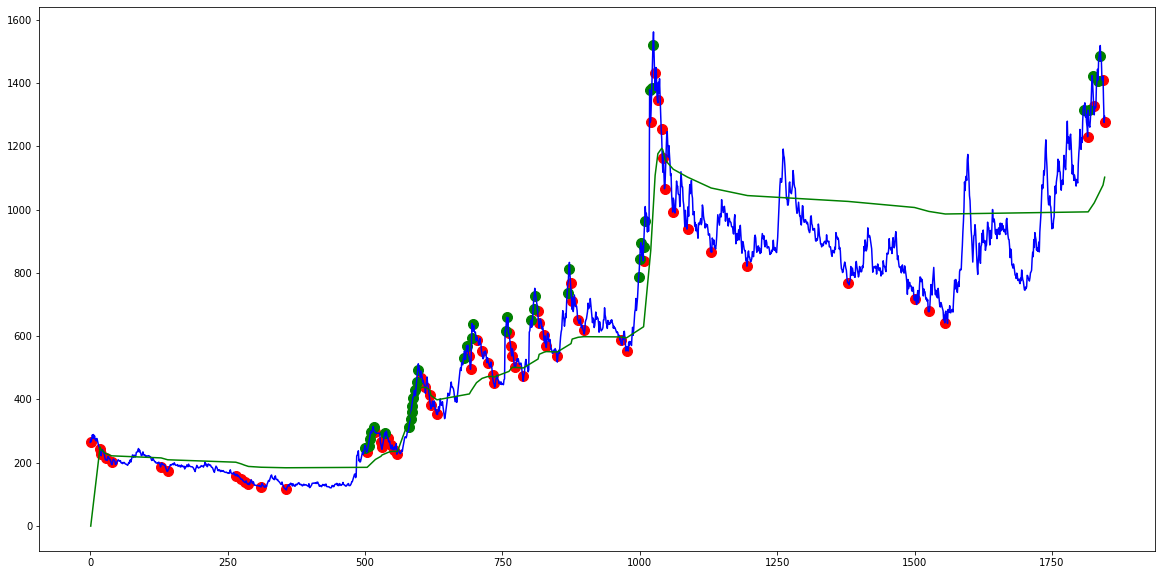

68


In [70]:
x=[row[0] for row in MyStrategy.buy_history]
y=[row[0] for row in MyStrategy.sell_history]

plt.figure(figsize=(20,10))
plt.scatter(MyStrategy.buy_days,x,c='r',s=100)
plt.scatter(MyStrategy.sell_days,y,c='g',s=100)
plt.plot(np.arange(len(MyStrategy.prices)),MyStrategy.prices,c='b')
plt.plot(MyStrategy.buy_days,MyStrategy.buy_avg_arr,c='g')
plt.show()data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABIoAAAI/CAYAAAAYxjIJAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzdeXxcdb3/8fc3yWQyWZsudN8IZREIiwVBLohwBaIsVw1XvZaLCrdixaVW/Lnc63Iv7tSyVEQsXKRVUAoqCrWgXASt0LIZtkobWuxe2rRpkklmJjPn98d3TubMZGYySZPMJHk9H488zpnvnDnzbdrOzHnP5/v9GsdxBAAAAAAAABTluwMAAAAAAAAoDARFAAAAAAAAkERQBAAAAAAAgDiCIgAAAAAAAEgiKAIAAAAAAEAcQREAAAAAAAAkSSX57kA2EydOdObMmZPvbgAAAAAAAIwazz777D7HcSalu6+gg6I5c+bomWeeyXc3AAAAAAAARg1jzBuZ7mPoGQAAAAAAACQRFAEAAAAAACCOoAgAAAAAAACSCIoAAAAAAAAQR1AEAAAAAAAASQRFAAAAAAAAiCMoAgAAAAAAgKQcgiJjzJ3GmL3GmJdS2j9ljNlojHnZGPM9T/uXjDGbjTF/N8Zc6Gm/KN622RjzxcH9YwAAAAAAAOBwleRwzF2Slku6220wxrxT0mWSTnIcJ2SMOSLe/hZJH5R0vKRpkv5gjDk6/rAfSnqXpO2SNhhjHnQc55XB+oMAAAAAAADg8PQZFDmO84QxZk5K8yckfcdxnFD8mL3x9ssk3Rtv32KM2Szp9Ph9mx3HeV2SjDH3xo8lKAIAAAAAACgQA52j6GhJZxtjnjbG/MkYc1q8fbqkbZ7jtsfbMrUDAAAAAACgQOQy9CzT48ZLOkPSaZJ+aYw5cjA6ZIxZKGmhJM2aNWswTgkAAAAAAIAcDLSiaLukBxxrvaSYpImSdkia6TluRrwtU3svjuPc7jjOfMdx5k+aNGmA3QMAAAAAAEB/DTQo+rWkd0pSfLLqUkn7JD0o6YPGGL8xZq6keZLWS9ogaZ4xZq4xplR2wusHD7fzAAAAAAAAGDx9Dj0zxtwj6VxJE40x2yV9TdKdku40xrwkKSzpSsdxHEkvG2N+KTtJdbekTzqOE42f51pJayUVS7rTcZyXh+DPAwAAAAAAgAEyNt8pTPPnz3eeeeaZfHcDAAAAAABg1DDGPOs4zvx09w106BkAAAAAAABGGYIiAAAAAAAASCIoAgAAAAAAQBxBEQAAAAAAACQRFAEAAAAAACCOoAgAAAAAAACSCIoAAADQh23bpDPOkPbuzXdPAADAUCMoAgAAQFbLlklPPy2tXJnvngAAgKFGUAQAAICsurvttqQkv/0AAABDj6AIAAAAWUUidktQBADA6EdQBAAAgKyoKAIAYOwgKAIAAEBWBEUAAIwdBEUAAADIyg2KivjkCADAqMfbPQAAALJyg6JQKL/9AAAAQ4+gCAAAAFkRFAEAMHYQFAEAACCt5pZmLXpokX798u8kSV/4/X9p0UOL1NzSnOeeAQCAoUJQBAAAgF7WbFqj+tvqteK5FT0VReGQoxXPrVD9bfVas2lNfjsIAACGBEERAAAAkjS3NKvxvkYFI0FFYhEpWmrviPoViUUUjATVeF8jlUUAAIxCBEUAAABIsvSvSxWJRhINkQq77fYnmqIRLXtq2TD3DAAADDWCIgAAACRZ1bTKVhK5wvGgKOoJimIRrWxaOcw9AwBgeEQi0q5d+e5FfhAUAQAAIEl7uD25obssvvVnPw4AgFHi6quladNsYDTWEBQBAAAgSWVpZXKDZ46irMcBADBK3H233QaD+e1HPhAUAQAAIMmC+gXyFfkSDW5A5AZGknxFPl1Rf8Uw9wwAgOHV2ZnvHgw/giIAAAAkWXLmEvmKvUFRPCDyDD3zFfu0+IzFw9wzAACGFxVFAAAAGPPqxtdp9eWrVe4rt5VFbkAU9ctX5FO5r1yrL1+tuvF1+e0oAABDIBZL7FNRBAAAAEhqmNegpmuatPCtC3uGnhXHKrTwrQvVdE2TGuY15LmHAAAMjZaWxD5BEQAAABBXN75OtzQs7wmKzpp2npa/ezmVRACAUau5pVnX3vffPbfPuf0iLXpokZpbmvPYq+FFUAQAAICMvMsCh8P56wcAAENtzaY1qr+tXqs3PNHT1tnpaMVzK1R/W73WbFqTx94NH4IiAAAAZOQNh0Kh/PUDAICh1NzSrMb7GhWMBBVtm5C4IxJQJBZRMBJU432NY6KyiKAIAAAAGXnDIYIiAMBotfSvSxWJxstoO45I3NEd6NmNRCNa9tSyYe7Z8CMoAgAAQEZUFAEAxoJVTasUiaUJiiLlid1YRCubVg5zz4YfQREAAAAyoqIIADAWtIfbEzcOzZCK4t+URAKZjxulCIoAAACQkRsOVVURFAEARq/K0srEjX3HSlNesPvdgczHjVIERQAAAMjIHXpWXc2qZwCA0WtB/QL5inySIxsUTX3e3uEZeuYr8umK+ivy08FhRFAEAACAjKgoAgCMBUvOXCJfsU/qmCR11UqTXpaKIlI4UUHkK/Zp8RmL89jL4UFQBAAAgIy8FUWhkOQ4+e0PAABDoW58nVZfvlpl0am2oXy/VNQtrbtOJeEJKveVa/Xlq1U3vi6/HR0GBEUAAADIyFtR5DhSd3d++wMAwFBpmNeg+9/3O0lSoKxYesv9kqQPzPm0mq5pUsO8hnx2b9iU5LsDAAAAKFxuRVFVld2GQpLPl7/+AAAwlI4omylJuvcDdyvyPqmxUfrC276quvF57tgwIigCAABARm5FUXW13TKhNQBgNHPf9/x+qbg4uW2sICgCAABARt6hZ97bAACMRt6gqCSemHR15a8/+UBQBAAAgIy8k1lLBEUAgNHNGxTFYnZ/rAVFTGYNAACAjFIrirZtk1pa8tcfAACGkjco8vvt/lgLiqgoAgAAQEapk1mfc46ds4HVzwAAo5E3KHIcuz/WgiIqigAAAJBRz2TWv/ppT1s0KjmfWCQ1N+epVwAADL5YTLrjDrvv90tlZXafoAgAAACICzdtlCRV/el3Se3dK+6S6uulNWvy0CsAAAbfz34mPfqo3fcGRWNtfj6CIgAAAKTX3KzQyl9IkqqjyRMThbuNFAxKjY1UFgEARoU330zsU1EEAAAApFq6VKGoT0YxVagj6a6Q4jN8RiLSsmV56BwAAAPT3NKsRQ8tUvW3q1X0jSJVf7taix5apP2d+3qOGcuTWRMUAQAAIL1VqxSOFatUYfmVXHcfVqndiUSklSvz0DkAAPpvzaY1qr+tXiueW6G2cJscOWoLt2nFcyv0/b9+t+e4sVxRxKpnAAAASK+9XSH55Vcoc1AUPw4AgELX3NKsxvsaFYwEe90XiUWkaLjndmmpZIxUVDT2giIqigAAAJBeZaXCKlWpwipT8qfkpKCosnKYOwYAQP8t/etSRaIRe6PbJ3WXJh/QXdazW1Rkg6KyMiazBgAAAKwFCxQyAfkVUkCdSXf1BEU+n3TFFXnoHAAA/bOqaZWtHJKk5X+XvpVSERtO+eKjuVll0Xbtu3GV2k2VVF0tLVo06hdxICgCAABAekuWKFxUJr9CmSuKfD5p8eI8dA4AgP5pD3uCoYNzpZgv+QBPUFT9P+Va9Llj5Iu06q7uBZqgfVJbm7RihVRfL61ZM0y9Hn4ERQAAAEivrk6hM89VqYmorCSadFe4uFwqL5dWr5bq6vLUQQAAcldZ2sdQ6XBFz25brFMrTopqb7Uddxb2rvYZDEqNjaO2soigCAAAABmFxk+V/9i58i+8Mqk9fGmjnr9no8y7G/SnP+WpcwAA9MOC+gXyFaVUEUUS8xKlDj2LFEuOcdKfLBKRli0b5B4Whj6DImPMncaYvcaYl9Lct8QY4xhjJsZvG2PMzcaYzcaYJmPMqZ5jrzTGbIr/XJl6LgAAABSecFgqrfSr6Ie3JLWHPvk5/eHvMyVJv/tdPnoGAED/LDlziXzFKUFRxxGJ/dQ5iiSp/M30J4tEpJUrB69zBSSXiqK7JF2U2miMmSnpAkn/8DQ3SJoX/1ko6UfxY8dL+pqkt0k6XdLXjDG1h9NxAAAADL1QSPL7e7eHw1IsZveLqFEHAIwAdePrtPry1Sr3lScavUFRJD707IIlibZzv5H5hO3tme8bwfp8W3cc5wlJLWnuWibpC5K8dViXSbrbsZ6SNM4YM1XShZIedRynxXGcA5IeVZrwCQAAAIUlHJZKS3u3Hzwo3Xab3ScoAgCMFA3zGtR0TVOioX1yYj84QTr6t9Lbf5Bom/d76cRVUs0bvU9W2cecRyPUgN7WjTGXSdrhOM7fUu6aLmmb5/b2eFumdgAAABSwTBVFX/iCtHWr3TdmWLsEAMBhqRufWIShLDrF7jiSWo6Sxm/u/QBfp0w0ZciazyddccXQdTKP+h0UGWPKJX1Z0lcHvzuSMWahMeYZY8wzb76ZYSwgAAAAhlRzS7MWPbRIz21/UWu2/ErV365Oun/37sQ+QREAYCRxPOOiTp90np3gum2qFKmUxm/qdXxRUVj+UEp5rc8nLV48xD3Nj4FUFNVJmivpb8aYrZJmSHrOGDNF0g5JMz3Hzoi3ZWrvxXGc2x3Hme84zvxJkyYNoHsAAAA4HGs2rVH9bfVa8dwKxSI+qTistnBbxuMZegYAGEnC4cT+WVMusBNct8yzDRPSBEUmopJIvKLI55PKy6XVq6W6ul7Hjgb9flt3HOdFx3GOcBxnjuM4c2SHkZ3qOM5uSQ9K+vf46mdnSGp1HGeXpLWSLjDG1MYnsb4g3gYAAIAC8tiWx3TpvZcqGAkqEotIUb9UHEpzZOLrWCqKAAAjSWdnYr8sNlGrL1+t0q54bUvVzp77fKZE5U6JLtsaU7dKpepqaeFCqalJamgY5l4Pn5K+DjDG3CPpXEkTjTHbJX3NcZw7Mhz+sKR3S9osKSjpo5LkOE6LMeZ/JG2IH/ffjuOkmyAbAAAAebJm0xpdcs8lijrRRGO0VCoO9zo25sQkFUuyKwQDADBSeIOi9nY7wfW33nGqPn+vVBkoVdAUqbK0UlfUX6HFZyzWnZE6/fq7klpb89bn4dRnUOQ4zof6uH+OZ9+R9MkMx90p6c5+9g8AAADDoLmlWY33NSaHRJLU7ZdKelcUeYOirq5h6CAAAIPEGxR1dNhtbald/ezlTz+vWbOSjy8tlaJRKRYbG8Otx8AfEQAAAH1Z+telikTTlAZ1l0kl6ZKgxHgzgiIAwEiSWlEkJeYtSrfSpy8+PdFYqaAlKAIAAIBWNa2ycxJJUrBW+rojvfJeqTsglXT2fkAsUZhOUAQAGEm871tuUBSKF8+WlvY+nqAIAAAAY057uD1xY99xdvvnL0lOcaKiaMY6u02Zs6gzTY4EAEChylZRlC4octvCvafsG5UIigAAAKDK0srEDROfpyhcYbe++Cfqj75D+kpAKm1PeiwVRQCAkcQNivz+xBxF2YIiKooAAAAw5iyoXyBfUfyTcFG33Ybj4ZFbUVTcrRJ/tyZPKEt6LEERAGAkcYOiiROTh54ZI5WkWfKLiiIAAACMOUvOXCJfsRsUuRVFblBkP1EXm2KtXbBWUyaUJz2WoAgAMJK471veoCgctoGQMb2Pp6IIAAAAY07d+Dqtvny1yn3lKimOf0SM2KFnxaXdKveV67cf+q3Om3ueamrs3UcfLV10EXMUAQBGFvd9a9Kk5IqidMPOpEQ7QREAAADGlIZ5DWq6pkmXn/he2xC1awRfcMw/qemaJjXMa5Cam1XzRpMkyf9ak8r+8Ft1NW+Xmpvz1W0AAPrFGxR55yjy+9Mf71YUMfQMAAAAY07d+Dp97Z3/mdT2qbMWqm58nbRmjVRfr+p/vCRJ8iuksu52de0PSvX19n4AAAqcd46ijg4pFksMPUuHiiIAAADAIxCQrRhqbJSCQdU4ByTFgyJ1qUt+KRi091NZBAAocN6gyHHs7WxDz6goAgAAwJgWiyXfLiuTtHRpz1epNWqVJJUqrDJ1qVMBe2AkIi1bNow9BQCg/7q67KTVEybY2x0duQ09o6IIAAAAY5LjJN8OBCStWtUrKIqqWAF1qktl9sBIRFq5chh7CgBA/3V22i9BKuOLe7a35zb0jIoiAAAAjEmpQVFZmRLLwkiaql2SpF2aGh96VpY42HMcAACFqLPTfgniDYpyGXpGRREAAADGpLQVRe6naUlv1bOSpE06WmXqUkSlirofKz3HAQBQiDo7pTJftyr+d7kkqf2ksxRe+5j8O5rTzrXHZNYAAAAY09JWFC1Y0POV6rHamLhPXZJkq4p8PumKK4armwAAZHXRRdIPftC7vbN5pwJ731Dl71dLkjpUrnC0WKV7tqVdxdOtKAqFhrrHhYGgCAAAAEnSVhQtWdLzSblYMT2g9+o5naKA7NIxPUHR4sXD3FsAAHrr6JDWrrVvX0mam9X15w0KOEFVRg9KktpVqZD8KnVCaVfxdCe5Zo4iAAAAjElpK4rq6qTVq6Xycsnn03v1a52iFxIVRWW19v66uuHvMAAAKZ55xm6LUlOPpUvVGfMroE5VqEOSDYrCKpVf8ZKhlFU83aCIiiIAAACMSd6gqKhIKimJ32hokJqapIULpepqqahIZWVGktT5uz/a+wEAyKPmlmYtemiRzr/6Mdsw+W/68P0f1oL7F6j629UqOuJHenRGmbaP79S+GrsAwz5NVJfKVKp4yVDKKp5jLSgq6fsQAAAAjCXeoCgQkIzx3FlXJy1fbn8kld0n6V+lrsmzh7WPAACkWrNpjRrva1Q46Fd0862SpFhxUD9/6eeJg4wUjQW0e9xBnf++Q9IN0udkq4dO1guJ4zyreI61oIiKIgAAACTxBkVlZdmPDQTstqtr6PoDAEBfmlua1Xhfo4KRoLr3eb68iJT3PjgSkOPrVGdFMKm5Tp4VzzyreBIUAQAAYEyLxRL7bhCUiRskERQBAPJp6V+XKhKNr1+/f57dTnopQ1BUIZW2S56K2anaqa/om/ZGyiqeBEUAAAAY0/pTUeTe39k5dP0BAKAvq5pWKRKLB0UtR9nt5BcTQdHOU6Rn/sPuhyttUORxoz6rMncy65RVPEtK7Jx9YyUoYo4iAAAAJEmdoygbKooAAIWgPewJfjonSL52qfzNRFB0+3N2O/8naYOiWh2wAZHPl3YVT79/7ARFVBQBAAAgCXMUAQBGmsrSxJxCCldK/jbJF+w99CxWlBh65lFbEbGrejY1pV3FcywFRVQUAQAAIMlAKooYegYAyKcF9Qu04rkVdviZWzHkC0pRvxQtThzYWWu3qUHR3x6XkouIkoyloIiKIgAAACQZyBxFVBQBAPJpyZlL5Cv22RuhqkRQJElbz00c2HGE3aYGRbXZz09QBAAAgDGrPxVF7v1UFAEA8qlufJ1WX75a5b5ymUiVVNqWCIpW/iFxYDwoKi7rUrmvXOWVdgLsmprs5ycoAgAAwJg1kDmKCIoAAPnWMK9BTdc0aZJvrkrKumTSRB4mOFWSdMFxb1fTNU167hmfVqyQiot7HZrE55PuvVfasmUoel5YCIoAAACQhDmKAAAjVd34Ok0onqP3nnSBPn/88l7333T2PZKkz71joerG1+mYY6Srrur7vIcO2e3DDw9mbwsTQREAAACSONt39OyX3XWbVF0tLVokNTf3OtYYW47PHEUAgELR1iZVVUnXXtv7vj177Laqqh8nbG7WwT32jW7ytZdnfV8cDQiKAAAAkLBmjZyPfLTnZkBB+4l7xQqpvl5as6bXQwIBKooAAIWjvV2qrJRmzZK+/e3k+/butdvKyhxPtmaNVF+v9ogtoZ2iXX2+L450BEUAAACwmpulxkbFQuGepjLFS4UiESkYlBobe32DSlAEACgUjpMIiqTeq5nt3m23OQVF8fdFBYM9TZMVL0nK8r440hEUAQAAwFq6VIpE5Mj0NAWUkgBFItKyZUlNBEUAgMG0c6d0550De2woJHV3J4aWjR+ffP+OHenb04q/L3pN0e7kY9K8L450BEUAAACwVq3qFRSdoaeSj4lEpJUrk5oIigAAg+nii+0E0+4wsf5wi3/Ky+02NRDavl0qKcmxoij+vuhVqfbkY9K8L450BEUAAACw2u2HX29QdJ4ey3icKxBgMmsAwOBxq35isf4/NhSyW7/fbidNSr5/714bHhmjvnne7+ZrgyQp7cNS3hdHOoIiAAAAWPGvV92g6E86R8VK8yk95WvYsjIqigAAg8cNiLq7+//YcHyavdJSu501q/cxOQ07k5Le757U2Tqomj6PGw0IigAAAGAtWCD5fD1BUVG6kMjnk664InG7uVmBra+q80/rpaKiUb9kMABg6DmO3YbD2Y9LJ7WiqKYmMV+RK3WC64zi74uSVKaQanSo9zGp74ujAEERAAAArCVLkoIiI6f3MT6ftHix3Y8vGRzYsVmdsVL7yX6ULxkMABh6bkWRG/r0R2pQZIw0c2byMTkNO5N63hez8r4vjhIERQAAALDq6qTVq+X4A5JSgiKfz84Munq1Pc6zZHDA6VCXyhLHjuIlgwEAQ88NigZSUZQ69ExKDD879VS7Xbcux5PF3xdVXt47MEp9XxxFCIoAAACQ0NAg59YfSZJMeXliONnChVJTk9TQYI/zLBkcUKc6Feh9rlG4ZDAAYOi5Q88Go6JISkxofeaZ0mmnSbff3o8TNjTY97+FC+37Yab3xVGkJN8dAAAAQGFxpk6TJBU99gfpbRkO8iwZnDUoWrlSWr58iHoKABiNBjJH0Rtv2HDIDYq8FUU1NYm29esH0KG6OvteNkbez6goAgAAQBK35D/rHA6epYCr1KY2VfV5HAAAuRhIRdGcOdLUqYlwyVtRVF1tt31NNwSLoAgAAABJ3A/oWYMiz1LA1TqkLgUUVvIn8JiMuisyLCUMAEAGhzNHUbqhZ25Q1N19eP0aKwiKAAAAkCSnoMizZHB1fLng1Kqij5ufyNfWMhRdBACMYgMZeuZKN/TM/W6js/Pw+jVWEBQBAAAgSU5BkWfJYDcoOqTqpENWOFdJkqLRQe8iAGAUcyuKBjKZda+hZ83NCqxeKUnq/NH/2vKiRYtYlTMLgiIAAAAkySko8iwZXF0clOQJitwlg+OCwSHqKABgVPJWFEWj0g03SAcO5PbYpIqiNWuk+noFnnxEkuzCC21t0ooVUn29vR+9EBQBAAAgSU5BkdSzZHD1e86WJB0y45KXDI7r6BiijgIARiVvRdF990nXXSd961u5PbanomjXVqmxUQoGFYi2SVJihc5IxH6L0dhIZVEaBEUAAABIknNQJEl1dar+z09Lkg799k9Sa6u0fLlCM+p6DiEoAgD0h7ei6Nln7b6nULUX7yTVh+xoaPl/cosNhCQFZCcn6gmKXJGItGzZYHR5VCEoAgAAQJJ+BUVKrCbT2ppoa/HMYU1QBADoD7eiaNEi6cUX7b53FbNUXV2J/TfftNvSX/6sJyiaot2SpNl6I/mBkYi0cuVgdHlUKcl3BwAAAFBYBhoUud/iSskf2gmKAAD94b4PSdLatXbb1pb5eO9qZjfcYLf+9v09bSepSb/VxTpPj/V+cHv7YfR0dKKiCAAAAEncD+hFOX5SrKqyW29Q5P3QTlAEAMiVNyTy8r7HpPJ+OeEqrkweZnaxHlK5OnsfWFnZj96NDQRFAAAASOKW/OdaURSIfxb3hkMERQAwNrzvfdJNNw3e+eKjxXrJFhR1psl/zBUL7Cqc2fh80hVX5N65MYKgCAAAAEn6O/SsuFgqKUksSSwx9AwAxopf/Ur67GcH73zBYPr2/lYUacmS3IKixYtz7ttYQVAEAACAJP0NiiSprCz5gzoVRQAw+mUaJnY4Mr1n9LeiSHV10urVdrm01MDI57Ptq1fb45Ckz6DIGHOnMWavMeYlT9v3jTEbjTFNxphfGWPGee77kjFmszHm78aYCz3tF8XbNhtjvjj4fxQAAAAMhoEERX5/ckURQREAjH6Zqn+G4pz9riiSpIYGqalJWrjQrrxQVGS3Cxfa9oaGw+7vaJRLRdFdki5KaXtU0gmO49RLek3SlyTJGPMWSR+UdHz8MbcaY4qNMcWSfiipQdJbJH0ofiwAAAAKzGAERQw9A4DRr7V18M/pBkUnn2yrVV39qSjaudNzo65OWr7cdjYatdvly6kkyqLPoMhxnCcktaS0PeI4Tnf85lOSZsT3L5N0r+M4IcdxtkjaLOn0+M9mx3FedxwnLOne+LEAAAAoMIM99Gz//syTkwIARq6DBwf/nO6XC9/9rnT55Yn2trbMj0mtKJowYfD7NZYMxhxFH5O0Jr4/XdI2z33b422Z2gEAAFBgBnvo2bJl0j//8+D0DQBQOIayoqi8XCottfvGZJiHKC71PvdxGJjDCoqMMV+R1C3pZ4PTHckYs9AY84wx5pk333xzsE4LAACAHA1GRZG7X15ut088MTh9AwAUjqEIityKIm9QVFmZfT6koahsGssGHBQZYz4i6WJJH3acnrnOd0ia6TlsRrwtU3svjuPc7jjOfMdx5k+aNGmg3QMAAMAA9TcochxHbbN/oVYnMSmE++0u5f8AMHoNRUCTrqKouFjq7s48jHn//sHvx1g2oKDIGHORpC9IutRxHG+u96CkDxpj/MaYuZLmSVovaYOkecaYucaYUtkJrx88vK4DAABgKPQ3KPrp336qzSd/UC8c/X5FY1FJiaCosnIIOoi8+POfpRtuyHcvABSSoRx6VlGRCIpKSuw20/Cz/fulqqrB78tY1WdQZIy5R9JfJR1jjNlujLlK0nJJVZIeNca8YIy5TZIcx3lZ0i8lvSLp95I+6ThOND7x9bWS1kp6VdIv48cCAACgwMRidluUw1eKzS3N+tSaT6ksNEttNU/px8/+WJIdeuZdrQYj39lnS9ddlwgSAcAdJuYGOYN5zvJy6aij7P7cuXabKSjat89WsB5/vFRbO3h9Gav6/Ot0HOdDaZrvyHL8NyV9M037w5Ie7lfvAAAAMOxyrSiKRCP68AMfVklRic587c96cnaDHvz7g1p02iJ1dkqBAKHCaNTWJlVX57sXAApB6mpjg0odFywAACAASURBVME79Ozqq6UpU2wQtGFD5nmK9u+XJk6Unn568PszFg3GqmcAAAAYRXINiq5/4no9veNp/fjiH6u2eKa6XjtLa19+Si0HYurstBVF3qDIrVTCyLZ3b757AKBQuEFRNDp4XwwEg/b9p6zMVrZeeqkdhib1XVFUVJRbNSyy41cIAACAJLkERX/5x190/ZPX68qTrtS/Hv+v8vslbT9TKmvVQ09vVFdX74qiQ4eGtNsYYu7F1549+e0HgMIRCtmt42SeaLq/gkH7/uF9DwoEEvels38/iycMJoIiAAAAJMklKLp2zbWaXTNbNzfcLDU3y//Mn6VtZ0qSXv7av6pz3XMKFIeTgqIDB4aw0xhy7kSxVBRhtNq0iWXW+8s79GywhqG5Q5e9yssT96Vz4ABzEw0mgiIAAAAk6Ssoisaiennvy/rA8R9Q9WN/kerrVfb3v0kt86TOWr08eZ86t+xWWfNLctxZScUF2EjnrmBHUITR6uijpXPOyXcvRhZvOJQpxMnVli32J91iCG5wlO45HMfOnVZTc3jPjwSCIgAAACTpKyja2bZTkVhEcyIVUmOjFAzKH+uUnCJp+xl6eWabuhy/ArEOObt29zyOiqKRzQ2KXn89v/0AhoI7pOnFF/Pbj5HGHXomHX5F0ZFH2h936LKXW1GUbuhZV5fU3Z2oesThIygCAABAkr6Coq0Ht0qS5q59umdSijLFrxC2namtk4Jq80cVUGfS0DMqikY2d/6RJ57Ibz+AobBrV757MDINZkWR9zz9qShqa7NbgqLBQ1AEAACAJLkGRXN+9X896YFf8a+Vt58hx0gt05tVpi7doas03eyQREXRSOdeoD3zjBQO57cvwGDbudNuWTGrf7xBkWek8WGfMzUoylZR5C6UUF09OM8PgiIAAACk6Cso2nJwiyRp1s7EVUFA8RRhx+kyjtQ641UF1Klz9Se9ouMlUVE00gWDks9nh3i0tOS7N8Dg2mHzbMKGfvIGRbmubPnoo9K6dZnvb2ujoijfCIoAAACQxA2KMn2zvvXgVk2rmqayQOJTebniX/OGajTjzSodOvpJ+YvaJUlVlY6KigiKRrpgUJoxw+4TFGG0cSuKCIr6JxRKzF/W2prbYy64QDrrrMz3b9/evzmKqCgafARFAAAASBKL2W22oWdzxs2RFiywJSbyBEWSLvrrsQrPeEHPNvxUjq9E5t+v0LhxDD0bySIR++MGRfv357c/wGBrt7k2Q8/6qatLOuIIu59rRZHr5z9P375tGxVF+cZ/AwAAACTJZejZnHFzpCVL0gZFZz1/nEr//Fm9ctqT+u4/GWnxYtXWUlE0krkXZzNn2i0VRRht3NW7DnflrrHmcIKiD384fXs02jsoKiqSSkupKBouBEUAAABIki0o6o51a1vrNs0dN1eqq5NWr5bKyxUojvQcE5JfsT9+W2956WR96R0R/Tz4NBVFI5wbFFFRhNHKDYrcyiLkJhRKBEW5Dj1LJxJJvp0aFEl2+BkVRcODoAgAAABJsgVFOw7tUNSJ2ooiSWpokJqaVP6ed/YcE/SPV7dTpvdPf1jvmP0OfeTXH1Fkxv9xATaCud/iU1GE0coNijo6Eq+B6FtXl63k8fv7X1HklRoApc5R5LZlC4rcuZJw+AiKAAAAkCRbUOSueDZ33NxEY12dyr/46Z6bh778HUlS1fSp+tUHfqV5E+bplRPfq33m5SHrM4aWGxRNmmRHG1JRhNEmHLZbx0kfRiA9dyn76urcKopSQ7ho1G5Th5Rlqij66U+lTZuS292/r3ThEgaGoAgAAABJsgVFWw9ulaRERVGcuyKNlLhYCASk2kCtHv63h1XiBPTa6Q3a2bZz8DuMIedexFVUiGGEGJXciiKJ4Wf9EQrZaqKamtwqilKHmLmPySUoCgTs4088sXcfioqkkpLc+43sCIoAAACQpK+gyMhoZs3MpHbvN7nupNXuB/3Z42brXW8+pGhpi97z8/eoLdQ2BL3GUHK/sS8vt/OAcCGN0YagaGD6W1GUWq3lPia1PV1Q5PL+Xbm3/f7MCzCg/wiKAAAAkKSvoWczqmeotLg0qT1TRZFrZsmpqnh4tV7c86Ia72tUJJrytTIKmvttP0ERRitv+NDRkb9+jCSxmA14AgH72pBuRbJUqce47xdu+7x5dluUJqlIDYi87X5/bn1GbgiKAAAAkKSviqLUYWdS30FRRYXU/epFuu3i2/RI8yP62IMfU0eYq7GRwr2ICwTshLFtFIVhlKGiqP9aW+37xfjxmSeaTpV6TOrQs7e+1W43b+79WHceqVRuVRMGD0ERAAAAkrhBUbpvdHMJilKHnkk2KOrqkj560tX6+ju+rlVNqzTvlnm647k7FI1FB6/zGBKpFUXZgqJQiIoMjDwERf3nrn7oBkVdXX0/pq+hZ++ML6A5eXLvx2YKiqgoGnwERQAAAEgSi9ltakVRJBrR9kPbk1c8i/N+SM9UUSTZwOFr535Nf/7onzV73Gxd/durdfKPT9aaTWvksCZ1wfLOUVRZmf1C+pRTWKYaI084bCdqlwg6cxGJSCefbPcnTMi9oih16Nn27cntb3ubtG6d9D//0/uxDD0bPgRFAAAASJJp6Nm2Q9sUc2JpK4q8x2YLitwLsLNmnaV1H1un+y6/T52RTr375+/WBasu0Au7X9DVV0v/7/8Nzp8Fg6M/FUWvvjo8fQIGUyhkAw+JiqJc7NiR+D0dztCzBx6wW+9rzJlnpl/q3ltRFPUUojL0bPARFAEAACBJpqBo68GtkpQ2KJIS3y5nGnomJX9Tb4xR41sa9conX9GNF96o53Y9p1N/fKruj35Ejz2z/fD+EBhU3jmKcp3MOpeLRqBQhEI28JAIinLhDWr6U1HkHnPnndLHPy49+2xye7qAyOWtKDpwILmdiqLBRVAEAACAJH0FRXNrew89k6Tnn5fq6xPf+qarKHrHO3o/rrS4VJ854zNq/nSzPv/2z6t15r169u3z9JU/fkWHQocO40+CwRIM2n8Pfn9iMuu+Rgru2DE8fQMGAxVF/eOdj2j8ePvFQH+CopNPtkP93N+1t6Iok4hnsUx3fiSJoGgoEBQBAAAgSaagaMuBLSo2xZpRPSPjY73hkHe/tNRus4UH48rG6Xvv+p6mrP67Sl9/v77152/pqJuP0g/X/1CRaCTzAzHkOjvtBZwxtqIoGs08X4hrO0VhGEFCIam21u4zR1HfvKFQbW2ioqivANmtBKqutqFzOGx/vPOgZfKnP0nTp9v9Sy5JDIFl6NngIygCAABAkmxzFE2tmqqSopKMj/WGQ94P7u4FWC66981W9JertP7qDTr+iON17ZprdcKPTtCvN/6aCa/zJBhMXMC5E1Vnm6dIoqIII8cbb0hbttjXr0CAiqJcuMHO/PlSSYn9vcViyVU/6fz97/aLg9mzbegs2d+3t2oxk3POScxp9Npr0uOP230qigYfQREAAACSZAqKDnYd1PjA+KyPzVRR9E//JJ19duLb4Gy6uqTubunoyvl67N8f04MffFBFpkjv/cV7dc5d5+gPr/+BwGiYeYMi9+IuU1BUFL/C8A4NAQrZSSfZbWlp36v6wXKHnt14o926r/d9DT/buFGaN8+GS27o7AZFgUDv951U4z1vQU1NdjtcQVHMiekzaz6jv27769A/WZ4RFAEAACBJpqCoNdSqGn9N1sd6q4hSJyU94YS+hytJiQuQlhY74fUlx1yiFz/xom57z23a3LJZ71r5Ls3/yXzd+9K96o51931CDFgsZr+5dy/ipOSLu3TcYYbupOZAoXNXamxpsfOpMfSsb24g5L7mu68P3rmL0tm4UTrmGLvvfS1xh7f2xZ1HSpL+9je7Ha6g6LX9r+nm9Tdr476NQ/9keUZQBAAAgCQZg6KuVtWUZQ+K3IuF4mL7jbGX3993UBSNJoYu7N+faC8pKtHH539cWz+zVSsuWaGOcIc+dP+HNO+WeVq+frk6wlzZDYX777cXdffdJ02ebNuyVRQ5TuLvz7sqEVCovMWJO3bYoIiKor65gZD7mp9LRVEsZof4zZtnb3tfS7xhdDY1nregv/1NeuEFG+wNxxxF63eslySdPv30oX+yPCMoAgAAQJLDqShKvWjwyiUo8t6fbuiSv8Svq069Sq988hXd3/hrVTpT9ak1n9LsG2fr649/XW92vJn9CdAvO3cm9mfPtlvvvCKpIpHEstlUFGEkeNPzkrFjh33t6qsqBpkrirIFRbt324mr3dcSt6Lo2Welu+7KrSqoyJNgvPaadMop0q5dw1NRtGHHBlX4KnTsxGOH/snyjKAIAAAASWKx9PNEtHYdflAUDid/gx8KSZ/6lLRvn73tvUDzVhSlKjJF2rDqMr20eJ3uOOvPOmvWWfrGn76h2TfO1rUPX6vXD7yetZ/IjbtktdT74i5dRZH3IpGKIowE3teZf/s3gqJcDaSiaOtWu50zx27d15JPftJu//GPgfdnOIKi9TvXa/60+SouKh76J8szgiIAAAAkcZzeQZHjOLaiKMehZ+mGAbgf5L2r4vzmN9Ly5dLnP29vey8ysgVFkrTejgLQLJ2l33zwN3pl0Sv60Akf0u3P3q55t8zTB1Z/QM/ufDb7SZCV9+/A/TeRWlEUjUr/8R/S//1fcrBERREK3aFD0rvfbffvv1+6/nr72tXXhMzoXVHkbnMJilKrE13hcG7PHQpJL76Y3ObOMzVUwtGwXtj9gk6bdtrQPlGBICgCAABAknRBUWd3p7pj3TlXFKULitxJjr3Dy9zj0lUU9bVqlnuse97jJh2nOy67Q1s/u1XXvf06/X7z7zX/J/N1/t3na+3mtayUNgDev4NLLrHb1IqiVaukFSuk73yHoAgjy6pVifBi4kT7uldWRkVRLtxAqD8VRe5Q1hkz7NZ9Lemv0tJE2ORqbh7YuXLVtKdJ4Wh4TMxPJBEUAQAAIEW6oKi1y35dm2tFUTpuRZE3KHInvHZDh1yHngWDiVAidd6jaVXT9J1//o62Ld6m77/r+9q4b6Mu+tlFOvnHJ+tnTT9TJBrpfUKktX+/VF9v/03Mn2/bUiezdr/ZnzUr+eKRoWcodN5Vttx/1wRFuXF/R+7rei5BkVuF6AZEqRVF/eF97JIl0q23DvxcudiwY4Mk6bTpVBQBAABgDEobFIXiQVG2iqLmZgV+d589x6ZNUnW1tGhRz1e96YIi96Li0CG7zSUochy7MtELL9jbmZayrvZX6/Nv/7y2fGaL/vey/1V3rFsLfrVAR91ylG586ka1h1naqC8tLdL48cltfr/k8yUu+ty/M3flIkk68kg7wWx39/D1FeiviorEvhs8MEdR3z77Wem//9uGau57RS5BUVub/Z27E1J7f/+SVFc3sP58//vSCScM7LG5enrH05pUPkmza2b3ffAoQFAEAACAJNkqiqr91ekftGaNVF+vwFOPSZLG6aC9KlixwpakrFmTNihyg4UXXpC2b89t6FlqMOQd7pROaXGpPnLyR/TiJ17Ubz/0W82uma3Faxdr1rJZ+s/H/lN72vdkP8EYtn+/NGFC7/bKyt5VYIcOJYYQnn22nW9k8+bh6ScwEN4hslQU5e6mm+zW+/vrKyh6/nnpBz9IHm7mfZ+56y57zECkW3xhMLV0tuiBVx/Qu+reJTPUT1YgCIoAAACQJGtFUbqhZ83NUmOjFAyqLGpTnOnaYe+LRGyS09go/0EbyKQLiiTpRz9KXKCVl9vsKd28E271UbpzZFNkinTx0RfriY8+oXUfW6dz55yrbz35Lc2+cbau+d012rR/U24nGkNaW6WaNH/lVVW9K4oOHZK2bLH77nxGqRPOAoXEW/HmDYqYzDo33vcJNyjKFLKdeqrdplYRuebN6/9QtBUrpC9/uX+PGYhlf12mtnCbvnjWF4f+yQoEQREAAACSZJ2jKN3Qs6VLe5Yya5EdpzRNO5OPiUTkX/sbSZmDoqKixEXGVVfZ7ZNP9n661GXZcw2KvM6ceaYe+MAD2njtRl150pW664W7dMzyY9TwswZd/8T1Wrt5rVo6+5hNewzo6Eh/YZepomjLFnuh/c532sfde+/w9RXoL+8qW96J+Kkoyo03tM9l6JkkxWLp29MF0n256irpm9/s/+P640DnAd28/ma9/7j368TJJw7tkxWQknx3AAAAAIUlXVB0KGSvCNJWFK1a1RMUxeLfQx6rjcnHRCLyP/6IpIVpg6KqKjv5sXuBdtll0i23pA+BBiMoch094Wj9+JIf6xvv/IZuefoWPbDxAf1+8+977q+rrdNp00/T6dNO12nTT9MpU05RRWmGr8RHoUxBUbaKojlz7EXjNdfYDDEcTqxMBxSSiGdee+9cO6FQ+tdBJFu0KLGfa1DkDee8BhIUDYebnr5Jh0KH9F/n/Fe+uzKsCIoAAACQpN+TWbcnJoVepFtVrKgWqfcSNP54VZL3QiEYtCufTZ5s5yRyQwd3Xpx0E1UPZlDkmlI5Rd88/5v65vnfVGtXq57d9aw27NigDTs36C//+IvufcmWxhSZIp1wxAk6bdppOm3aaTp9+uk64YgT5Cv2HX4nCkw4bIfm9LeiaM4ce3vmTLttb+89ITZQCNKFFu68O6FQ8hw8SJgyxa5VsGxZos2dgy5TUFRcLEWjvVepdI0bN7h9HAwHuw7qxqdu1L8c+y86acpJ+e7OsCIoAgAAQBLHSaxK42rtapWRUZU/zSQSntSgTCF9RjenPa8/UCQFew89Ky+3QYI3KKqtTdyfaqBzFOWqpqxG5809T+fNPa+nbXf77p7gaMPODfrVxl/pjufvkCSVlZTp5Ckn91QdnTbtNM2bME9FZmTP8uCGdJkqivbutfupQdEZZ9jb7qS1HR0ERShM3ooilxsOdXURFGUSDEof/KANf1zGZJ/fye+3j0sN51askL7xjcxzF+XTLU/fotZQq756zlfz3ZVhR1AEAACAJLFY+oqiKn9V+vBjwQL7aT/dVZfL55P/3edLqzMHRfv3J09mXVY2fBVFfZlSOUWXHHOJLjnGztLsOI62HNyiDTs2aP2O9dqwc4NWPL9CN6+3IVmNv0bzp83X6dNPt9VH00/T9KrpI2rFnL6CotShZ9GodPCgNHdu8uM8BWdAQXFfsl56KdHmhkOdnYVZ5VIIOjsTQ828AoG+g6LUt4mrrkrMSVdIDoUOadlTy3TpMZfqlKmn5Ls7w46gCAAAAEkyDT1LO+xMkpYskX76076Doo98KGtQtGlTInQoK7NBQy5zFKULk4aaMUZH1h6pI2uP1AdO+IAkqTvWrVfffFUbdibCo++v+766Y3ZppamVU3sqjk6ffrrmT5uv8YHCLbXJFhSlDj2bOlXatcveTg2K8vH3A+TCrW6ZMSPR1tfqXWNdd7d9qR9IUCRlnqOo0Nzy9C060HVgTFYTSQRFAAAASJFp1bO0E1lLUl2dtHq11NhoryC8gZHPZ39Wr5b/SDtpTaagaM8eW1Uk2aCovLzviqLx44enoigXJUUlOnHyiTpx8on62CkfkyR1dXfphd0v2Mqjneu1YccGPfj3B3sec9T4o5LmOzpl6ikq95Xn64+QJNeKolBIOu88e9ztt0uzZtl2d+gZFUUoVO5Llc8zxZh36Bl6c4Og8jQvU9mCIndC+5NPHpp+Daa2UJt+8NQP9J5579Fbp701393JC4IiAAAAJOl3RZEkNTRITU12dtOVK206UFkpXXGFtHixVFen8m32UG/44wZF73ufdOut0re/bedHKimx7dnmKPrDH6SvfMWullaoykrKdMaMM3TGjDN62g52HdSzO5/tme/oyX88qXteukeSVGyKdfwRx/fMd3Tq1FM1sXyiavw1qvZXq7ioONNTDbq+Koq6umx1gTuXy803238Gp52W/DgqilCo3KDIuyofQVF27mtypoqiTL+3ri7puOOktWuHrm+D5YcbfqiWzhZ99R1js5pIIigCAABAikwVRZMrJ2d/YF2dtHy5/UnDXf64tTXR5gZF73ynXWp5+fLEHEkVFelDho4OW9Fy/vnSnXdKf/lLP/5wBWBc2Tidf+T5Ov/I83vadrXtssFRfMLs+1+9XyueX9HrsZWllarx16imzAZH7n6NvyZpv9pfnWhP2ea6QltfFUWSzQPdoMjvl/7lXxLHEBSh0LnDoLyTMrsBCP9u0+uroqijQ7roIum66+xrtKujw05nN3Hi8PRzoNrD7bph3Q266KiLdPr00/PdnbwhKAIAAECSTBVFR084+rDOW1lpq4UOHky0BYPSEUfY/ZNSVh/OVFEUCiXmu5g3T7rnnpG/QtHUqqm69JhLdekxl0qyk2W/fuB1Ne1p0oGuA2rtalVrqLVneyh0SK2hVrV0tmjLwS097V3dfZdBBEoC6YOklKBp0/Ya6bgavdhRI9+O5MCposIvyWj1avu7d/8+vBh6hkIXidhhZ97Xu6lT7dadcwvJ+qoo2rZNevVV6emnE9WejmMfV4grm6W6dcOt2t+5X197x9fy3ZW8IigCAABAkoxzFGUbepaDoiJbVbR+vXTDDXYObLeiSEoEC67y8uTqI1c4nAgmjj7a9re5WTr++MPqXkExxqhufJ3qxtf163HhaFitXYkgKTVgSrrP077j0I6e2x0RTynFB6Rr1klal/w8xfJJ19XoP16skT5co/sra/T6LzzVTP4alURrpFNr9GRLjaZv7l3tVOGrGFGrwGH0CYeTh51J0vTpdrtjx/D3ZyTIVlFUVibt3Wv3vf+1Ozvt63ShB0Ud4Q7dsO4GXVB3QdJw4bGIoAgAAABJMs5RlGky636oqZEeecT+vPe9yUGRO5zJVVEh7dzZ+xzeiiL3om7XrtEVFA1UaXGpJlVM0qSKSQM+R3esW22hNv3wjlb91/WteuDhVpVUJAdN655r1e82tEplrZK/Vc7UVm1u2WxDqPgxjhzpUumuDumun/V+nmJTnLayqdeQunT3x/er/FUqMkWH8RvDWOZWFHnV1trKmO3b89OnQpetoqiiIrEggfc9JNsw1kJy2zO36c3gm2N2pTMvgiIAAAAkSQ2Kurq7FI6GD7uiSJLGjUvsP/FE9qAo29AztwogH0tZ79olTZsm3XWXdOWVw/e8w6WkqES1gVoFQrXSHun8o6Tq6uRjwm+TJv5XYgW6a78nXfeJxP0xJ6a2ULtqp7bq6k+26sqFniFzqVVOngBq26FtSfdHnWjWvhoZVfmrMs/P1EfQ5M71VFLEZdFYFIn0rigyRpoxg6Aok2wVRZMy5NPuY9KFS4UiGAnqe+u+p/Pnnq+zZp2V7+7kHa+IAAAASOI4dpiYq7XLjv8ajIoib1D03HPZh55VViZWOPPyDj3LR1C0aZPd/uQnozMocmWrAigtlT73Oekb37C3U+eHKjJFqimrVlWsWoG2mTprVv+f33EcBSPB3kPm0g2nCycCqL0de7WpZVPP7XA03OdzVfgq+pwg3L1/QmCCJldO1pTKKZpcMVn+kjQTNGFECId7VxRJtlKRoWfpZasocuebk5K/bAiF7LaQ55G7/dnbtbdj75ifm8hFUAQAAIAk7qpjrtZQPCgahIqiGs8pDhzIXlE0c6a0b58NLLxhhXfoWT6WsnYvLMN95w8jWkeH/T17V4TyGj8+se8OAUxVW2v/nmMx6Y47pCuuyP1i0RijitIKVZRWaFrVtP513qOruyt9JVNXmiqnePvBroN64+AbPfcHI2lK2+LGlY3T5IrJSeGRu/W2Ta6crNLi0oznwfBLN/RMshV0//jH8PdnJMhWHTTZszBmUlVq/PW5UIOizkinvvuX7+rcOefq7Nln57s7BYGgCAAAAElSh54NVUXR3r02QMgUFB15pN1u3Zo8/1C6oWfuxctw6u4e/uccTqkBXSpvUDR7dvpjJkywc5Y884y0cKH9+7/88sHtZ1/KSspUVlKmIyqO6PvgDCLRSE9F0/7gfu1u3609HXu0p31Pz/7u9t16YfcL2tO+pydcTVVbVttnoDSlcoqOqDhCvuI0CQYGVbrJrCX7upJu2CsSv5d0Q88yVRS5QVG61RELwQ83/FC723frnvffk++uFAyCIgAAACTpFRQNUUWRO1F1pqFnc+fa7ZYtyUFROJz4ZjofFUXuMIpIZPieMx/6ExTNmZP+mIkTbVXYtm32trsi0kjjK/ZpQvkETSifoCNrj+zz+M5Ip/Z27M0YKO3p2KPndj2n3e271RZuS3uO8YHxyUFSxZReFUpTKqdoUvkkQqUBylRRVF6en/B5JMhWUeQNiqKe6cUKuaJo0/5N+ur/fVXvnvdunTvn3Hx3p2AQFAEAACDJcFUU7dplt25QlBpKeIMir1AoETjlWlG0ZYv09a9Lt912+BOquhc9Yz0oqq1N7HtDI68JE6Tm5sR8L2++mbgv3ep6o0XAF9DscbM1e1yGUiuPYCSoPe17MgZKe9r3aMOODdrTsUft4fa055hYPjGn4W+TKiYxcbdHusmspcwT6SN7RZF36NmhQ4n/44UaFEVjUX30Nx+Vv8Sv2y++Pd/dKSi8SgAAAIxx4bD9UD9xor09lBVF3qCopcVu3QuO1NBgwgS7PXAgud079CzXiqLrr5fuvls691zpox/td7eTuM8VDtuA6o9/lC6++PDOWYj6Core8hbpn/5JOuWUzIHPxIl26FlqULRunXTOOdLvfidddNHg9nukKfeVa27tXM2tndvnsR3hjvSBUjxo2t2+W09tf0q723ennVfJyNhQKYfhbxPLJ6q4KMMEVaNEpsmsGXqWWbaKomOPlW66SXr4YWntWhsSH3VU4U5mfdPTN+kv2/6iu//lbk2vzjDR2hjVZ1BkjLlT0sWS9jqOc0K8bbykX0iaI2mrpH91HOeAMcZIuknSuyUFJX3EcZzn4o+5UtJ/xk97veM4Px3cPwoAAAAG4t//XfrFLxKTWGeqKKr2V2c4RvNhnwAAIABJREFUQ+5q0mRNqd9Mz5tntyUl9mKkzTMy5+Mfl1580YYUkp1o2efru6JoVnzVrY0bB9ZvLzco2rJFOuss6fnn7c/JJx/+uQtJX0FRTY305JPZzzFhgnTwoPTGG/b2vn12+9JLdmjKddcRFPVHRWmFjiw9Mqfhb+3h9qyB0p6OPdrcsll72veos7v3f6AiU6SJ5RMzBkrTqqbp9Omnq7K0Ms2zjwx9DT0bzVVvAxUM2rmGvCtjuoyRPv1p6YILpOOOkx5/3AZFhThH0cZ9G/WVx76iS4+5VAvqF+S7OwUnl4qiuyQtl3S3p+2Lkv7oOM53jDFfjN/+f5IaJM2L/7xN0o8kvS0eLH1N0nxJjqRnjTEPOo6T8v0QAAAAhtsvfmG3waANBjJVFB12UNTcrHG//KOkhUnN5Qd3SrKrWm3bZlccclVWJgdFt8dHB3gvOAKBviuK3HP+/e8D67qX97mef95ud+8+/PMWmo4OadKkwzuHW6X24ot261YUuRUG3nlMMLgqSytVOb5SdePrsh7nOI7aw+1ZA6Xd7bv12v7XtKdjj7q6E/8BfEU+vX3m23Vh3YW6oO4CnTL1FBWZNAlCgcpWUSTZ/+uHO1R1tOns7Pt3cswx9jW3qcneLrShZ92xbn3k1x9Rua9cP774xzKkgb30GRQ5jvOEMWZOSvNlks6N7/9U0uOyQdFlku52HMeR9JQxZpwxZmr82Ecdx2mRJGPMo5IuksS04gAAAAWitTVDUNTVqsrSysMbhrJmjdTYqHGhs9QrKPrEldKUz0kNDZoxI/lhVVXJQZHLO69IWVnfQZF7//79/e96pnN5jcaltDs6Mk9SnSt3zpJXXrFbNyhy/07TVSVgeBljVOWvUpW/SvMmzMt6rOM4OhQ6pD0de7TlwBY9tuUxPfL6I/ryY1/Wlx/7siaWT9Q/H/nPurDuQr3ryHcV/HCerq70Yahb5ZhLKNJfb7xhKxxHajYRDKafn8jLGDvM+NAhe7vQgqKl65bq6R1P6+fv+7mmVE7Jd3cK0kDnKJrsOE58+kHtluROWzVd0jbPcdvjbZnaAQAAkGc+nx2CcfCgNG1a+oqiw5qfqLlZamyUgkHVqHdSUxvaZe9vapLqkqsfqqpstc5DD0nveU+ivcTzKTYQ6HvomXuh0p5+LuB+SRcUbd16+OctNH0NPcvFtGnJt92hZ+7fw2ifEHy0McaopqxGNWU1OnrC0brwqAv1XX1Xe9r36NHXH9UjzY/okeZHdO9L90qSjp90vC6ou0AX1l2os2efrXJfHwnDMMsUerjhUDCYeaL2gXj6aemMM6QVK6Srrhq88w6nXMMzb8hfSHMUvbz3ZX318a/qfce9Tx884YP57k7BOuzJrB3HcYwxzmB0RpKMMQsV/5ppljuYHAAAAEOmpMResLfaEWbpg6LDWfFs6dKeRGCcDva6u07NUiQqLVsmLV+edF9VlfTYY/bnpZcS7d6wpqzMhhrd3ckBkpd7/MHeT99v6UIpgqL0vEFRIGCDIsdJBEUdHYd3fhSGyZWTtaB+gRbUL5DjOHpx74tau3mtHnn9Ed264VYte2qZ/MV+nT37bF1Yd6FOn366jp14rCaVT8rrsJ9M/8a9FUWD6bXX7Pbxx8dWUFQocxRFohFd+esrVe2v1o/e8yOGnGUx0KBojzFmquM4u+JDy/bG23dImuk5bka8bYcSQ9Xc9sfTndhxnNsl3S5J8+fPH7QACgAAAOmVltoP/25QFIslDwlq7TrMiqJVq3qCogrZZKBEEXXLTg4SUJcUkbRyZdqgyOWukiYlB0WBgLR6tf1xMnx6dI/3nmOg3HO97W22QkDqvTLbaDAYQdHUqYn9E0+U1q+3/87cC8jBqPBCYTHGqH5yveon1+u6s65TMBLUk288aauNXn9E1z16Xc+xtWW1OnbisTp24rE6buJxPftza+eqpGjoF+jOpaJoMLnzIRVSJZ3jOIo6UXXHupN+orHebd2xbu1RVM6Ubq3fkf344JxuvdnVrVVNUa0LdkunduvuV7qlouznT9eXrO39OE9npFN7Ovbol42/1BEVR+T7V1/QBvq/70FJV0r6Tnz7G0/7tcaYe2Uns26Nh0lrJX3LGFMbP+4CSV8aeLcBAAAwWNyLl29/W/+fvfOOb6s6//9HsuUhzzjD2csJIYGYAAGSMsoow5SRglMKTb50gIGU0ZD+Siml7FWappTQphCgkFBKY/ZwoUDZYQYwEDJQ9nBC4inLQ5b0++PR8b1XutqSlz7v1yuvc+69R/cereucjz7P8+DUU80dRUPsQ+K/gE4NGIa9qMQqXIV7cCzeCTlOka8rqKRfXAU6iiKhxjc3h650FC319XJNJRSVl4vwodwCBxwQ/7n7Ch6PvGaJCkV6B8Fhh4lQ9O23dBSlE3abHadOOhWnTjoVALC7ZTdq99Ri3b518m//Ory08SU8/NnD3Y+xWW2YPHiyQTw6cMiBmDJ4CgqyC0JdKmp8Ph+8Pi9aO7pgs3ehqd0oLjgzuoBBXVi/rwu2b+MQNUKM/7TJAxzdhS+Ku3Dzm1E8xpe8a4ca7/V5Y3vxDpHmqOURxh0ozfyn/dtnAVe8HP4hNqsNmdZMZFozkWHN6O7r/2VYgversdmZ2ciz5oUde/iIwzH3oLmxPec0JKJQZLFYHoe4gYZYLJYdkOpldwL4t8Vi+TmArQB+6B/+EoDTAXwDwAXgpwDg8/nqLRbLLQA+8o+7WSW2JoQQQgghvYsK13rrLUm0apbMumxQ+MpJYdGVLrPCh1X+/zr+FZdhFHYaxwWgdxTpxSF9P5qKY/rxjY3xV/N66CHN9PSHPwC//CWwcCHw7LNS6WfCBGDTpvjO3ZdQTopEhSJASmU3NABnnAEsWyZCkXIUdXVJ5Sl9cnIysBlRMAIjCkZ0C0eKhrYGrN+/XhOQ9q3DF3u/wDPrnoHHp5XHG1UwCuOKx8Hn8yUkmgAArgbuBXDvXSYTvQo47x0gUM9OmJOBtQBueEM2zcSQUCKHmYCSlZGF3Mzc8GMt4c8RyzV/+5tMFBVk4uYbw4+98feZ+GB1Jt5+MxN/uDMTjz6Sgc3fhB7fn6rlpQPRVD07P8Shk0zG+gD8IsR5HgLwUEyzI4QQQgghKUfvrvn222ChqLmjObHQs3nzJHtrQLzFZVhmnMT8+UEP1QtFKhEyYBR+9HlEPB4gw6Q4m358Q0PsQtFRRwGXXALccou2LztbhKHCQm3f5s2hz2G3A4sWGc/RV1FOn0jVjaKhpkY+T2vWyPa+fUbzWGsrhSICDModhFmjZ2HW6FmG/Z2eTjjqHQYH0o7mHQZRw1T4sIQXRHzeTNxyYyYqTs3EyScZz7N9ayZuvTkTv7o6E0ccHt7FEovY8vhjmbh8QSZO+V4mal7sn+LITZuA8QcC34/gnBybA7y5A5hUAuS0A7mdwIjEzWCkh0h94CchhBBCCOk31NWlIJn1okXAI4+ET8xhs4k1JwC9ULRTZz7Si0Mvvwxcfz3w/POy38SYZBCK9gcXXgtLV5eETI0fbx7mVhCw+DELbXO5ZG633tq/hKJkOIpUvqth/pQg//d/8lrqrzVoUNDDcOedwLvvyvtK0pesjCxMHToVU4dOTep59+8HbnkHOG0ucOVs47GvcoBbPweOzAXmHpS8a/raAbgBTydg7ad5lJuagOLiyONUMmufT+6/faHiGYme/idhEkIIIYSQpOCod2DBiwuwY79m1Vn835Vo6XB2C0Wdnk60d7Un5igqK5NM03Z7sIJis8n+6moZF0AooeiKK7T+IYdIbiUgdJUifb6drVtjm75yv6xbp4VM6dE7igDzymrbt0tr5nbqiyRTKFKMHi3/mppkka4EJLM8RfX1wLXXAi+8IC4xQpJNuM+4Smad7Kpn6nx9KZl1rDQ2Ri8UqVxnbW0UivobFIoIIYQQQtKQmo01KF9WjuVrlsPXaQeOugcA8OYTM1DzXC5a3aKONLVLKbSEHEUAUFEB1NYCVVWirFit0lZVyf6KCtOH6YWiXbukra4Gfvxj4zgVIhWqSlF7O3CQ3xmgkk5HixKH1q8XkWPCBODBB4PnqBZPmzcDzzxjPMe2bdIO6yeFdlIhFFks4vwCgB07gOHDjdfSo69Op6rxEZJM1L3CLLwy0v0k0Wt2dMT+2NpaYM+e5M4nVtxu+b5GKxQBcv/csgUYMybscNLHoFBECCGEEJJmOOodqFxVCZfbBXdXF9BlB3Ia5N/egwFfBnY4t8JR70BTh18oSsRRpCgrk0zQTU3yU3NTk2ybOIkU+jAy5SgyCy0LVc7a7RaB4q23gJISWaxs3BjbtJWjqKND+hdcAPzsZ9px5YwZOVLaOXOAH/xAFkcK5WKKN4l2T5MKoQgwCmVq4djSIuF9evTvYz1L4JAUEI2jKFVC0QcfAL/7XWyPO+QQ4MwzkzufWFGibaxC0bp1wIEHpm5eJPlQKCKEEEIISTMWr14Mt8cf+9DljwewuQC7Llu0zYkl7y9JnqMoTswcRYE5gQDNARAYKvLVV1o/J0dK13/5ZWxzCAw3C7y+uuaoUdLu3i3tunXaGLWvpCS2a/cWPSEUHXywtD/9qbw3776rHaNQRFJNNI6iZIee6T/Xt90WvbPoxRel1YvPvUFDg7SxCEWbN0sC+6nJTTFFUgyFIkIIIYSQNGNl7Uq4vX6hyO1XArJaAZsWA+SzObGidkVyHUVxoBdlduyQ1sxRFCpU5KOPtH5ODnDSScBnnxnzHUUiWqFIOYoUekFKCS9eb/TX7U1SJRSVlmr9I4+UFFWbN4vBTB/Opw9HU4tTQpJJOKHIZpN8Ysl2FAUKT+qeFolvvpF22rTkzidWVP61WISi2lppwxhHSR+EQhEhhBBCSJrh7NTVJnf7V0k2l4hFCpsLzk5nn3IUhdunFnt6Fw8gFdEUOTlaKqS3345+DvpS7mbXv/hiEYn0CbYB4Le/BTZtkr5aICbboZAqesJRVFpqrH72xBPAn/4kYhodRSTVqM+4mVCk9ifyffX5gD//2Sh0BgpPKsl9JNTjOjvjn08yUEKRWZXCQNR9UrmghgxJyZRIiqBQRAghhBCSZuRn6Sw5nX4lwOYyOIpga0V+Vn6fchQpwuUouvhiERrcbmDhQuDJJ42PU3lxYkkKqxxFI0aYz2nyZHEoHXqotu+ss4DsbC15s1rotbdHf93eRM032UKR/r0rKQHmzZOk1vPnyzUXLQI+/JBCEUk96nsdWLVQkZubmKPo/fflHlRVpe1zuYDycrlPAVqSe8WGDcB990lOs337jI/Tz7m3iMdRpJ5jNOIS6TtQKCKEEEIISTPmlc+DzeovU9/tKGo1OIos2W2YXz6/3zmKAEm4+tZb8ms+oIlIRx4pi5WMDODWW6NPJqsWZ0ceGfr6gJbUGpCqbKecAqxZI9tqoZfujiKLReuXlAC//73kb7r7bm3/W28ZQ8/q6oLPs22bOLY8nuTOj6QPzc3Shvo+J+ooUqhE9oDcB/LygL/8RbYDhaLvfhe4/HJx2h11lLZfzUPNubeIRyh69llp+0t+NiJQKCKEEEIISTMWzV4EW0agUOQCrO7uMRm2DiyctbDbUVSYHeJn9xRj5h7KzrWKDWDBAsDhAGAUikpKjOEep50m7bHHipjj8civ9bfdJsJFpMWXEoqOOELaUAtLPZMmidPI4ZCKXmqhF+gocjqB11+PfL6eprVVBLWsrOSfWzk4inTaY2kp8PTT0tc7iiZO1BL56rn0UuCOO6R6FCHxEMlRZLcbHUUzZwLHHRf9+VUlP/05XC4RrnNyRDAKdMvp71ubNmk5zfqzo0hBR1H/gkIRIYQQQkiaUVZShuq51bDb7Mjo8q/WbS7A4usec/oBp6GspAxN7U3Is+Uh05rZK3M1E4os8MmKaflyieOoqUFOjnHM2rXS/vnPwAMPAC+9ZMyHo0clig2F0ymC0jnnALNnS+W0SJSVyTi3WxwFoRxFZ5whCbbVAqyv0NoqC1m9AyhZvPkmcNFFWiifYs4c4OSTJcGver3mzQM+/RTYv984NtP/cTRzGxESDS0tkrQ6O9v8eG6u8fv6ySex5TZTrji9O66tTRO1i4q0cvMKm824XV4urfo+NDdL7qPeorFRBORonIaB9+5UiM4kdVAoIoQQQghJQyomV6D20lqcPPZsABJqlpmhiUHjiscDAJo6mnot7AwAMrc6Qh90u2UFVVmJwY0Og4CjBISTTgIGD9aSWJsRGP4RSEuLLHqmTgXeey/8r+mvvQZceaUsAtUi77vfFZcMEOwoevNNaftaZS8lFKWCGTNEvMvICD42apQIRWpxPX26tIHv0dCh0saSa4oQPc3Nod1EQLCjKFbUZ3jLFi1E0uUyCkWBbsZAoeirr6RVgpXH07vhqw0Ncv+LRkDO7J3fFkiSoFBECCGEEJKmlJWU4YIDLwIAbLz6c5w79dygMU0dTb0WdgYAWLwYb2WcgLdwbOgxbjes9ywxJK5WlXZUfiIzfvUr49hQtLREF24GACeeCNxzj/RnzgRuv10SXSshSC8U6Z0Bgc6C3iaVQlE4Ro+WnEXNzfLeKRfYtm3Axo3aa6YW+JFEvr7OmWcCDz/c27NITyJ9rwMdRQq3O3ifGfpqiSonkV4oKizUvvdOpwjKZoJxc7NRsOrNPEWNjdGFnZH+D4UiQgghhJA0Rl8i2uxX4qb2pl6reAYAWLkSx3rewDF4J/QYtxtYscKQA0OJP2alr595RpIo/+EP4hSKRigyC4GLhl//2vi6ejzaQlMvGlEoEkaPlrwsmzbJ9VWVunPPlVA+5cxSC3h9ouD+yAsvAD/7WW/PIj2JxVGkF3V3747u/PqQsy+/lFblKALEUdTYKMcef1ySuJvx1FNGcag3w1QbG+PLNXTRRcmfC0ktNIQRQgghhKQx+jLopkJRRxOKc3rxJ2T/z/IWAIvwRxQgRDZXp9NUKDJzFJ19tvwDRIjYvj3yFKJ1FAWSkSGhb/pS1+3tIhZNnqzt66s5inoa5SD68ENZqKsQMxW6s2mTVINSn1v969rf6M1cMyQ6R5FZbrFdu4CxY4PHf/aZhJJedZVs64UiiwX4+OPg0LNXXtHCK0Px059q82lr693PfKyOohdeAIYN0woBkP4DHUWEEEIIIWmMWszk5vZRR5HOyvNH/D/cgJtDjtOLQmphFy70DACGD4+c5yaW0DMzhg0zbre1ieCxa5e2j44i4bjj5LWuq5Nk11YrUFUFHHKIHN+7V5sfEJzkuj8RbQgTSQ0tLeEdRQUFmpNHX20slFBz6KHAL3+pCYDqMzpxIvDggyKWBApF4Vi2zLitxKlvvw3/uFQSq1D0/e9TJOqvUCgihBBCCEljXC5JoGqzGYWiM8+Utqmjl4WiefOCM7wGYrMB8+fDYpHwjSOP1A5FqrRTWhqdUBRv6BmgCUVqYdjWJnmL9FAoEnJztc/ejBnS/v3vwJo14s5S71WyhKKuLq2MeU8TmNi8J7BYgJ//vOev2xdpbg4vAA8ZIuXrfT5j6JfeKWSGciG1tsrnuaTEeDwaoeiVV4BLLjEmhB43TtqeEorcbs3Jp2COovSBQhEhhBBCSBrjcmmCwN13Az/+sYRanXyy7Gtq792qZ1i0KDqhaOFCAMCxxwJXXKEdilSdZ/jwyCXWEwk9A7TwqSFDpN23D/jmG+OYZAtFHk9ildR6SygCtLBAVTUOEGfRsGHBjqJEw3CGDNEEqZ6mp4Wijg5pH3qoZ6/bV4n0GR88WETE5ubIQtGGDVpfjW1tFYE5UFhRLsdQbqYjjtDuvxs2AKedJn11/+gpoSgrC/je94z7nM7euy+QnoVCESGEEEJIGtPaqv3CPWIEsHKlthBwe9xo62rrXUdRWRlQXS2TDBSMbDbZX10t4/wccED0py8tlcXPwQcHu3wUiYaeqakpd8DMmcDllxvHJFsoevhhyffTEiKlUyR6UyiaOxd47TVxVOjRu7/UYr21VRNA4qGpSStB3tOEqoCXKkJ9vtMVvUhuxuDB0u7bZxSK9NXMFFOmaH31nVPfocDkz+p+q/JxBaK/F0yYIOFsAPD113IfUmJpT/DGG8btjg4gO7vnrk96DwpFhBBCCCFpjD5nRiBNHbJi6VVHEQBUVAC1tZKsprBQ7CWFhbJdWyvHdQwfHv2plePoq6+A9983H5No6Nl11wEXXhg+5Cceoejjj4HHHjM/9tVXsrhdsyb28wK9KxRZLMCJJ0qomR4zoQgwDz+rr5dE5R99FN01zcqgpxq9wPVOmKJ+ySJS0vZ0I5JQpBw8+/cbXYdmQpEeJRQp902go0jdb88917j/hBOkPfFE4/6jj5b28MPFVddbOYp8PqCzE8jJ6Z3rk56FQhEhhBBCSBoTbrHU1O4XinrTUaQoKwOWLhVFxeORdulSg5NIUVoa/WnPOQeYNEn6ZmFMHo+8Rok4ivLzgX/8Q1sImhGPUHTEEZLCySzHjkqUffzxmiMhWny+3hWKQjFsmFEoUu+JWY6pt98GduwAbropunNHKyglE72j6LjjgJqa1F5v27bUnr8/4fXK6x9KJAc0R9H+/XKrUTmCIuUoUu4jFbIaSijKyzOKd6+/Lknu77nHOD4/H9i8Gbj3XnF99rQzTAmanZ3S0lGUHlAoIoQQQghJY/ShZ4H0GUdRjMSykJk8WQs9MvulXi0KE3EUKUIJLyNHSpLYWNCLQ+vWBR/XV1QLXHhGor1dxKK+JhSVlkrYjRKyZs2S/WYij0piHm1Y2p13JmeOsRCYo6i6OrXX0wsMXm9qr9XXUQmnoxGKVE6xU08V0SdaR1FzsxgfQ+UoAoDRo43HJkwwT8A/frw4eSZOFNEo1egr8qnrqe8ShaL0gEIRIYQQQkga028cRSkkK0sWdPv2AZ9+Clx5pbaQVgJOYJ6ReAgnFMXqKHI4tP6nnwYf1wtFsaIWwskQx5JJaamIK7t3y/ty3HESZvjmm8FjVShZJKFI5Y2qqQFuuCG5842EEoqOOkraDz9Mznl9PqOQOGeOCBJ6MTKRROcDgWiEIlWtrL5eu0/m5UUWipSjKJRQFKkSYzgmThSnXCJ5uaJBH4pZWysthaL0gkIRIYQQQkia4Kh3YMGLC1B4RyGsN1lReEchNtRthy/TPJaivzqKACmxft550Y8fOlQcRZddJiEen38u++vrpQ0scR0PoYSiUaNiF4r0SaoDQ4p8vsSEomQ+52SiQgpHjZJ2+nTg0EPNHVVKFAm3oO7qkn+TJ8v2zTdr4TU9gZrbH/8oxf0cjuQ4fRYulDzvKkH2s8+Km0gvFJnldUonohGKVGij06mFYubnRw490zuKzELPTKJlo2biRHlf4809Fi16d6USoikUpRcUigghhBBC0oCajTUoX1aO5WuWo6WzBT740NLZgn1N7Xhj10uo2RicIKU/O4qeew7417+iHz9kiDiKJk6U7blzgX//W1tQJ0M0CeXQGTo0dqFILXSB4Md2dIhb5bLLZNtul/C6F14wP9fu3cDjj2vb6jmr0Ju+QmDuqenTJWeLPtGwQr0m4YQi5eg54wxt39q1ic0xGpYtA665Rrt+drbkyWprk/ciUVSoYaDzRX/uSGLHQCcaoSgrSxxn+/droZj5+ZEdRVu3ynsZ6CiyWkWYVLmOFOvXA1u2RDdvFW6ZavebytsG0FGUrlAoIoQQQggZ4DjqHahcVQmX2wW312082JkLT0YTKldVwlHvMBxq7pAYiv7oKIqVIUPkV/ShQ2Xb4RBHUjLdNYEhJ/ffL0lyi4pE2NiwQZJnR4N+oR+Y30gtgg88ELj+elm0HnqouKzMHDNnnAFccIF2nr7uKAIklGr8eBGK9uwxvm5PPaWJYp9/Dvzud+YCkAqvmThRcyV99llKpm7gssuAP/xBew9zcrSF+TffJO86jY1GUUPl4gIoFEUjFAEiDqly9Ha7eeiZcm4p7rpLvmstLSIUqbBVrze4kh8AHHBAsHgUismTRcTeuDG68fEQ6GpT9wMKRekFhSJCCCGEkAHO4tWL4fboBCKf/x8AuPMAmwtujxtL3l9ieFx36Fk/dBTFSnGxLKz1Th0guaKJxaL1m5qAiy8GfvELEYpcLmDKFEmYGw36hX6go0gds9vlefl8WnJas8TPKlmteq591VE0fTpw4YUi4G3fLg6N4cNFJFJzfvxxKTv++uva4267DbjiiuDzKUdPbq62UE8kZC9WVPiQXihKhgBg9a/wGhuNiY8dDk0YieSKGehEKxTl52tCUajQMzPX2muvyffOLEdRoowebV6hMVnon4/NpoXS3XWXtBSK0gMKRYQQQgghA5yVtSuNTqKbfMDTj0rfbRehyOvG/Z/cb3AVNbU3ITczF7YMWw/PuOcpKJAFUSqFIj2FhVq/SKfDvfZadI9Xi9UhQ4KFIv0iOHCR+sEHwedSwoISW/qqo8hqBf7xD2NI4YgR0u7cKQvzq64yClxPPimtmSCgHEU5OfIvN7dnkjwrV4l6L3JygDFjZFGeDEeROn9Dg/ZeKkaOlJaOImljcRQFhp7t3An85jfmYaPqPUiFUDRkiMwhsGpestAnsi4tlftifT3wqP9PBoWi9IBCESGEEELIAMfZqbMPeP3//audD3gyAE82kCWrRrfXjfJl5d35ipo6mtIi7AzQhCL9IgkQ8USJCKkicCEZTaJhtdAfNSp06FleXnC1NjPHTKBQtH+/LHSL+sFbrxJb/+AHwDnnSPjgb36jHT/nHOCEE4IFE8DoKALkteoJoUhdT+UMys6W13vixOQKRYGhZwCFIoX+OxKOcKFnF14oLptXX5XtP/1JwiD1502VUASkzlWkF6BKSyXXkj65NYWi9IBCESGEEELIACc/S5dF2aWzW7j9P6fbNBuNy+3qzlfU1NGUFmFngAhFHR3iDtDnwtm2LbnOmv/9T0sOqwgUZNavj3wetdAfOTJ86FkKppvzAAAgAElEQVRgAmizxM9KWFALz/p6EU30oXJ9lSOPlJC9rVuBZ56RfUccATzwgJbUOVTCa72jCOg5oUgJc0ooUtefNCn5jqJAoUgJa+keeqb/joQjP18TSQJDz1RIlhIhx44Fhg2THELNkt4NBQXa+5sselooamnRBDCAQlG6QKGIEEIIIWSAM698HmxWf/hYq045+Jd/ZW0zxlupfEVN7enlKAJkQTRtGvDgg7K9apWEBSWL44+XXDt6AoWiDRsin0ctVocPF6Gouho4/XRjniW7HTjkEO0x48aJo0g5JBRmjqK+lp8oFFarJOzWc/DBwEUXAVdeKdsjRgCbNgW7xXrDUeR0aiKCEhrUwlsJRYHJkWNFn6NICUI2/9dffZbpKJI2klMwL08qlam+PvRMJVB/801pVUUyfVjpQQeJ4HrHHcA77yRn7j0tFHk8IsQqKBSlBxSKCCGEEEIGOItmL9LyDDmHawe2nCitzbhqdHvdWFG7Iu0cRYCIKHa7USgZPz61147XUZSbK26nxkZxMdTUAJ98Ygyr0YfWHH64OJpGjJCxCiVMrFsnolN9fd/LTxSOadOkPewwyfsTKHIN93/kR40yhvWpnCt6R1FtbbCglEzU50wxaJBWDW/SJHlf9e6NeFBCUUODVH0DtGTmxx0nbbo7itTzD3w/AsnXmTHtdtl2u6V6oBKQ/vtfEYSUW0sJRUccod07fvMb4OijkzP3nhSK1LUcuoKYFIrSAwpFhBBCCCEDnLKSMlTPrYbdZgecpcEDAhxFgOQ1ShtHkcOBgieWA5AwE/vLT+GE56/uPpxqd41eKJoyJTqhyOXSBC29sHHxxVqYlQqrefllKRmvQmS8XmDpUu0xKnRt2TJZ8PYnRxEgrqlbbwWee05C0QK54ALg5JNFOFm9Wtv/0EPSKldJZqY890svTf2cFVOnaiF+qvJZIuFnPp8mFN50E3DvvdJXwt+xx8rnIt0dRc3N8rpHk6NI31fbra2ao6i52RjiqYSiQw9N3nz1qPMrR1qy0d9PVE6rm27S9iU7lI70TSgUEUIIIYSkARWTK1B7aS2srpHBB02EovysfDR1NKEwqzB4/ECipgYoL0fB689277J3NaPw0aX4e9blAIIroSWbeISi1lZZtCoXg2LzZikHD2hC0SmnSLLnq6/W+l9+KcecTuPz27lTxJL+5CiyWoHrrgt+LRQjRwJPPCH9deuk1TtqVE6fL76Q9oUXUjNPM6ZO1frJEIo6OsTxEpjE/O23gX/+U0QGfULmdKW5WdxE1gir4UChSDmMnE5NKAKMIWzKaTRcZ95MJmoOixZFF6YaK8pRtHIlMGFC8HE6itIDCkWEEEIIIWlCWUkZDi35bvCBLKO9wGa1YX75/IHvKHI4gMpKwOVCgUdLTpOLNsDtxnmdK3C69T/43fytYU6SOPqcJjNnAmvXGkM9zFBC0ejRwcdClf4+80xxF82cKUm6m5uBJUuCH79tW/9yFEXDoEHi+vj66+CE4kqgue8+aZNdpSocBx+s9VWYTyJ5klTiZZWfSTFtGnD++dLPy6OjSAlFkTALPQNEKFKCEGB02ajQwcBE8slCzaGlBZg9O/nnV0LRAQcYw9AUFIrSAwpFhBBCCCFpRHmxSaKMAEeRLcOGK468Aq3u1oGdo2jx4u7kLQXQ4jj2QVbsRWjGixlnoeypu1M6DZVoGADOO0/aKVMkRKyhQUKnVFl7n08W+WqhayYUqRCzUGE1Bx0k7XPPAb//vfRvvtk4pj85iqJlyhTgtdeAE0/U8sW88ormBjnlFHk9tmwxXyCngjlztL56vxJx+2zbJu1RR4mDzAx9QuZ0pbnZKNCGIprQM8AoFJ15prQnnZT4PM3IzNT66rueTNRnPycHOPVUo1gGUChKFygUEUIIIYSkERluE7uEXyiyWW2w2+yonluNgmz5ub00P0U/i/cFVq40FYo+wwxtjNsNrFjRY1M64ABZYHo84hi4+Wbg8ceBxx6T4y++KAu3V16RUtz6cKuHHzaeSyVJDkQ5aJ5+Wtt33XWSoFeFLAUm2B4IjB9vrN4ESGJvPaNHi0CXqkTBdrsIVi+/DNx4ozFRus0mi/BERJzt26UdO1Z0UDOKirTKa+lKtEKREkmysyVEMZSjSB96dtZZcmzKlOTNNxxeb3LP98gj0ubkiLsuMBQy1H2FDCwoFBFCCCGEpBFmCVAtWW0ozC5E1eFVqL20FhWTK1DnlIzIw/NTlGijL6BbkU/EZvwDF2I4duNu/L+Q43qCH/1I2qYm4P33pa/y6Hz8sTZu2DBxOIwZI8mcf/IT43lUkuRAVN6Rp56S9t13JVeLzQbcdZfsU2FQAwmz6nWBQpFeCEgFHR0S7XjKKcANNwQfLyiI/9rvvQf8/e/SHzMm9LjiYqmUl87E6ihSbagcRYEJntX3tSdIZpW+HTuA55+XvhK/SkvFyfjVV3KfCQxpJQOTzMhDCCGEEELIQMHplAXzli3avrprN2HYMOO4tBCK8vMNytmFeBQX4lHzcSlmzhx0vwdqAdvcrJU1V3lP9ItTNV6FGwESUvXuu5LnKBT6hZ7NBnznO9r2xRdLmflDDonvefRl9ELRq68CH34YHGKn8takoqJUV5e8f+GqRiUSFnbCCeIKy8wML4IUF0uupnSmuTl08nM9SiBS3xl96FkoR1FPo/KVJYP9+7V+4Od02jT5R9IDCkWEEEIIIWmAo96BxasX4z9fXQCPzwNAS2pt9gtxWghF8+YBy5draowZNhswf37Kp6IPA1NhX01NmmChSt6rZMUAgsQ9QELTXK5gp0wgI0dK3qPNm4OPHX549PPuT+iFouOOM88hk0qhSDk/UiUUFRcDe/cC996r7du3L9hZRkeRvL+xhJ6ZOYr0t43eLBmfzKqM+vtLbz4n0vsw9IwQQgghZIBTs7EG5cvKsXzNcnja7UCWcRX85s6aoMcooag0bwDnKFq0yJhJ2gybDVi4sGfm48dMKFKOIv1Cziy0rKgoskgEiKOkqSk6V8VA4YgjtH6otz2VoWcqSXA490kiQlFenmial16q7Rs8ONg1VVwsSZC/a1IAMV2ItupZYOiZEtVbWoxiG4UiMtCgUEQIIYQQMoBx1DtQuaoSLrcLbq8b6CwAsluAs37WPeaHj54Ox5h8YMGC7rrsdc46FGUXIdfWizEVqaasDKiultVfoHJgs8n+6moZ14OYCUWrV0tfv5BLpDJZYWF0joqBRH4+MGuWJHoORX92FNXXa8nIw1Hsz2f/1lvxXae/4/PJ+xtNRGmo0LOtW41JpHs79CxZ6O8vmYw9SmsoFBFCCCGEDGAWr14Mt0cXI9GZL46iw7QSWe4MYEl5q4RhlZcDNTWoc9YN7LAzRUUFUFsLVFWJcmK1SltVJfsrKnp8SkooWrZMRIPJk8UBsXy5LOTOPVcSUc+b1+NT6/e8/Xa3FmpKKoUifdnxUMQrFHV1ibAYjXjYAym3+jSdnSLyRJPXJzD0LDtbnHybNhnH9bT7ZvBgrZ8KR9H//pe8c5L+CYUiQgghhJABzMraleIkUnT4HUU63BnAinJI0g2XC6isRN2+LekhFAHiGFq6VFbaHo+0S5f2uJNIoYQi5fioqpLKQx9/LE6GceOAH/xANC0SG5mZ4Z0SqQw9U46iVISeqTCoaISi5matr8SrdEIJK9FU7woMPbNYpB8oFPW0o+irr0Q4BpIvFA0dChx/fPLOSfon/PNCCCGEEDKAcXbqVp1eC+DOB7KCV6LOLN2G2426XRvSRyjqYwQuYAsKgOnTgX/+U8SGY47pnXmlA0oQ6G+Oovp6aaMRiiZP1vr6UKN0QYVqxeIo0n8nzYSinnYUlZYCRx4p/WSGnjU2aqGJJL2hUEQIIYQQMoDJz9LFmbj9K6Os4FVwfqduw+1GnaeJQlEvYbEYc80UFAAzZmjbxx7b83NKF6xWEQfiFYpcLnF7mJHsZNb33gsccID0YxGK5swB7rhD+ipJejqRiKNIPU6dQ7n/eiPxs5p/Mh1FTmd0Sb7JwIdCESGEEEIGHF1dkouEAPPK58Fm9Sdq7vCvAFTo2c+OBuafDJsHmF+rPabVBrRkg0JRb+Fw4K2Tb+neLLzoh/i/bbcCAKZOBYYM6a2JpQd6scbnA66/XtJVRcP55wMHH2y+eI82mbXLJRGQkbjySmDjRmMFLiVchMNi0UKL0lEoUg6caISiwCTW+r7FIt9HoHeEIjWPZAtF6Z7DiggUigghhBAy4LjuOuC444BPP+3tmfQ+i2Yvgi3DLxR1+oUiFXo29j2g7FXYPMDC1dpj9vgXChSKeoGaGqC8HIOeerB7V0HbHkx/+mY8kTUf/7mGWWZTTXEx0NAg/c2bgVtvBU4/PbrHPvectDt2BB+LNvQMiG7xr5xJmzdrDqhoK9mNHCntrl3RjR9IqNc2mtAzq1WKQerffyUe2e3AmDHSV5+XnkTNI5mhZ9FWgyMDHwpFhBBCCBlwfPihtCocI50pKylD9dxq2G12ZLj98Uz+0DObB7B3AtX/Bsp0C526ogwAFIp6HIcDqKwEXC6UdGlWj8HYD7jd+GHnSoxdcEb4sl0kYYYO1XL3fPyxtDt3xnaObduC9zU1SRsutMcsmbbHA/zsZ8BHHxnHDvd/PTdt0hJUxyIUZWQAW7ZEN34gEUvoGQDcdx9w0knatj4crapK+occkrz5RYua//r1cttQrrJEYOgZUVAoIoQQQsiAwVHvwIIXF+AthyhFZ/7rdCx4cQEc9em9sK6YXIHaS2tx5vjzAQCWrBYUtgNVnwC1fwMqvjGOp1DUSyxeLJXnAORCK0c1Beu1MW43sGRJT88srRg2DNi7V/pKKAK00LFQeL1af/v24ONbt0o7enToc5gJRVu3Ag8/DFRUGMcqoUiFnwHRL/IzM8UNo+a0fj1w2mmamDWQiSWZtRnqcXY78L3vyfs+bVpy5hYLmZlAVhbwwAPAk08Cf/974udk6BlRUCgihBBCyICgZmMNypeVY/ma5fC6JdSqzWXB8jXLUb6sHDUba3p5hr1LWUkZfnbQVQCADw67DU1/sWPpf20GJxFsNsBuR90vLwJAoajHWbmyWyjSY0OXtuF2AytW9OCk0g8zRxEggoyerVuBjg5tW192XjmKNm6UPEc7dwI33CDiTjShZ83NwIYNwJ13Aq+/Lvv27zeOzfJXKrzvPi2ELBY3yPjxmqNozhzg5ZeBt94CZs0C3nsv+vP0N2J1FAWiDz0DJFdRb3HOOVp/w4bEz0ehiCgoFBFCCCGk3+Ood6ByVSVcbhfcXjfQlS0HOvPh9rrhcrtQuaoy7Z1F3a6DU78j2XmrqiRWxWqVtqoKqK1F3bjBsFqsGGof2rsTTjcCyl1dgMfwO9wScRxJLkOHiijT1QV88gnwne/I/nXrjOPGjweOPlrb1ueKcTiAtWulKtlNNwG/+pXsr6sLf221SD/3XGDKFODaa4GLL9aO611L6npbtwJ33y05izIzo36amDwZePddScisntvq1cAHHwA/+Un050kGGzcmN9dOOBIViswqofUWV12l9b/4IrFz+XwMPSMaFIoIIYQQ0u9ZvHox3B6dE8PjF4o6tP/xuj1uLHk/vUN2DOEpZWXA0qUSa+LxSLt0KVBWhjpnHYbahyLDmtGr8007An7KfwzzcAt+H3EcSS5Dh8qi+ZNPxNlz3nniGvn6a21MZ6e0n3wCXH65OIv0+t3atZoodNNNkg9InTsc6q1VIWGBTJwIXH219F0u4MwztRC0WBf4SmTQC2CbNklrlmMpVXg8wGGHye2nJ0g09Ey9R/EKTclkxgytH+ozEy1tbSJE8vZCAApFhBBCCBkArKxdKU4iRZc/tqNT+x+v2+vGitr0DtlRC9lIC4E6Zx3DznqDefMk/C8cNhswf37PzCdNKS2V9j//kXb6dHEG6ZNJ66uS3Xcf8P77mgAxfryISvpk+qoq1ptvhr+2/ru5aJGY/fRs3aqlqGptBQYNAubODX5sNBx0UPB81q6VVh9Sl2rq6+XetGdP5LGJsnMn8Pzz0o9X6Bk8WFoV+teb5OQA11wj7rO9e6OrlhcK9feBjiICJCgUWSyWhRaL5SuLxfKlxWJ53GKx5FgslgkWi+UDi8XyjcViecJisWT5x2b7t7/xHx+fjCdACCGEEOLsDAjF0YWehR2XZihHEYWiPsqiRdEJRQsX9sx80pRTTgGGDAFuvFG2x48Hvvtd4O23xf0CBIdJff21tu/II2XB/tln2vHVq6XE+tSp4a+t/27+8Y/iRgJErNKza5dcIy9PO6YScMfCMccYt/XhS+p+kWpU7qWeCD27/HLgtdckRC87O75zDBkibXt7+HE9xZ13AtdfL30zV5HXC1xyiUQbhyPavw8kPYhbKLJYLKMAXAlgps/nOxhABoAfAbgLwBKfzzcJQAOAn/sf8nMADf79S/zjCCGEEEISJj8r4H+2Jo4i03FpRkuL/IqeESGijEJRL1FWBlRXy5sUKBj5E42julrGkZRRXAx8//vSt1qlStmsWRKGtnmz7A90bqxbpzkyjjhC2nfe0Y43NISvdqYIXKQr90peHnDyydr+xx+XhNt2O3D88bIvntRVgY4lPY4eSum2b5+0qRaKvF7gf/+T17KmJv4k1EooilQFrycZP15alZxcz86dwP33i1AZDhWCOJy3foLEQ88yAeRaLJZMAHYAuwGcCKDaf/wRAHP8/bP92/AfP8li6c0c8YQQQggZKMwrnweb1b+w9loAt3+11al56G1WG+aXp3fIzrffaoucUPh8PtQ56zAif0TPTIoYqagIm2g8qEY6SQmHHiptRoZodCocLZSosW6d0VEESKJoPYcdFvm6gUJRSYm0Nhvw3HPA3/4m2yo5tt0uSamB+Bf4KtQo0LU00ISiTZskFds990hZ+3hR99BEwrySjRKKzBxFyvkUSUh89FEJZVTCI0lv4haKfD7fTgB/BLANIhA1AfgEQKPP51M1PHcAGOXvjwKw3f/YLv/4wfFenxBCCCFEsWj2Itgy/EKRW5d4QucosmXYsHBWeobsOOodWPDiAvxz9evY5nkfhXcUYsGLC0yrwDW0N8DtddNR1JuESTROeoZZs6StqpJWiQOhwqRefllSTAHiHBoxQqqmDRkCPPsscPvtxuplocjKknxI998v24WF0mZmSj4alY9I0dQk7bZtwOefR//89JSXS/vss8b9PSUU9VToWWOjtMOGJXYelZC8LwlFI0aImLhli+TM2rBBO6ZCysLNd+1a4N//ls9oX8i9RHqfGAooGrFYLIMgLqEJABoBrAJwWqITslgsVQCqAGDs2LGJno4QQgghaUBZSRmq51ajclUlOl3FUL9YoaMANqsNtgwbqudWo6wk/RbaNRtrULmqEm6PG57my4BBDrR0tmD5muV45PNHUD23GhWTNZfK7pbdAEChiKQ1Rx0li+cDD5RtFQKm3C9mi26VADo/X8Se3bvFoXHWWfIvGiwWYP16bdvrlVZFIg4aZBz/zTfSjhkT3fnNqK4GnnxSXCm33irV2p54Qjt3qukpR5EKFUu0Wpn6LPSl0DOrFRg7VnJM3XWXuMSam+WYEorc7tCPV/m0/u//UjtP0n9IJPTsewA2+3y+b30+nxvAUwCOBlDsD0UDgNEAdvr7OwGMAQD/8SIA+wNP6vP57vf5fDN9Pt/MoZHqRxJCCCGE+KmYXIHaS2vxowMu6t6X4S5B1eFVqL201iCGpAuOegcqV1XC5XZJVTjncCBfana7vW643C5Urqo0OIvqnHKcQhFJd6ZO1fLYKHEgGvdLXp6UsQe00LF4Of544MQTtUpn+pxCFRXAbbcldn5AQtZ+8Qt5rtddB9x7LzBp0sALPVPiXm5uYudRn4W+Vnxw/HjJwQQYE5GHSkpeVwe89570d/pX7IkIjmRgkYhQtA3ALIvFYvfnGjoJwFoA/wNQ6R9zIQBlYnzOvw3/8dd9Pp8vgesTQgghhBgoKynDr2be2L09o/h4LD19aVo6iQBg8erFcHv8PyN7MgHXUKBgt2GM2+PGkveXdG9TKCIkmKIiyVekhCK9o2j2bOPY3Fxg3Djpq/xB8ZKXJ1W6pk0LPvbSS8CMGYmdPxRlZXQUhSInR8SXu/pYaabvf9/oclJhiaGEomuuAY4+Wj5fO3aIC0mFOhKSSI6iDyBJqdcA+MJ/rvsBXAPgaovF8g0kB9GD/oc8CGCwf//VAH6TwLwJIYQQQkxRCTuHDNH+o5yurKxdKU4iAGj1O7Xz9hjGuL1urKhd0b1NoYiQYCwWcZIEOoq2bpXqZm+/rY21WrXKglOnJn8uDz8MPPRQ8s+rp6wM2L4d6OyM7XHLlklep1hKx/dUjqJkOYoACS8MVzGuN7jySuP2jh3S6oWihgatr0SlRx+VsdFU5SPpQ9w5igDA5/PdAOCGgN2bABxpMrYdwNzA/YQQQgghyUQtNkaP1v6jnK44O3VlbjqKpM1pDDuuzlmHnMwcFGbzp2VC9AwZIpUDAU10KCgQwWDaNBEPDjpI9i9YIKE9V1yR/Hn85CfJP2cgo0YBPh+wd29sAsKNNwJ79gAnnACcf350j1GOokhVuRJFCSPJEIr6IkqcVOzcKUKl3vm0caNWlU/lv3rjDQk/HDUKhHTTx3RQQgghhJDEUIuNUQ1foHGfGz6Lv7z4ggU9l3Sjj5Cfpau13eGvgZ0dHIegH1fXWofh+cNhUclZCCGAw4GRzV9j1zMfAlYrWn99EwDAvlvuKSUlkjx49Wp0by9dqpWe72+Ulkr7+edGF0okVFjXZZeZl2o3Qx96luzEJJs3a+6mZIWe9WVUtT4A+MMfJDn5pk3avo0btb5yGm3bBnz4YeJhkmRgQaGIEEIIIQMK53tSI3rU9vfRBRtcyJX/ES9fLnWga2p6eYY9x7zyebBZ/eWSOvwOoexmwxib1Yb55VpW1jpnHcPOCNFTUwOUl2P0zg+xwzsC8PlQ35mHDHQha6Z2T7FYtOTX/R0lFJ1xRmyOIhWq1tQUff4kFXrm9WqV4xLF6wVuuEGSil9wgexLZuhZX+XVVzUx6LXX5DVQWK1SyU/hdEp1P8XBB/fMHEn/gEIRIYQQQgYODgecf3kYADDauw0A0IhiOeZ2y0qhsjJtnEWLZi+CLcMvFHX6rQ1ZRkeRLcOGhbMWdm9TKCJEh8Mh9wyXC6N927AbI9CBLPwLP8LxeAOWtoF5TxmuuwXoE3dHQp8XrrExskOoq0scS6qSWKjEy7HyySfAzTdL/+mnpR3ooWeAJD+fNAkYMSL42OzZwHPPadtOp7zPqkJfKvJpkf4LhSJCCCGEDBwWL0a9R3LxjEWAUKRwu7Va0wOcspIyVM+tht1mR0anv06331Fks9pgt9lRPbfaUBWuzlmH4XkUiggBACxeLPcMAKOwEx5k4m+4DDsxGj/GYzJmAN5TlKNI8dxz3S9DSLq6gvMMRUpQrcSkMv8tKFkFCLq6jNt790r+JKDvJaFOBWvXAn/+s7b9yivAuecCX34puYsAEeUKCoBnnwXmzDG6iwhJg68JIYQQQtKGlSvxpXcqxmMzRkDKwJsKRStWmDx4YFIxuQK1l9biO6WnAgAsOa0ozC5E1eFVqL20FhWTK7rHuj1u7HPto6OIEMXKld0KyURIspeFkBX4gVgnYwbgPSUnx1gq/eyzJd9NOJr9Ua1XXgn87GfSjyT8KAfRmDHSNgbn2o+LwGpt11yTnPP2F4qLjfmKTj5ZcwypnEVOpyRgP/hgcV0N5NxNJHYoFBFCCCFk4OB04gtMRzlqUQxZcQQJRf5x6URZSRkqxv4QAOC6aQ+aftOEpacvNTiJAGBv614AoFBEiEJ3r/geXsVV0Gwak7HRdNxAoajIuK3Pb2OGEoVmzBBhQr/PDKdTKqQBWsWtZAlFzcZUbFizJjnn7U8cGVCHfMIEaTdvltbp7L/J1knqoVBECCGEkAGDJ68Q6zEFB+GrbqGoCUXBA/Pzg/cNcJqbAZsNyM4OPabOWQeAQhEh3ejuFVb48CdcjQOwHsVowGDsNx03UAjM5fPpp+HDz5TIU1ysiUzhhKIhQyRvDgCMHGk8R6IECkX6yl/pgsUCbN+uPfdx46TdvBnweCRn0wD82JIkQaGIEEIIIQOG5h/+HB5kohR7QjuKbDZg/nyTRw9sVD6KcFWZKBQREsC8eXLP8GOFDw/i51iKy9H9VRqg95SMDOO2wwFceGHo8UoUKiqKTijSVzhLtVA0AA1fUTF6tOYkysmR13nzZu31oFBEQkGhiBBCCCEDhoZ5VwIAitGIIsgKxVQoWrgw8KEDnuZmY84RMygUERLAokUGoQgAjsG7+DH+qe0YoPcUfdLnoiKpkPX445Ik+dVXg8crcaawMDqhSE+qhSJFZmZyzt9fmTBBElorwY+hZyQUFIoIIYQQkjTeeEPLOdEbNBaJt35QlgvZNh9y0KYJRTabZOusrtZK7KQRylEUDiUUleaXhh9ISLpQVib3DLs9SDAa6PcUvaPoBz8A7rxT+gsXajmI9KgKZ/n5mlAUSrAJpLRUhCklFO3aJSXu48XsujfdlDwhqr8yYYK8rs8+K9uHHda78yF9FwpFhBBCCEkKXi9wwgnAscf2zvUd9Q7cWHMPAODsC/ai8FrAmt2IbdmD5CfuqiqgthaoqIhwpoFJtEJRcU4xcjJzemZShPQHKirk3lFVJfcSqzUt7il6R9Exx2iVyRT79xu39eFMSihatEgqakUiP19yGzU0yPb06cDMmfHNGzAXikaOBPLy4j/nQECFoSkOPbR35kH6PhSKCCGEEJIU1C+1GzeGH5cKajbWoHxZOV764j3ZkdOAFqsbroImVE8uQc3H/wKWLh2Qv/pHS1ShZ611DDsjxIyyMrmHNDVJJuCmpgF/T1GOoksukXL3Y8caj2/ZovUbG4H6eunn5YnwYyQRSiAAACAASURBVLWKQH3OOcHn9niM23a7JLd+5hlJmq3OFS55djiUUHTbbdq+YpMCmOmGXij69FOjGEiIHn40CCGEEJIUAn9d7ikc9Q5UrqqEy+2Cx+W3zOT6f5bOaYDHVYDKVZVw1Dt6Z4J9hGgdRRSKCCGAJhSde64kwR892nhc79oZNAj4zW+kn5cn44t0BSd9PuNjW1qM23l5kgNp1y5jONTevfHNvakJKC8HfvtbbR+FIuDMM8Wp9ctfAjNm9PZsSF+GQhEhhBBCEsZR78A1z97dvV14RyEWvLigR8SZxasXw+3x/+zc7l8J5DRqbXsx3B43lry/JOVz6ctEm8yaQhEhBNDcJjk5Wnvdddq2EopUuBgAZGXJP8CYODow13egUJSbK0JRIPHmvNPf7wYNklYvXKUrQ4YAH30ELEnvP4ckCigUEUIIISQhVNjXc5+9272vpd2J5WuWo3xZOWo21qT0+itrV8LtVULRIMDSBWT5k2VkN4lQ5HVjRe2KlM6jrxO1oyiPQhEhRHMU6d1At94KfPGF9JVQtGmTdlyfA0ifDPtd7c+D4bEKq9W8IlldXWxz1p9fCUW//rW0pczRT0jUUCgihBBCSNwYwr5adT/XOkfA7XXD5XalPOzL2enUNtoGiYvI4t/OaQQ6ioLHpRlerySaDScUOTudcHY66SgihADQHEVer3G/EmDMhKL8/ODHT5gA7NxpPIdZsumOjuB9yXAUXXMNsHt3cI4lQkhoKBQRQgghJG4MYV+uIdqBvQd3d1Md9pWfpVuZtBdr+YmA7tAz+IDchpmYPz/+5Kj9mdZWcQWECz3b45QVGYUiQggA/PSn0k6ebNxfuE+Uoearb8RzlrOxdt7t3cf0QpHFL9jPmCHOIP29NzD0DAAOOCB4XzKEIovFPKyNEBIaCkWEEEIIiRtD2JdeKNpT3t1NddjXvPJ5sFltstE+SMtPBEjfk41MbwFmOH+NlSsBRxrmtFaLsnCOojqnxHiMKBjRAzMihPR1fvpTqU42apRuZ00NsmdOhw2d+G/ncTgbz+LGTi1jdL5Hu/+q5NHTpolQvXu3dhrlKLr1VuBPf5L+jTcCP/+5cQ6JhJ4xJxEh8UOhiBBCCCFxYwjnah4FFG4DCnYCew8KPS7JLJq9CLYMJRQVAzkBjiIAtqY8zPz31wCAnR/tStlc+ipqURbOUbTbKas4OooIIQpD+XSHA6ishKXNhUI04yscFDQ+75vPu9X4Z56R5NdHHy3Htm/Xxql70rx5WqLrrCxg0SLj+eJxFLndQFtb5OT9hJDQUCgihBBCSNwYwr6axwBF24HizUDTuNDjkkxZSRmq51bDbrMD7SUGR1FGlvTb/rIb/2muBADsvOgGoCb2BNudncCOHcmZc0/y7bdSchqIzlFEoYgQYsrixd3xY4Voxl4EZ4fO9zm7S2pNmiSOoWnT5NiPfiT3I0BzOQaKOVOnAqeeqm3HIxSFOjchJHooFBFCCCEkbgxhX82jgcLtQNE2oEnLGmqz2jC/fH5K51ExuQK1l9Yit2sEbHlOWH1AYTtQsUMTjdbjQADAzs4hQGVlzDFol10GjBkDuFxJnXrKGTYMOOkk6Q8dGnpcnbMOGZYMDM4d3DMTI4T0L1auNAhFZpT49gErjKHGKon0jh3A3XdLXzmKzMTrp58GbrsNOPbY+ELPonFQEkLCQ6GIEEIIIXHTHfblgwhFRUooGgN4JZOpLcOGhbMWpnwuEweVweMqxEL3aHhut6HpTuC3HzUFjduJUbLYWRJbgu1nnpF2795kzLZ3iCQUDcsbhgxrRuhBhJD0xamFEE/BetMhE7DZMA6QZNJKrL77buCJJ0TMyc0FMjODz5GbC/z2t8D06fE5iigUEZI4FIoIIYQQEjcq7Cu3azTQlQsU7hChyJuFzLbRsNvsqJ5bjbKSspTPpb1dwsOK177X/at3MRqDxnULRStiS7Bt8xun4q3C0xcYNiz0sTpnHcPOCCGh0ZU0W4glyEWwvXIkdhlLn/l54QWtf//9Eh4WScgpLQXq6+W+Hgsq9MxkGoSQKKFQRAghhJCEqJhcgefnvAMAyCl0wVKyBQBw5pCFqL20FhWTK3pkHo1+Tai4U7P8hBSKgKBfvSORlSVtfxKKurq0fm4ukJcXeiyFIkJIWObN61bMZ+EDNGAQzsYzhiGlGfuB+cGhxjk5wK9/Lf0ZM8T1Ey5nGiBCEQBs2QJ0dEQ/TXVrj3R+QkhoKBQRQgghJGGKIMmrV81/AFtuewkAcGrRwh5xEilU7qC8HE/3vrBCUZQ/N7/3HvDss5pQFG+55t5A/bIOiJvIYgk9lkIRISQsixZp1koA2ejEYOwHAIyGlDSbnfWJVsYsgLvukvBXl0uEokiOouH+29GUKcCsWdFPUwlF4YRxQkh4KBQRQgghJGG63TzFkvA5Px/46quenUNbm7Q5xx7RvZjJQXvQuDoMR1dmjumv3mYcfTQwZ46WS6M/OYqadflmw4WdeX1e7GndQ6GIEBKasjKguhqw27vvsYfjEwDADEstfPY8DHvybzIuBAUFIuREG3qm+Owzo/AdjtZWaRl6Rkj8UCgihBBCSEI46h24+7UHAADH/nM6iu4sRO7wrfj0y54tD9bu14RyK7/fvYgJNNBkoAteZGBP5qiQv3qHQv1K3Z+EokBHUSjq2+rR5e2iUEQICU9FBVBbC1RVAYWFOMcioWflh2XK/orwocb5+XIvjSb0bHjA7eitt6KborpXUygiJH4oFBFCCCEkbmo21qB8WTleWyu/KiOnAS2dLdiX8QXe/dqBmo01PTYX5SjKnTgi6FdvxUFYCwAot63FnvzYwuJ27pS2P4eehaLOKU+KQhEhJCJlZcDSpUBTE4Z7d2HHDuCG904N6yRSKKGooUEcqOHQO4oA4IMPzMe1tUlY7SOPyDZDzwhJHApFhBBCCIkLR70Dlasq4XK74Gnz/zScIzFovrzd8LUMReU/TodjTD6wYAHgcKR0Pt2OolwYf/XW8cOjtgIA6luy8Mor8V2nvzqKhg4NPY5CESEkXkaN0nK4hcXhQP72tWh5/SPs2dqG0n/dE/ZvQ26u1s/IAFavNj/trl3SXn+9tE6nCEf6xxNCYoNCESGEEELiYvHqxXB7pAw92osBSxeQ5U8OkbcHcA1Fp8WKJeWtwPLlQHk5UJM6h1F3jqIc/w71q7eO0Zedifffl/727bFf45xzYheK6urE3PTRR7FfL1HoKCKE9AlqaoDycuTvWI8671C0IxfD3Dsi/m14+23gggtE83/3Xe0HAT37JZ82rP6VbWuruImsXOkSEjf8+hBCCCEkLlbWroTbqxOKchu0pED5ewBfBro6BmNFOQC3W0rdVFamzFnUHXoW5lfk0lLgqKNENNmyJfI5Ozu1/o9+BIweHbtQ9L//ydwWL47tcckg2mTWFIoIISnD4ZB7v8uFfF8ztmI8AGAY9kb823DMMcBjjwGnny730ffeMx53ubSHWa3At98Cn37KsDNCEoVCESGEEELiwtnp1Dbai7vDzgCIowgAWkvh1IckuN3AkiUpmY8h9EzHmWdqfZUcddy46ISihgZpTz4ZePBBEZqamzVRKhqUw8nsl/BUo3dNRRKKcjNzUZAVIbssIYTEyuLFcu8HkA/t70YpdKp7hL8N3/2uVJ589VXj/kMOEceRYvp0Eef7U4gwIX0RCkWEEEIIiYv8LF1JmUChKN//v3RnKfJ1rhy43cCKFUmbg8UCXHWV9INCz/w884yW01olRx07Fti2LfL5G/1P6Sc/kfAxJTTFsgixWIzz60k+/VSbQ7g8s3XOOgzPHw6LJbBOHCGEJMjKlaZC0TDs1cZE+NtQUADMmgW8/rpsP/SQhPN+8402ZvNmCkSEJAsKRYQQQgiJi3nl82Cz+hWYEI6ijJZSzK8NeKDTiWTg8Uj7l79IGyr0zGoFTjpJ+iqhc0mJJgKFY98+aQcNklYJTfrFyO9/j+68R2a0+tM29Yaj6LPPgPPOA3bsACZNCj1OCUWEEJJ0dPf8cZCCAplwYyy2hRxnxgEHyL2srg74+c+B004LHhP4QwEhJD4oFBFCCCEDEEe9AwteXIDCOwphvcmKwjsKseDFBXDUJy8/0KLZi2DL8AtFbYNMHUXWllIsDKxUk5+PZBAo9Kjy9WY5ilatAr7+WkIXAKCoCGhqinwNlftCuXGUUFQnKX3gdgO33ALMnh36HL0lFPl84pqaNAkYOTL8WApFhJCUobvnX4wHsALz8BaOwxDsDznODHXffv552c7LE6eRnjPPBG6/Hfjzn5MxcULSFwpFhBBCyACjZmMNypeVY/ma5WjpbIEPPrR0tmD5muUoX1aOmo3JqTxWVlKG6rnVsNvsQIfRUZRpawQyOnD2J6Uoa9A9yGYD5s9PyvUbdOf95BMtWbRZmeb8fODAA7XtoiIRbvTJqs1Yv17KMk+YINuBoWfRuJLUj+Q9LRQ5nYDXq7mhwkGhiBCSMubN647/taEL8/AYZiPAhhnF34biYrmvqbDh7dulsuNZZ4nT6I9/BP7wB+Daa7WQZEJIfFAoIoQQQgYQjnoHKldVwuV2aRXJ/Li9brjcLlSuqkyas6hicgVqL61FZucQZOW1wuoDCtuBS9YAw717kddYanyAzQYsXJiUa+uFoq+/1vrRpNkpKpI2kqtowwZg4kQtx5FKCK2Eovr6yNdSQpHLFXlsMlGvT3Fx+HGdnk7sb9tPoYgQkhoWLdJuoqGI4m+Dum8/8IBxf2kpMGqUXGb8+PinSQjRoFBECCGEDCAWr14Mt8cddozb48aS9xOrPKYPbZu05CB0dWRhxoQJ2HDIg2j6ix1L/2vDKN8e7IFfKLLZJBt0dXX4rMoxoBeKYsrB7HCg6JlHAABNwyYDhYXAggWmpZk3bACmTNG2s7LEoaNCz/RCkddrfjklFG3Z0rOuIuV2iiQU7W2VhLIUigghKaGsTO79dnuwYBTD3wYlFAUmrLbbkzhXQggACkWEEELIgGJl7Uqjk2jr0UDjWKBL+8+52+vGitr4K48FhrahvRAA8HH9qyj/+grU1NwLVFWhNHM/9mKYCDFVVUBtLVBREfd1A9GLNGvXRjv5GqC8HEVvPgcAaEKhxC4sXw6Ul8txP14vsHGjJFDVU1pq7ig67zzzS6ocRV1dwOefRznPJKCEokihZ3VOUb0oFBFCUkZFhfwNqKqSvwlWa8x/G0KJ3nl5SZ4rIQSZvT0BQgghhCQPZ6euakyXDXj4HemPfx34yUnm42JAH9rWTbv8792btV9C2965ArU316LUVYbPXwGwI4qs0XGgdxS9+GIUD3A4gMpKwOVCkT+JahP8P1G73fKvslIWLWVl2LFDKqnpHUWA5Cl68kmptqZfuFRXA//5T3AlHqdTHE8+n5SrP+qo2J9rPEQbekahiBDSI5SVAUuXyr84UI6iQOgoIiT50FFECCGEDCDys3RVY9oGa/0tJ4YeFwOmoW3tfsuKP5m12+PGkpdvQOlnL2Pvzk6stRyE27Jvhu8y8/CueFFCSEaG5tT573/DTX6xiEEAiiDiVROK8BkOwUl4Fa2wy/ElEpb35ZfyMDNHESDJUjdsMB67/fbgyzqdIjZZrZJwtaeINvSMQhEhpD9Q1Ly9u58NLY7X7trXG9MhZEBDoYgQQghJIj1Rlj4c88rnwWb1h5m5hpiOsVltmF8eX+WxoNC2TScCm0+QvhKKvG6s+OIxlH7+CtzIwiVYht91/h4vPLA7KLwrEZqagOxsYPp02R47Fvje98JNfmW3UDQIojJ9jam4CMvxOk7CJzhcjq+QsLy//hUYPBg44gjjaUp1+bmffFLrn346sHWrcezOncBTT8kv4cOHA7t3A5s3ayLXhx9KEtZ//SvWZx+ZaIWi3S27AQCleaXhBxJCSG9RUwPbj87t3sxBOy7BMgBA1t23Je3vCiFEoFBECCGEJImeKksfjkWzF8GW4ReKWoeajrFl2LBwVnyVx4JC1h59DXjtTunnaLXinTag1LsLANCCAgDAvzwS9oXKyqQ4i1pagIICEXMAoKQk0uS1uY/DVnwP/8VtuA6bMFEOI797XHOzhJFddFFw/gu98LJunVRC83qBQw8VYairSzv+wQfS/vjHwIgRIhRNnAhMnSqV2o46Cti1C7jkkjhegAgooShUuIaizlmHktwSZGdmJ38ShBCSKP6w4anta/AdvAsA6EImMiE32y63N2l/VwghAoUiQgghJAn0dFn6UJSVlKF6bjXsNjsy2o2hRDarDXabHdVzq1FWEl/lMUPIWnuB8WCuljQovxMohWR8rkU5AOBjzJSDuvCuRGhullyoSigaYm6g0sjX5m4BcANuggt5aIAoTN0V2vLz8b//AR6PeX5Vd0DkXWmp5CAaN04eY7NpOZP2SyokzJkDjBwpohAgybD1CbgzU5A1sqFBXp+MjPDj6lrrGHZGCOm7+MOGM+HBv/FDAIAbNtjg7u4n6+8KIUSgUEQIIYQkAUPuHnc20BZs40hGWfpoqJhcgdpLa3H04LMN+6sOr0LtpbWomBx/5TFDaNu+A40H/Y4imweYX6sJRT7/fzc2YIpUGdOFdyWCchQpgWj06EiTn2cozfwdvGc4XIfhcnz+fGzcKPsOPTT4NOPGGbeH+zWWsWO1fddeK60SigYPFkfR5s3amMpK43NpSnLO78bGyGFngDiKKBQRQvosurDhwf5CBMOwF1noBKATipLwd4UQIlAoIoQQQpKAIXfPg+8BdzUGjUm0LH0slJWU4aThWr32jAxg6elL43YSKQyhbft15cAyOoBMSS5q8wALVwMjsLv78BhsAwBsg19NccZXdU2PchSp0KpRoyJNfpFBKLLCh5/g4e7tPSiV4wsXorFRkk8XFASf5uKLgZdeEuEH0HIWDdVF+u32P/X6eiAnR6ryHHaYzDmQV1+VNc5jj0WYf4xQKCKEDAh0fy9y0IEHcBHewPE42h+Gdig+DRpHCEkMCkWEEEJIEjDk7qk7zL9zqJSoDzUuxezTFYLJyUnOOfWhbVbXCO2ArRW2DBvsbqD630BZg5YwGgBm4mMAxvCuRFGOos7OKE9ZViY17O32bsHob7gMX2EaJmMj7kcV/nXFu0BZWbfIYrEEn8ZqlZC0Qf5ib8pRpM8FpF77/fu13EkXXmg8j8UCvPYacNJJwJgxwPvvR//coyEaocjn84lQlEehiBDSRwm4uV+EB1GGTTgLz2MbxuA0vGw6jhASPxSKCCGEkCRgWm7+j3uBF/8aeVyK+PZbrZ8soQjQQttmFOpLjFkltK3pAlRsFRFGr7Eci7cBAHsxrDu8K1GUo6itTbZzc6OZfAVQWwtUVQGFhcixujGtcCcmje1EG+w4/64ZQGEhGu9biUENm4AFC0ImSPX5pFWOokBRxucToUjlUNK/B089JT9+n3iibE+cKFETH34Y3XOPhoYGTcwKhbPTCZfbRUcRIaTvEhA2rGcMdkgnSX9XCCEChSJCCCEkCRhy9+hZN6e7m0hZ+lhw1Duw4MUFWPXx68DwNciY+AZcnqakJtIuKynDYUWndG8XZRdLaNsvbzb9D/0xeAcA8GP8E82ZJcDC+Kqu6VGOoqoqEYl+8INoJ18GLF0qSYE8HqCpCVMOs3cf3tlSgAYMQrGvHli+HCgvNy29/PXX0s6eLW1hofH4nj0SeqaEIj1jx4qxSb8NSBW0ZPDcc3L9cI4ij9eD+z66DwAwomBE6IGEENKbBIQNm+IPGyaEJAcKRYQQQkgSMOTu0TN4Y3c3kbL00VKzsQbly8qxfM1yeJyDgMKd8Az9DG1tQPmyctRsDBY84kUf2va3v/k7JuFdADADn3X37z77HRmXIM3NIhQdcgjgchmTSceEw4FxL/6te/MDHIVGFKMYjZI8yOUyLb2sBKJZs6QNXMesXw9s2wYMG6btU8JNoNNH7/6aOzfO5+Hn7beBs88OLxR9tfcrHP3Q0bj2tWvx/cnfxw8OjFZlI4SQHibE3xUAsm23y/Ek/F0hhAgUigghhJAkoM/dY6ArJyll6aPBUe9A5apKuNwuSaztGgLYvwVsbYA7Fy63C5WPnA7HFT8OGU4VC/v3AyecAHR1AeefrzugC+963X4Gbrf8FrZC7XV5fdukhK/t8Yh+E+jiiYvFi/EL31IsxS9ghQfvYxYaUWzIsWRWermmBti+PXT5+aefBrZu1cLLAODyy6VVldoU110H5OVJv7paq5YWD3oBL1Ao6vR04pY3b8Ghfz8U39R/g8fOeQzPn/888rLy4r8gIYSkmoCwYVit0lZVyf6K+Kt5EkKCoVBECCGEJAmVu0ePpXVEUsrSR8Pi1Yvh9vgrr3ktQPMowL4PyGwDvFmA1wq3FViy5fGQ4VSxsG+fCB6mQok/vOuE1hdwrfd2oKkJ118vh3bvNhkfI+ocgYJLXKxcCVtXG36Bv2ImPsYHOEpCz6CrXGdSermoCBg92vyUgwYB99wDZGcDZ52l7b/pJkkyHShwHXOM5Cxas0a2n3oq/qfj9Rrnofh418c44oEj8Ps3fo9zp52L/8/efcdHVeX/H3/dSSaQQoAAgdAhdCFgWYW1d1Fh1Y1lNehaFpXVdTFb3PJV1982VyPrGllU1FWwErGwGtcCggqCihKlM7RAQg2kMCSZydzfH2dqGum09/PxyOPOvXPmzhmIGN6c8/ms/vlqrh91PVZtFbtFRI40tWwbJjtbK4lEWoGCIhERkRZUfcWQdaAHj1/c/Lb0DTE7b7ZZSQQw72nAAU63WVEE4InFEwWzRtp1bqdqKK8Xtm+PbAl/KA/d5GJq2sfs3HQg9K/B9RSLrs9XpokaJ53U6JfWFNZS+Rw+4XNOp5CekSuKqo07lDFjzDE7G1LCyv84HJHd0Wp73aBB8PrroWLZ1e3cCXPm1H2PkpLQ4x494KDnIL/58DecNvM09rj38PZ1b/PKj1+hW3wjfvNERETkuKGgSEREpJUkJprVHT/+ceQqj9ZSVhkWZGw+1xx7LzUrigC8pi1YWYx/TC3bqRrq449NIHHBBYceC5jVS2lpdP/+Y9zEc8CONdWo6ykWXZ8vv4To6FAg0yxhLZVvYyZVRAMwiA11jjuU6dPh4Yfh1lsbNxXLgmuvhY8+MquVSktrjunRA665xmx7q01RUejxzvaLGD1jNI8sfoRbxtzCyikrmTh0Yu0vFBEREaGZQZFlWZ0sy8qxLGuNZVmrLcsaZ1lWkmVZH1qWtd5/7Owfa1mW9S/LsjZYlpVnWVZL/BugiIjIESfQgWv7dnP+9tumhEJrS4gJCzJ6fAvdVsLg90MrirafasZV+sfUsp2qoQIrei66qP5xgFkxlJ4ObjfdfQUA7KR7cA6L3Cfz7VUPNWpl0bp1pqV8bGwjJ16bsNbLg8PCoRGsCo1pYOvle+81haSHDYPf/MYEP4117bXmWFBgAqdwVVWhxzt21P76ffuAdiVw2RTu+fZsvD4vH036iGcmPkOn9vW0QRMRERGh+SuKHgfet217GDAaWA3cB3xs2/Zg4GP/OcB4YLD/azLw75q3ExEROXq5ilzc+d8pHDwIbxY9RM8nErn0AfM3/fBVHq0lIy0Dp8PfEcYXBQ6veZzk77z2+a9xVsGk8NCqEdupwnn9t25QUJOVZUIpIJldQCgoWsqpnM0ibip/qlGrm/LzoU+fRk25bnW0Xh7O6tBJA1svZ2XBW281bzqjRpkVWz16hGoWBewPK5sU3ikt3DdluTBlJJwygzvH/JLv7vyO8wee37xJiYiIyHGjyUGRZVkdgbOAZwFs2660bXs/8CPgBf+wF4Ar/I9/BLxoG18AnSzLSkFEROQYEGxLv2y2uRDtprSylA92PwvAxyu/afU5ZI7LxBnlDzzsKLD8y0/6fwrD5kJJb5xVMHVJ2IsasZ0qXGBli6MhP0nMnh0MirqzE4BdmJ7x32L2jm2if6NWN7VoUFSt9fIXnMb/8RBdKDpsrZfPOw9+8ANTq2jBgtD18MBx167I1+x17+XGN2/kvc6XQmUCPLuYJydOU0czERERaZTmrCgaAOwGnrcs6xvLsmZalhUPdLdtO9DPZAcE1pbTCwjfTb/Nf01EROSoFt6W3lvhD2qcbgC87czf5h99fzquLlazCjgfSmpSKjlX5xDnjMPyRYEjtE/J0WU1FPfjtdeiSA3UaG7gdqraeL2mRlCDhK1aCgRFL3M9v2QaezBty9pR0eDVTR6P6XrWYkERRLRePqHLau6NfZCSrh0ovf2nHFj+BQcvOIdybzmVVZV4fV58tg+7rmrTLSTQ2v6886CyQxdwOCgYHeqcF1hRZNs2c1bOYcT0Ebzy/SsM3PZ/MOMbOhSPbdLWNxERETm+NfRHvLpeexJwt23bSy3LepzQNjMAbNu2Lctq1E9RlmVNxmxNo2/fvs2YnoiISNuIaEvv8e/FCtQFam9SGc/2H/LbYXnkLF5mCji/8IJZpTJ+fC13bLrxg8eTd0ce5756gAK3G9tnahKdXLKRBT4nI129gS3+OTZsO1VtGhUUJSQEqzJ3w6Qbr2MK8fyCxwEopQN2fAINyTUKC01HsLpa0zdEWWUZH7g+4MvtX7K9dLv5KtnO9l7bKbs7EFiVAs/Aq8/Uey+H5cBhObCwgo8dlgPLqnYe9nx9zwWe9wwpJ3pKe7x2DGm+cobut3hn72jY8zzsHcKWr2IoLO3NlPem8Naatzg55WQ+yPiAO68azcBz4cMPm/7rIyIiIsev5gRF24Bttm0v9Z/nYIKinZZlpdi2XejfWhZYGL0dCP+3v97+axFs234aeBrglFNOad1/qhMREWkBEW3pPXHm6F9RRMwBcFRir7iZN7gZsPjeM4QUTyFd0tPNKpYW3tKUmpTKkGTo493H54/GgcfDAs9GFgAbGUh/Z4EJiZqxnaqqqhFBUUaGCcc8HtpRSSf2sZ/OAGyhr96u9gAAIABJREFUHwAVtKfsutvo0IDb7TSLkujRo3Fz3lq8lXlr5zFv3TwWbF5AZVUl0Y5oenboSa8OvRjVfRSXDLqEnh16EhMVE1w15LN9wS+bauct8Ty1jC8twf78fQZVxfOhdQGx0XtZ1bUShjwGUeZ77Ulg+mMW7aLb8fAFD3PvuHuJdkRTUtL4XxsRERGRgCYHRbZt77AsK9+yrKG2ba8FzgdW+b9uAv7uP77tf8k7wF2WZb0KnAYUh21RExEROWpFtKX3tjfH6HJztID2xeDuBkApCYzie4awlrWeUaaAc3Z2i8+pqgqiunaGeXkwbRoDX/gEymBj+xM479YRZiVRMwIqrxeioho4ODPTrKAKq1MUCIo2MjA4bFrcH7h7H3TuXP/t9uwxx27dGvb2i7Ys4u7cu8nbaap4D04azF0/uIsJQydwep/TQ3WdjiRTpsAbDtweD/G8wbfAp5zBmY5PoOMWkrt8Speui5l41tfc8ptXGNJlSPClpaVmh6OIiIhIUzRnRRHA3cBLlmXFABuBmzF1j163LOtWzNr2a/xj3wMuBTYAbv9YERGRo15CTAKllWZrFVUx5hhVERrgDiUayzAt6tcxNNSevrWCoihMGJSdTe/HIbo9bJz6BPy1+fdv1NazQLHo9HTweOju2clahgGRQdEDjyfxyv9g9eq6bmQEavM0NCh6aOFD7CzbySMXPsKEIRMY2nVoAyd+GPkLgMfhCV56iRvAFw37Uknbt5H9G37G31e9Bg8PiXhpSYmCIhEREWm65hSzxrbtb23bPsW27TTbtq+wbXufbdt7bds+37btwbZtX2DbdpF/rG3b9s9t2061bXuUbdtftcxHEBERObwi2tIHg6LK0IDB7wYf/oG/RL64ie3pDyUYFPlFRUH//rBxY8vcv1FBEUQUi06O3he8fIAETj/5YPB8zZpD3yqwoqhr10OPrayqZHH+Yq494Vp+9cNfHR0hEUR8X/yU5wFYxQgA3uQKUihkN90ixm3dak4VFImIiEhzNCsoEhEROV65ilxMeXcKiX9L5N9f/TtUoygYFIVWgnDNj4n9rZNJ7Z5gKWMjb9TE9vSHUj0owuViYMUqNs752vS0b2b3tUbVKArwr24a84szIy6Py3ua5NiS4LnXW/9tdu82792x46Hf8uuCrznoPchZ/c5q5GQPs7Dvi+e5hU7sYzknATCK7+jGbhMUJSRg23DrrdCvH3ToAD6fgiIRERFpOgVFIiIijZS7Ppe0GWnMXD4ztOUsoNqKImcVxNkVvPGGl7MqVkQOjW7X5Pb0hxIRFOXmQloaA7d/ykZfP9MyrLTUFJhOSzPPN1KjahSFy83ljCevj7jU1VPAOs9A/hj9d8CsiKnPnj1mNVFDWr8v2rII4OgLijIyTMFxvwFsosxf6rsz++jGbtzEc+C6Wzl4EJ57LvLlCopERESkqRQUiYiINIKryEX6nHTcHndoFVE4n/8v91EeEitg8teQ928YvwFSiVy9847jiia3pz8Un88f5LhcpjaQ281A3wb20pVi/CmCxwNut3m+kSuLGr31jNBczqr4gF8yLXi5G7vp6N3LIK8pTrR/xZZ6bxMIiupj2zazVszi0SWPMjJ5JN3iG1jQ6EiRmRkRFI0mFDJ2pJhkf1PZ3dffw/79NV/eoSHt40RERERqoaBIRESkEbKWZOGpqhYQrUyHUn8/cv+KomvTrqT4zPfI/iSO1DLzF/5BbAi+JI4DPH/i483qPFafqiqzw4ysrGC3sYGYAkWbGBA52OMx3dcaoUlBkX8uFvA7/ha83BVTdKgTJvHYP+OVem+zf3/9ndFW7V7FuS+cy41v3cjAzgN55cf13++IFCgAHhcHTif38ljwqShnFN1izLKrXbH9KC4OvaxXL3N06Cc8ERERaSL9GCEiItIIs/Nmh1YSuZPgQRvmzIGX/2uu+YOi/26cG1HAmcREelmF3OmcyUsX/odxP7TY4+jeavMMbj3zd88Cs30JIjuNAaHua428f6ODorC5dCC0Za8bpo1ZMCj67+f13qa4uPb6RAcqD3DfR/cxesZo8nbm8dTlT7Hk1iWMTB7ZyIkeIcK+f0YlbuV56xYyY54wBcFf/icA27dDYWHoJX/+szn27HkY5isiIiLHhMb+iCciInJcK6sM61K2e0To8T7/Kh1/UOSu8i/z8BdwJjsbBzAdwOXinUtW8Y2rIziGmsLFGRlmu1ELrTAKBkVhXbF6sR2AQlJq+WCN677WpBpFYe/RnvLg4xorig62q/c2xcUwfHjo3LZt3l77Nve8fw9bi7dy85ibefiCh4++7Wa1Cfv++WnY5W4LzPa8q64KXfv8ykf54ZlXcu7mVPr1a9NZioiIyDFEK4pEREQaISEmrEuZt33ocaDLWZXZZhYf66RW/sLSXTcuY4+d1CKFpWsTDIrCumd1ZQ8OqthBj5ovaGT3tSZtPQt7Dwu4llcB6MEOICwoahdaaVVZWTPDCl9RtGnfJia8MoErX7uSxHaJfHrzpzz3o+eOjZCoLrm5dLvs1BqXO82bBWlp9FvVMt9DIiIicnxSUCQiItIIGWkZOB3+EMgdVlHZEQiKzIqi9JETa744rLB0V98u9tEZL/5lOc0oLF2bYFAU1j0rCh/d2M2/+AXDWYUPf9swp7PR3deatPWsWievl7merfShAyYJ6sw+AG4tfzKwQ41f/hJOOskEU2BytZISiO9YwV8W/YUR00fwyeZPePTCR1k+eTln9D2jkZM6yvi/hxIO7qrxVEfvnhb9HhIREZHjk4IiERGRRsgcl4kzyh92HAhbtRJVaY7+oOiucZNrvjissHRX9mDjYB/VqjI3obB0bYJBUbXuWT3YQQkdWcNwvmOUueh0Nrr7WpO2nlWbiwObPmwLnidSyvVRrwGwaBHcfz/8+9+wfr2p6wz+Mkd9PuI/sWn8ccEfuXzI5ay5aw2ZPwz7fTmWhRUEry6wIqulvodERETk+KSgSEREpBFSk1J59vx3iH5/Oo7S8EIwFk6HEydme9XQ7gNqvjismHOgLs8ezKqkPEZxF0/g9fgaXVi6NsGgqFr3rO7sDI75xHG+uZ6T0+jaSE3aelZtLh4HbOwM2xJhT2I0BzrGMuP1DrRvb4oy/7//F3rpY4/B2oJCbnz7J3DjhWBVkXtDLnOunkPvxN6NnMhRLOx7qLo43OZBE4qTi4iIiASomLWIiEgjzX/2fLxfnE9M3EEqAxcPJjH5Cw/tFsfwGBCT74Lh1cKXWgpLu0jlTa7kD/wVgHRyOKfs02bPMRgUQah71oMP0uOlXWCby6sZBldeCUOGNPr+TQqKgIMXnMNLb/yBNz59is/YSllM8I7m67vLsH4TzSee9vCDWFMHytueL73tGZO9BoY74JMH+PulN3PJoOOwYnPY99DT/AwfDgaxgQ+5MHKVUSOLk4uIiIgEKCgSERFppEp/OlTpjmW4tZqfWK9xf8WDZL0Xw9/9KYzz5DR4I8eENAEJCaZwNXAyXxOFlyWMI5u7gkPe5TLOSfim2XOMCIoA1q2DuXPpZw0LBkUFvh7w+uvw5ptmpU/4XBtw/3b1NyeLUFhayJNfPsmMr2aw9+BehqQM4cYBUzgp5SR8to9ybznl3nIOeg8yL7ecr74tx9neTWcrny7R21kdNYA+hQmsX/QCFA2m7PNfw8jzGjXnY0LY99DPmBm8fD7za44TERERaQIFRSIiIg3kKnKRtSSLl1eeBtwEwP5Ou4mtcIEbNjGASmKIxoN10F9UOC8vtK0rI8N0N/N4iOMgY/iWLxjLaFbwKWcBsNYa3ujC0rWJCIrCimgPYENwTCEpZpuSx1NzrofQ0BpF20u2c9/H9/Ha96/h9XmZOHQiU8dO5ax+Z2FZtVXagbEVMHGaj0zfo/zF+xQfcgEX8SbRrAIGA3CJ5x1In96oOR8Twr6H6tSE4uQiIiIiAapRJCIi0gC563NJm5HGzOUz8dgHg9d3dN/NH69eB8B6BlNJDDGBDWnViwpXK+Y8hm/5npGU0oFTWcoFfMg2eje6sHRtfL6wICesiPYANgXHFNAz9IJGFkBu6Naz3338O+asnMOdp9zJ+rvX89Z1b3F2/7PrDIkALroIym+9i79YfwSgD/kArGYEJ/E1NhZDWXd8Fm2u9j1UqyYUJxcREREJUFAkIiJyCK4iF+lz0nF73Hh8nmBnMwA7fg8V3dcDsDh2SM2gKLyocLViziNYxS668z0jGW19x8DorWxLHN4iK2QiVhSFFUDuHdZlbAc9qAr8KNDIAsgNDYoWbVnEhKETeHz846QmNeJz1THnvmwNjTkeizZX+x6K4HQ2uTi5iIiISICCIhERkUPIWpKFpypsq095WEv7uN0Qtw/id/BGp5Px4AwFRVCzqHCgsPTkyYyI2wyAFyc9Tu5F77uuZHdxO8rLmz/niKAobA6puPgLvyeTR/ERxS6S657rIe5/qKAovzifLcVbOLPvmY2Yec25JHCADpQAkaFR9XHHjbDvIRITweEwx8mTzfXjrW6TiIiItCgFRSIiIocwO2+2WUkEUBEPayeGnozfbY5D3mV90WWU0gEnYaFSbUWFU1MhO5tTtswNXup7+3j6jE4CIDYWPvuseXOuqjL5QfU5WMDv+RtnYN6gkJT651qHhtQo+jz/cwDO6HtGg+9b11w6UgxAD3bUO+644f8eorjY/GYXF5tzrSQSERGRZlJQJCIicghllWGrVhb/CuywhCTaX69owMdQ0ZFVjAitKDpEUeGuXUOPr7wSejsKguevnDndrBKZMsUUo26kiBVFGRk1tin1xLxXoE7RPxz3YZUU079/qKtbdQUFsMOf0xxq65nb4+bl714mISaBtO5pjZ5/bXMG6M7O0ImKNouIiIi0OAVFIiIih5AQE7ZqpaKjOcb7A4uua80x0WyJ2kK/yKDoEEWFv/kG3nkHuizLpfftlwWvF5No2qDPnAlpaZCb26g5RwRFtRRATqEQMEFRGfH81vc3M/8tsH597ffs1Qv69Andv7agyLZt3l7zNiOeHMG8dfP4xam/INrRhCar1eZsY4pfR6woUtFmERERkRanoEhEROQQMtIycDr8oUVFB4gphXt7w287Q/9FAETHmeBlL12JwdPgosJjxsCEEaZ9fa/yUOv6YEcyjwfcbtO+vhEriyKColoKIAcCl0JHb1a2OznitatW1bxfoBSQ1xs6Vt96tnHfRia8MoErXruChJgEFv50IX85/y8NnnOEanMOBEXd2amizSIiIiKtSEGRiIjIIWSOy8QZ5YTKWDiQDJ1dEOWF2P3BMc74wuDjmG4dG1dU2N++vgOhLW5f8gM8RDOdO/makxrVCt7nM8eIIKdaAWSnw0eytYuCYeex7s+vR7x+5cqa9/zqq8jz8K1n5d5y/vTJnxjx5AgWblnIoxc+yje3f8NZ/c5q0HzrFDZn2zI/snRJqFTRZhEREZFWpKBIRETkEFKTUpl92ZvwVzesmwjxu4LPOR1O4pxxvPGzOXToYK7FDOrbuJUuYa3gA8rowOeczs+Zzil83ahW8FVV5lij2HR4AeR16+jZpYKCtaWs/fVMovBSMfluRgyq5KOP4IEH4IMPQi8NX8xUWhoKit5b/x4nTD+BBxc+yBXDrmDNz9eQ+UN/sNYS/HN+bWEK48dD330rVLRZREREpBUpKBIRkcMmJwcGDKiRkRyRRne4KPg4Or4Mh+UgsV0ik0+eTN4deYwfPJ4UfwOxpKRG3jysxftnnM4HXIiFj+e4pc5x9akzKArIzYW0NFL2fk9BVTLrGMxANhLz/FNctPlpPv8cHnoI7rwz9JLC0IIpCgqgMm4L/+t8JZe9fBkxUTF8NOkjXk1/lV6JvRo0x8Y680x47736C2iLiIiISPMpKBIRkcPm3nth82b4+uvDPZNDKyoKPb5i6FVU3V9F8X3FZF+aTWpSKrhc9CxbB0C3d59vXMeysBbvp7OYC/mIMXzLLG6sc1x96g2KXKYeEm43Pe3tFJLCWoYyhHXg8ZDhfT44dNu20L2CQVFUBX/77K+UTBrOVucH/O38v7HijhWcP/D8Bs1NRERERI5sCopERKTNuYpcTHl3CgXt5gNw9gMPMuXdKbiKGt8Gvq0EgqI77oCHH672ZGCFTuFyAJLZ1biOZbW0gr+QDyPOPdGxDW4FX2uNogB/PSSAnhRQSE9WM5yhmO5tJ7Oc/OgB/H3cW1RWQn6+eVlhISSP/Qjr52m8sO0PODaO5xb3au474z5iomIaNC8REREROfIpKBIRkTaVuz6XtBlpzFw+k6oqk2hUFgxh5vKZpM1II3d949rAt5VAUHT33TBwYNgTYSt0EuwSALqx2zzX0I5ltbSv/xFvR5x/Hz2mwa3g611RNHs2e6M9zEqDjWMWwpj/4DnhTbwDF/BND9jaETo5NnPaiqcAWLcOtpVsY2Hytey65EISOlTRbk4uvlfeICmqb4PmIyIiIiJHD+30FxGRNuMqcpE+Jx23x20uHOhujkWD8Pg8eHwe0uekk3dHntnOdYQoKICf/MQ8rlF/KGyFTjSmd3w7KiLHBDqWZWfX/gaBVvDp6Wasx8NYvuBOpnNR1HyurMrhg588z4kNLOBcX1BU5C3l7JthZTLAfP8X/Mv/FRDjfR8O9uTmL7tQ/NUm3N2qSNv7EI/9+Ndc8Jf25vPqpwgRERGRY45+xBMRkTaTtSQLT1VY5eoDyea4LxSAeKo8TPtiGtmX1hGqHAbz5oUed+5c7cmwjmWBoMhb/X+vgY5ldQVFEGoFP20azJqFo6yM6Qm/g0mTGPJeJcuKhzZ4vnUFRV6fl6uvi2J9UhVvvwKjdsI+OtLOWczeOCiKhb2xsDcOdnVsT1b0ZSSeuJcLx5zMy5Mf4OKfDuCMsaH71VksW0RERESOWgqKRESkzczOm43H5w+KfA5wd4VoNxzsAu7OELcPj8/DrLxZR1RQ9N13ocft2lV7MqwT2a08yxP8gom8U/MmDelYFmhfXy1QSjkHdu9u+HwDQZGj2gbzP87/I/P7VfGfd6KYuNYMGkBxzRs4nTD5Vl56I5vTu8Ej98ALuyElxXz+5GTYtUsrikRERESORapRJCIibaasMiwsOdAN7Cjo+5k5X3YXrJlYc9wR4Pvv63kyrBPZaPKwsUhlY73jGsXlInnb1+z6fJ1JfhrQTa36iiLbtpm1YhYPf/4wdwy+npvWVE+7qnE6YepUevc2nc8CHc9SUsxx715zHNrwRU4iIiIicpRQUCQiIm0mISYsLCnzpw79PjXHTx6CD/9Rc9wRYPt2uPRSE5rUUEvHshqczgZ3LIvg76bWbdMydvu6gG03qJtaICjab2/l/y38fwx6YhA3vnUjY3uP5Z/XPGfqIcXF1Zy302mu5+QA0Hvvt2z7cBWFJ1wAQI9XpoHLRWKiGX7BBY3/SCIiIiJyZFNQJCIibSYjLQOnwx9OlPqDoj6LQwP2Diba25FJaU0IVVqJbZti1sOGQa9etQyopWNZDf4VOo0S1k2tm28nRXTBi3+JUD3d1A56DvLmhpdh0oX8trA/939yP/069uPFK15k/o3zaRfdLlQPafJks0IpsFJp8mRzHSAtjX5bFrHJ148CzO9VynvPQloa8x/6jOeeq6Vek4iIiIgc9RQUiYhIm8kcl4kzyh+qlPUwx84boUNgqY6DqG3DmJq7r/528m2opMRkMrWGRBDqWHaoFToN7FgWFNZNrRumQNFeukSO8XdTs22bpduWcsd/7yAlK4Wpn90AXdZzRef72fiLjcy/aT6TRk8i1hkbOe/sbCguNkuQiotDtZH8AdUw3yrcxPMBFxGNhz7ejeB2M+a3F3PzWUfG74+IiIiItCwFRSIi0mZSk1LJuTqHOGccjgO9zcWEQui4NTjmtnfHkPrUnHq3VrWl7dvNsWfPegYdaoXO+PGNf+OwbmqBoGg33YJPv8Y1fNBuKI+snsnIf49k7LNjeXHFi0wcOpH/nDMfHt/I1d0eZEDnAY1737CAahhrzFSYxCl8RRwHzRh/QCUiIiIixx71KxERkTY1fvB48u7I48qFLr5rvw9HVAVWTDH+sjp4d48BPCaMSE83QUtjV+O0oIICc6w3KII6O5Y1lm3bbCjaQGlCKeWdoDwatkathOg3+WJPR4bsg7eGOLhujBsGrwZHFT9s34lnJjzDNSdcQ2K7RFauBOwmtq8PC6iGsjZ4+XQ+D43xeGDWrGZ/VhERERE58igoEhGRNpealMqQDcV4yney+iG4jmJe8z/3LWNCAz0eXp2yiD0TUrnrrsMy1YYHRc1g2zZfFnzJnJVzyFmdw+b9m+H28BGrgKuYbMNvymFfrA9KlsPnv2bp+hc4dcvnEffz+cyxSUFRWajjXHd2Bh/3ZWud40RERETk2KGgSERE2pSryEXWkizerLgBX//9JF4HQ3LWwwboTBEuwlYPeTz85IOb4QOOyaBo9e7VPLP8Gd5Y/QZbi7fidDi5MPVCfnfG7+gx+03a5X5I+/IqoqocnF21mLEjfs3AxE/p/P3FPOH6L/iiKbq8d437BrqeNSkoSkgwndUAB3bwcg921BwnIiIiIsccBUUiItJmctfnkj4nHU+VB587E3p/QWl7WHH1n3EuL+SyL7syu+ghymlHeyoO93QBU6OoUydTk7ol/efb/3Dnu3fis31clHoRD53zEBOHTqRzrL+VWKfz4ek0U0kbH73pwaDCW3mBT5nMVUQBVcCXg37CJdXufdBfSqhJQVFGBsycGdx+FpBCYejE6YRJR05nOhERERFpOSpmLSIibcJV5CJ9TjpujxtPlQdKUyDBrFLxtqvEM+7fvD4uH4CZ3GauE0o6quUWbaagoGVXE1V4K7h93u3c/PbNjOs9ji2/3MK8n8zjpjE3hUIiCHVTa9cOMFu/NtMfgC/5AecxnxHWKv77niO41SxgxgyIjYUTT2zCBDMza3Zvo9qKIqcTpk5tws1FRERE5EinoEhERNpE1pIsExABVCSCN850PAtT1WkbAHeTTQUxFET3Cz63d2+bTTVCSwZFW4u3cubzZ/L08qf57em/5YNJH9AjoUfdLxgyxHRQA4awjnUMwUsU3zOSk/maqfZjLFvXiYUvb4942ZdfwsUXQ++au9IOLRBQxcVFBEYpFJrzuDjz/GEsMC4iIiIirUdBkYiItInZebPx+PxBUZk/HEmIrHtTlRgKjtYxhK1Rodbuu3e3zry+/BL+7//qfn77dujVq/nv86HrQ0566iTW7FnD3Gvm8vcL/k604xA7wLOywOsFTAeyHaSwhmF4cTKQjUzkHQD+8rtSfvxj+MMfwLYhPx/69m3GZMePN93mJk9mduxtjGUJCYlRMHmyuT5+fDNuLiIiIiJHMtUoEhGRNlFWGdYlqzTFHDtErigiaQNEu8EbxypG4KgIFVPevaIARrV8Relx40zx59/+tmZ9Zp8PCgubv6Lo440fc8lLlzC863DmXjuXIV2GNOyFYa3qh7EGgP9xMQB9yCcZk559vG0YmMVYXHONaUjWp0/z5kxqKmRnc0M23ABAcTNvKCIiIiJHA60oEhGRNpEQE5bClPmDompbz3BW0OGXSUTh5WtOZgfdg0/tvPX3kJvb4vMKdAjLz6/53J49ZkFPc4Kissoybpt3G4OSBvHFbV80PCSCiBb0p7KMeMr4FVmACYoAxvBNxEvGjDHHZgdFIiIiInJcUlAkIiJtIiMtA6fDX/Omjq1nziq4cVUF5/Mxc7iaQkyg1I5yllaOgfR0cLlaZX61BUUFBebYnK1nv//492zZv4XnJj4XGZY1RNgSpx7s5HaeCp739i8heoeJLI8/s8ZqqP79mzpjERERETmeKSgSEZE2kT4iHRv/VrLSFIgqh9h9EWOcVTB1CVzNHDYzgAWcS0+2cwafsYBzzTasadNabE52aGdbrUHRdn+N6KauKPp0y6c8sewJ7j71bk7ve3rjb5CREVFQeiTfBx93pASAPs6dnPjT0ZSWwtatsHMnvPkmnHpq0+YsIiIiIsc3BUUiItLqctfnMuGVCdiBZKash1lNZJnTKCuK9h7IWAHvD4LCk9+GE5/li+EFJEflcxLLWctQbI8HZs1qsXntCFvQdNttoRVEAYHzpgRFBz0HufWdWxnQaQB/Pf+vTZtgtVb1w1kNQAd/SAREtKrv0weSk+GKK8CymvaWIiIiInJ8UzFrERFpVa4iF+lz0nF73KGL7m4QH2pjZts2Xdzw9A8CV/YAtwGwrqgHYz4eTcXKX7ObbiSX7W2xuW3aZI6nnQZLl8Kf/wzTp4eeLygwgUuPejrY1+WBTx5gfdF6Ppr0EfEx8U2bYKBVfXo6eDyM9qzgLBbyZ/5oAiKnU63qRURERKRFaUWRiIi0qqwlWXiqPJEXDyZBbFHw1LIstneE6f+FXf+Agkch7bF58NJ/aeeJ4j9X/w9+dhpv9etUszVZMwSCouefhzvvhGeeiVxVVFBgVuiELeppkGXbl5G1JIvJJ03m/IHnN2+SYa3qYxNjWOg4jzMT89SqXkRERERahYIiERFpVbPzZuPx+YMiTzvIux4Odob2ofpEVXYV2JCxOppubkgpg94lFqy/jDtmTObBN/tBQiG337yep352YovNLRAU9e8PP/2p6XC2bFno+e3bG7/trMJbwS1v30LPDj35x4X/aJmJ+lvVU1xs2rQVF5tzrSQSERERkRamoEhERFpVWWWoxTvz/wxzX4KiITUKWWNBBzsmeOrEhEs97V3cucINT6wjeU8n3tqxEBITYcqUZndA27jRbCuLjYURI8y1lStDzxcUND4o+uunf2Xl7pU8dflTdGzfsVnzExERERFpawqKRESkVUW0hN8XtgImbOsZQJwzztTbiYsDpxPbX+m6G7vpxm7aeS2S81P5uifYpaUwcyakpUFubpPntmkTDBjgn2cC9OvXvKBo075NPPzwSbSpAAAgAElEQVT5w1w/6nouHXxpk+clIiIiInK4KCgSEZFWlZGWgdPhL/Jjh/1vp33kiqKbRt8UUY+HaNNvIRovFtCbbcQUjmR3PGxPBDwecLtNoedGriz63//g008jgyKAIUPMKiP8t9+1C3r1avh9f/3hr4lyRPGPC1poy5mIiIiISBtTUCQiIq0qfUQ6NrY58YU12wzbehbtiCZzXKY58dfj+fm7lwFwWvRyAPqQj6dgLADLU8LewOOBadMaNadLLoGzzoItW2DgwND1lBQoLDSPd+wA2657RZFt22zat4m317zNQwsf4qrXruKN1W9w3+n30SuxEemSiIiIiMgRJPrQQ0RERJomd30u6XPSsW1/UHQgOfRkbBEWFjY2/7rkX6QmRRZmvugisDskQmkpYIKiDTvPweGDr3rCxLX+gR4PzJplijs3QGAqAeErigJBkW2Hup/17GnqLH2/63tW7FhB3s48VuxcwXe7vqOkogQAC4vUpFRuGXMLmT/MbNA8RERERESORM0OiizLigK+Arbbtn25ZVkDgFeBLsDXwCTbtisty2oHvAicDOwFrrVte3Nz319ERI5MriIX6XPScXvc5kJFAuweHhrQdTU2NoOTBnPnD+6s/SZloULYfcin0HM9p22Df5wOKaVwx1eYSkZh4w5lX7Ua2hMmhB6npNh44jcz68sV5H6TB9es4M7VeWz7yhVcFZXYLpG07mlkjMpgdI/RpHVPY2TyyMhaTCIiIiIiR6mWWFF0D7AaSPSfPwxMs237VcuyZgC3Av/2H/fZtj3Isqzr/OOubYH3FxGRI1DWkiw8VZ7QhbwM8CTABb+B3l9AN7MkqHt897pvkpAQsaKoimhmvNqd+67cyZTLYf4AeGYedGpESLNtmzk+8ngZA8d+x9wteaxYZlYKLS/Jg1+WclMuYFvQfRBjuo/hZ31vJK17GqN7jKZfx35YltXYXw4RERERkaNCs4Iiy7J6A5cBfwHutcxPzucB1/uHvAA8iAmKfuR/DJADZFuWZdl29U0AIiJyLJidNxuPLywo+up26LEcTn/EvwzI+Hbnt3XfJCPDdDfzeOhDPgBud3/++/JOssbB78+Hr3rBa/ZFnFrHLXy2j837N5stYztW8MGKPPjFCn69zwX+hmkd23UkrXsa43veyNzpo2FnGuwaSbQdz1v/BIcq+omIiIjIcaK5K4r+CfwG6OA/7wLst23b6z/fBgQqevYC81O+bdtey7KK/eP3NHMOIiJyBCqrDNsOVhkLO8fAuX+MCImA0Na02mRmwgsvRARF+fRhrL2UXy+GM7bCdVdbnN75LR5e8hi3nXQbK3et5Nl3V/Dm4jyGnW1qCZVWmlVJFhbJUYOh8ER+dcFPOXNIGqO7j6Zvx75YlkVBAcy9LfT27RMUEomIiIjI8aXJQZFlWZcDu2zb/tqyrHNaakKWZU0GJgP07du3pW4rIiJtLCEmIRjQUNLbHDttqXVcnVJTIScH0tPpU7kDvCYoAsDpZFyRk2/PfZ5b3K+Q+UEmmR+EFZLu1RFf1WhuGn1TcNvYCd1O4G8PxfP3ufD3VyAqKvLtUlIgNhYOHjTnPl8TP7yIiIiIyFGqOSuKTgcmWpZ1KdAeU6PocaCTZVnR/lVFvYHt/vHbgT7ANsuyooGOmKLWEWzbfhp4GuCUU07RtjQRkaNURloGM5fPNNvPSvzhTmJ+xJhoK5pJaZPqv9H48ZCXR6cHHiT+pTK20hcvUfyr6h5STu3PgpcuYe4rV/PSdy+xef9mRncfzW0TRrNrfR8e+dTijDMib5efbwKh6iERgGVB//6werU51+ZoERERETneNHlBvW3bv7Ntu7dt2/2B64D5tm3fACwA0v3DbgLe9j9+x3+O//n5qk8kInLsyhyXSbTD/+8Rxf6gqGNkUBQTHcPUsVMPfbN167DenMsANrOJAbzEDWT6HuH6z3/OM68lUjnvAzLSMvjjWX9kwtAJdG/fF7B45RWzdSw/7G23bYM+fep+q0GDQo+1okhEREREjjetUXnht5jC1hswNYie9V9/Fujiv34vcF8rvLeIiBwh1u1dh8/2Jy2BFUUdtgefdzqc5FydQ2pSav03crkgPR3cblLZwEYGso3eEUMKrp1qxvkl+vtwTp9uVgXNnx8am58PvSNfHuHpp2HuXPP4V7+qf2oiIiIiIsea5hazBsC27U+AT/yPN0LN5jO2bZcDV7fE+4mIyJHNVeQifU46FVUV5kLRIBMSOSuCYxyWgyFdhhz6ZllZ4DHd0waykQ+5kO3BPgnGNk93BkybBtnZABw4EHmLykpztG0TFE2cWPfb9egBV15p3rK27WkiIiIiIscy9XIREZEWl7UkC0+VJ3Rh93DoujpijM/2Me2LaYe+2ezZEUGRm3g+4ZyIIduqesCsWcHzffsib7Ftmznu2AHl5TBgwKHfNjra1CwSERERETmeKCgSEZEWNztvtiliDWADe4ZBt8igyOPzMCtvVs0XV1dWFnw4kI0ArGZExJB8+kSM27cPRo0Cp9OcB4KiTZvMsX//Bn8UEREREZHjioIiERFpcWWVodCGA8lQmQhJ6+ofV5eEhODDVFwRT7WjnM4UsZn+kJDAnj3QtSuUlMBVV5nVQ6eeClu3mvGbN5tjQ1YUiYiIiIgcjxQUiYhIi0uICYU7lKaYY/L39Y+rS0ZGcGlQP7YEL7/HeNzEMYgNrLeGwKRJLFwIe/ea57t1Mx3PBgwIrSQKHPv1a/RHEhERERE5LigoEhGRFpeRlkGU5a8EfaC7OXZdEzEmyopiUtqkQ98sMzMYFLUnVAz7dD7Hgc1g1vORfQGLTv8de/aEXpaaGjpu3mzKHG3eDMnJEB/fxA8mIiIiInKMU1AkIiItLn1EOlV2lTkp6wFRlZCwK2JMlV3FVcOvOvTNUlMhJwfi4sDp5H9cxFecTCKl4HTSNWo/AHdnFLHhjkeDLxscY1YfDRoEVVVm+9mmTdp2JiIiIiJSHwVFIiLS4nJW5YRWFJV1h8HvgcMXMSbKimLu6rkNu+H48ZCXB5Mnc1HiUk52fAuJiXDxxfwq+p8AxPoOsJ5BwZf0u3wU5OYGVxZt2GBWFKmQtYiIiIhI3RQUiYhIi5udNztyRdGY52qMqbKrGtb1LCA1FbKzobjYLBFavhzmz6dPxQZ+yvPk04cN/qDoVmYSfbAU0tMZFL0ZgHXrzKoirSgSEREREambgiIREWlxkV3PusLg9w89rrGyskzhIUyR6wJ6sZrh/IpHmMnPzBiPh5SXHiU2FhYtMsO1okhEREREpG4KikREpMUFu5nZQGIBRHnqH9cUs2cHg6L+bAbARxSD2BAa4/FgzZ5Faip89JG5pBVFIiIiIiJ1U1AkIiItLiMtg2hHNOwbAMPfAneXGmOcDmfDup7VpSy0GunHvMHJfAXAaFbUGJeaCvtNzWsFRSIiIiIi9VBQJCIiLe6UlFPw+rxQ0gt6L4XyDjXGOKOcTB07telvkhBajdSBMpZxKmsZwliW1hgXKGgN0Ldv099SRERERORYp6BIRERalKvIxd3v321OYg6AzwHOgzXGPXHJE6Qmpda43mAZGeB0Bk8d2AxhfeQYpxMmTWKQvxlau3bmS0REREREaqegSEREWlTWkiw8Vf6aRJ03gutCiN8VMSbaimb5juXNe6PMzIigqFZOJ0ydGlxR1KXmDjgREREREQmjoEhERFrU7LzZeHz+oCi2GFwXgcOOGOO1vczKm9W8N0pNhZwciIurGRg5neZ6Tg6kpjJwoLl8ySXNe0sRERERkWOdgiIREWlRES3vK+Jh38BDj2uq8eMhLw8mT4bERHA4zHHyZHN9/HgABg2CBQvgySeb/5YiIiIiIsey6MM9ARERObYkxCRQWlkKNrD6x9Axv85xLSI1FbKzzVc9zjmnZd5ORERERORYphVFIiLSojLSMoiyosAClt8GSRtqjHE6nExKm9T2kxMRERERkXopKBIROQa4ilxMeXcKiX9LxPEnB4l/S2TKu1NwFbnafC7pI9Lx2T7wtoP802sPiqKcTB07tc3nJiIiIiIi9VNQJCJylMtdn0vajDRmLp9JaWUpNjallaXMXD6TtBlp5K7PbdO5XPbyZdjYsGcI2A7oHAqroqwo4pxx5FydQ2pSapvNS0REREREGkZBkYjIUcxV5CJ9TjpujzvUaczP4/Pg9rhJn5PeJiuLAnMp95abC5vPAXzQeVPEuHk/mcf4weNbfT4iIiIiItJ4CopERI5iWUuy8FT5AyKvE9xJNcZ4qjxM+2Jam8yl0lsZulDwA+i4FaJD1xyWg7mr57b6XEREREREpGkUFImIHMVm580OrSTKeQ3+sdd0Gwvj8XmYlTerTebitb2hC0WDIClyJVNbzUVERERERJpGQZGIyFHKVeQybegD1lxpjmU9aowtqyxr9fnUeI+iQbUWsm6LuYiIiIiISNMoKBIROQoFClgHha8iKhpUY3yCo33wcWt1SIt3xodOyhPB3a3WoCghJqFZ7yMiIiIiIq1HQZGIyFEmvIB1UHGf0OO9gyPGO6tg0pcV4HK1aoe0M/udGTop8nc06xwZPjkdTialTWrye4iIiIiISOtSUCQicpSJKGANsCMNFv1f6Pzbm6EqKnjqrIKpSyxcjz9Ys0NaSU/I/SeeSprdIc0OX9bkutgcq9UockY5mTp2apPuLyIiIiIirU9BkYjIUSaigHVlHMxYAct/Bt1WwlXXw9YzTXBkQ1wl5LwOqbu9ZOW/FhkwAbz3BCy9BzafCzS9Q9q+g/uYv2k+Pxr6I9rvHgsLHoIBH0Py94BZSRTnjCPn6hxSk1Kb9flFRERERKT1RB/uCYiISONEFIPecHHoca+lkPYKrL8MFj4A+eO4Yfu3LKiAhfh4Mfl5PL51ZqzPgplfQMGp5vxgEhDqSpZ9aXaj5vT6yteprKrk/rPvp/viAcx0QHzGrRyIgoSYRCalTWLq2KkKiUREREREjnAKig6DggLo2fNwz0JEjlYJMQmhbmd7hpvjkHlwzoPm8SX3QOxerO+uZ3bFGQAcJA5WtIee/m1f+/uHQiKAfQODD8vKS8DlgtSGhzov5r3IyOSRnNjjRHZssRg2BFY+tLlpH1BERERERA4bbT1rQ4sXg2VBr16wYMHhno2IHK0y0jKIdvhz/j1DITEfrp8InfLNtfi9OC++hynndsNNPG7i6cNWosuTQjfZfULkTYtCoVBCBZCWBrkNK2y9oWgDi/MXc2PajViWxdq1MHRoMz6giIiIiIgcNgqK2lBmZujxeefBhppdo0VEDumUlFPw+rzmZM8w6LqmxhhTwDp03skqoXf0CJwOp7mwq1pQtHtE8HWT8gC3G9LTzcqiQ3hxxYs4LAc3pN1AhWmupqBIREREROQopaCoDfl8kef//vfhmYeIHL1cRS7ufv9uc2JTe1BkwxPvQeo+wOmEuDg6juhJ99gTcEb5g6LdIyB2D9xyOozLgp2joSoqMmDyeGBa/YWtfbaPWXmzuGDgBcya3pP27cHrhbFjW/JTi4iIiIhIW1FQ1NpcLpgyBRITcS/7LuKpykpYuxYOHDhMcxORo07WkqxQ57KS3lCZaLqdhYn2wfKeQGIiTJ4M8+bRqWw7lYvXkvMfN3EezIqinl9D38XQ4xvwxuL84k7TIW2f/0YeD8yaVe98Ptv6GZv3b+a6YTfy17+Grp9zTkt9YhERERERaUsKilpTbi6kpeF75lluLZ3G94wCoAMlxHGA7GwYNgwuvfQwz1NEjhqz82bj8fmDIv92MbqtihjjjYJZZyZCcTFcdhlMmEDHrd+x35fI+PXw7ZMW0buGE5O0EocPOvR/h9iYnfT4eCrjq2+JLSujPi+ueJGEmAS6FV1BSQn86U/w9NPQsWMLfWAREREREWlTCopai8tl6nu43Wz1pvActwIwjV+ygx5cx6vBoYsWQUXF4ZqoiBxNyirDgps6gqLguLA/hzra+yjGpDeO/QPw+uJ48stVVD0EJdNK+V1lNvm+gRwgLvJGCQl1zuWg5yCvr3yd9BHpbFwTD8Dtt8PPfta8zygiIiIiIoePgqLWkpVltm0AqxgRvHwaS4njIFlkRgz/5ps2nZ2IHKUSYsKCm90jIG4XxO+tfVzYn0Od2E8xHbEJ/Zl0AqEta4HHN/ASLgaGbtS3b50Frd9e+zallaXcNPomVq6EpCRITm7mBxQRERERkcNKQVFrmT271qBoOKsB6EQxy/gBdzmfAmDZsrafoogcfTLSMoh2RJuT3SNqXU3kdDiZlDYp4s+hjhRTRTQHiGclpuPZCEKvPYnlALzNFfyJB0I3W7MG0tLMVtpqXlzxIn079uWsfmexciUMHw6W1VKfVEREREREDgcFRa0lrK7HegbTjnLmcy6dKA5e/wFf8UTVFHr1gqVLD8ckReRoc0rKKXh9XtPxbNcJkLyyxhhnlJOpY6dG/DnUgx0AbGQgKzmB3uTTkZLg8/3Zwv38CQCbsLTH6wW322xhC1tZVFhayP9c/zOBlO0gLw9Gj27hDysiIiIiIm1OQVFrCavrMYM7yKcP5/JJreNOPVUrikSkbq4iF1PenULCXxO4dZ6pd0ZpClR0qnVF0ROXPEFqUmrEn0MX8BEA73IZKzkhYjVRwJ94kDNZxBb61XjuX+WTsQal4vWa85e/exmf7WNS2iQ2b4bSUgVFIiIiIiLHAgVFrSUjA5xOACygG3tqjnE6YdIkTk3dy4YNsCehPzgcpqX1lCl11gURkeNH7vpc0makMXP5TA5sOBG2n2yeqKOQdbQVzfIdZhsZGRkQbbap9aSQkXzHQs5mNcMj6hOFG8hGNjGA3/AwL3Bj8Po9vmmAaaQG8GLei5zW6zSGdh3KihXmmoIiEREREZGjn4Ki1pKZGQyK6uR0wkkncXH2BACePXAt2Lb5p/mZM+usCyIixwdXkYv0Oem4PW48Pg88/yk885V5crepM1Q9KPLaXmblzTInmZnmzxS/UXzH/7iEcmLrDIqGsI5t9OERfsNPeQGAXXQLPl/6/RZW7FhB3s48bhxtgqRvvzUZ96hRLfGpRURERETkcFJQ1FpSUyEnB+LiagZGTqe5/sQTcPfdnFi+hHEs5pmRCTx8un+Mx1NrXRAROX5kLcnCU2WKUVMZ1ra+rBsUnAzxOyB+V43XlVX6axOlpkJMTPB6bV3OqvshiyPOX+dquhN6j5JLruHFt/+E0+Hk2hOuBWDFChg82PyxJiIiIiIiRzcFRa1p/HjIy4PJk812ssC2ssmTzfWvvgp2JDqVZbjS7+e+C2F7h7B7eDwwbdrhmX+Y/PyIhQki0gZm5802K4nAFK4O2HI2bD8Nei+FWrqMJcSEahNRXh58mEZe8HGgA2N1pxFZWf9aXo8431cZxUsb3mRCr/PoEtcFMH+cpaU15BOJiIiIiMiRTkFRa0tNhexsU9ijqsocs7PN9bDW1eF/gZtxUhQuBpoTjwdmzTocMw+aOxf69oX33z+s0xA57gRXBgFsGxt6vOES2DsUen9R4zVOh9N0IgsIK2h9NguDj8M7noWLpZwESmtcb4cJnLIHDmNnAtz4vfnfR0UFbNkCw4Y16COJiIiIiMgRTkHR4RTWuvpE60uoMlvU/nFaLIN6vspOkmuMOxwee8wcL73UrCwSkbYRsTLIdTEkrYfei+Ebf+ezXktrvMYZ5WTq2KmhC2GF9RMp5RwWcAVvVnuREy6/PLh3bBmncifT6RAWJl3OfwHIGeMGdxeSsveDy8Utt4DPZ7aeiYiIiIjI0U9B0eEU9i/9yQnfQ5SHAUt+RGVFV7j5bM4cPhUP0dCu3WGbotttdsgF/OIXh20qIseF996D5GSTD2ekZeB0+Guc5Y+D/gsiVxH1DP3H6ayCODuanKtzSE1KDY2pVlh/AefxJldFvqnTCf/8J+TlYQNVyWsYP+Tn/N+YgfzktFO5/8R+XDhsCgz8CIa9Bd/9hP95LiVv5PW8/LK5hYIiEREREZFjQ/ThnsBxLSMDnnkGvF62djSXNm2cDJ+dAtf9iPXX/J5fftiX7GXbsFwus12tDZWUmL9jVlSErq1fb46ZmdCrF9x7b5tOSeSYd8stsHs3bN4MmeMy+c/yl/BkbYLyJOi6BjoUmIFRFdC+FGxIqISbVsDU79qT+uD4yBsGCuunp5utrP7troAJiJxOyMlhVWIFs/NmM+ceiw2dAwXJ9vq/Ai40hxU38Q4x+MpD/9YwdGgL/0KIiIiIiMhhoRVFh1NY6+pAUERxXziQzDMvDIBV6Uy/aAt3XOqjbNrDbT69556DmTPhppvgiy/g/PNh5Ur49FOzHS0zs82nJHLM27nTHA8ehNSkVO7r8TGU9jIXkzZA/0/A4SHqR5OIq4T3XoLSv0H2e5C63V37TesorF81+TbeejeL83c/ygnTT+Afn/+D/nG9eOq9KJY9Da7HYc/DsHkafDnDghc+gucX8ueCN/mONJ7ids6yFrHj5t/RuXOb/PKIiIiIiPz/9u49zuZq/+P4a83MHswwbgkxg9BFl4MUqSQdhYouczoqpduhOt3o16nUqc7plO73y6mOQpcjVEgkoY6E3CoUMTIbjRA2czHX9ftj7ZnZw1yZ2d8x834+HvPYe3/397u/a4/lu+23tT5LqpiCIi+FLF1dJCgCuues5LjJDxI//0re6GppGfcmwy+NZsntidj168PSvNWroWlTGDsWuneHqVMhNhZGjSrcZ8eOsDRFpFYILUe2J1geKGV5t4JtsbFJRMT+RoO7o7lp3yR+eA36h14OQqazHiCksP7ve7fx5Iz7ad9hBpd8dTPrfl/H6HNH8+tdvzL7hi8ZtqoOp/4KR++CphnQJgDdtlr45VxI7sUdvEBv5rGTplxkp9H8w1cr9xchIiIiIiKe0dQzrwWXrvY3hEYZsDszDoB4NnG1fZ/757zHpLXzmN4thXdOyOYN34f84dmP+MtpN3HV4MdoVLdRpTUlJQWGD4eLL3ZfUtesgU6dCp+PjXWB0dy5hduaNYNnnimcgpaTA1HqVSIHZc6cwvv5QdGSJe62Ez+yfMx6SqxY5vPB1VeX9GyBR756hMe+fox9Ofvo3bY3z57/LAOPHUhURPAvbvsjC6eqpRcdodSfGZzFfOqTxlz6sJKTOJ6fIDWvYm9URERERESqLWOtLXsvj3Tr1s0uDa2kXBPFxcHevQwaDBsbwQ//dn8eeRhW0IVTWM4kEknkQ36rE81bJ9Vl0il7WNESoiN8NIs9ktjoWGJ8McT6YomNjiXWV8LjYu6HHvvBu7Hc/7cYyIoFGwm4mSqvv17Y3AcfhEcegV69oEMHNz0NoGVLN5hh/Xq3eNLYsdCkSZh/lyKHsbw8OP54+Pln93jsWBg8GBo0gJHX7eLxd1sfENwUERPjppeVUMvMWstL377EHZ/dQWKnRB7s9SAnNT+p5NdLSnINCq1pVJK4OAgEyt5PRERERESqBWPMMmttt+Ke09gPrw0ZAv/5D8mNskkIwId0YD0dMMAxuG+MP3MMeRi6Za5n69IWrF16LLvjN/HBFSey4+QupGWnkZ6dTlp2GoF9AVL2ppCWnUZaVlrBraWcgeB9wducOpAVy4cNY/jq5cLAKfroGP7wWCyNWsbiOyKGP58ZywfvxJKSFUvLI2Jod3Isn6yJpeXZMbz8XCwnHxd7QJAV44shwmjWo0io1FQXEt19Nzz1lBtR9MMPLqfp1rcxXFx2QeqSQqIVKSsYMWsEXyV/xYCOA5hw2QQiIyJLb1D79nDjja5QWWlhUTlHMomIiIiIyOFBQZHX7roLxo3D3zCbM/zQgSQ6kARAfdJoxWbWcixbaMVm4gF4hrt4ZdOtdH1yBZjv3FCeIUPcaxXzRdFaS2ZuZkFwlJ6dXiREyg+ZRt6bholOZ0cgjWNPSgNfGqd3Sic9pzB02pu9i5yGm/khkMbC7e5Yc3Y6FktK/glPgixg2AJgQfFvu25U3YLgqG2jtpzf/nz6d+hP5xadMcZU+q9ZpLrLX12wRQt3u2cP5A+oPPVUoE2wIPVzz8E777hkqX59F9KMGFHs3/2tqVt5YO4DvLXiLZrGNOW1C17jxq43lh0S5Qten8oMikaMKP8bFRERERGRak1Tz6qBvdM/JG5ZIk/MieBv84vW+jifz1jLsTzC37mGdziaJLbQim/oSVdWsJlWfMJFXBk1iYbRGW5UQf/+WAsVyVtSUuCoo1y9oeHDXT2i8rLWkpGTUSSAGnpjGlu2p5OyI42mLdJ4+sWSA6qV21ayPGU5AC3qt6Bfh37079Cfvkf3pXE9LaUktcPmzRAfD2+8AbfeCv36wRFHwLRpsG1bxf4+Z+dm88zCZ3h0/qNk5mRye/fbeaDXAwdX02zmzLJHMvXvX/HXFRERERERz1TJ1DNjTDwwHmgOWOANa+0LxpgmwAdAW2AjcLm1dpdxw0ReAAYA6cC11trlB3v+mmRT9+NhGSSc+kf4flFhFVvgUj7iJl7nGt4B4F2GcCkfcQNjWEFX/sUDvM5NzMk5l8k5f4LERJ4fkcxb047giy9cnaCyiktPnw4XXeTun3FGxUIiAGMMMb4YYnwxHBFzBABX9i4scP37Omix1X3xLcnW1K3MWj+Lz5I+Y+qaqYz9biwGQ/3o+tTz1aNeVL0Sb2N8MaU+X89Xvn18ET6NZhLPBOvaU6cOZGW5gAhcBlORbpmRnUHipERmrJvBwGMH8nTfp+nYtOPBN6x/xUcyiYiIiIjI4eugRxQZY1oCLa21y40xDYBlwMXAtcBOa+3jxph7gcbW2nuMMQOA23BBUXfgBWtt99LOUVtGFM1cN5MB7w9gwfUL6BnfE265paAuSCqxjOIx5nAuARqyiXhe5RZu5RVW0JmLmUIybQGYwiC6Rq0kIWdDwWvXqwc//QRt2hR/7qws98U0X2YmREcf+nvatg3atnUDEFq1cgq5N3cAACAASURBVK+blOTq7ZYlNy+Xb7d8y5xf5vB7+u9k5GS4n+yit+nZ6Qdsy8jOINfmHlSbI01k+UKp/G2HEErF+GIUTEkRq1fDiSfChAmuiHW+v/8d/vnP8r1GalYqgyYMYt4v83jtgtcY3m141TRWREREREQOa1UyoshamwKuLI21dq8x5iegFTAI6B3cbRzwJXBPcPt465KpRcaYRsaYlsHXqdX8AT8ACQ0T3IaQuiD1SeNF7sAC2fgwwGAmMJJneYxRJNOW0dzLGG7gZW6lQc5e4ggw4qGGPPkkZGS4QQA33AA7drhQ6JhjCs+9YkXRtlRGSARw5JEuGGrSxC3vfdZZ0LAhLF7svgyPHw/dukHnzgceGxkRyenxp3N6/OkHde7s3OyC0Cg9O73YkCn0tsR99guldmXsYvvuDPblZBBRp/C5nLycg2pnhImoUCgV44uhc4vOXHjMhTSNaXpQ55TqK79GUd26MHEiXH65e3zWWeU7fve+3Vzw/gUs2ryI8ZeMZ8jJQ6qmoSIiIiIiUqNVSjFrY0xboAuwGGgeEv5sxU1NAxcibQo5bHNwm4KigJ+oiCha1m/pNrRv7+p+hNQFMUA0rj5IU3YygBlMwn2T7M5i1nAck/gTuURyM//m4Yfv5KGH3Kiev//d/QBERsLXX0OPHq4uUY8ebvsf/whDh1bu+2oZfDtnnulmrYwY4UZKbNgAublwfOMUlmR34bbU0dwX+yIdrzm9xILc+ayF996DJ5+Eb75xM2D254v04Yv0EVcnrnLfEIVTgEJHXoUGU6XdljQCqrhQKiM7g0BmoMh+qVmppGWnEWEi6NWmF4OOHcSgYwfRrnG7Sn+fEn75QVGdOjBoELz4Imzf7v5ulmVH+g7Of/d8Vv62komJE7ms02VV21gREREREamxDjkoMsbUBz4E7rTW7gmdSmOttcaYCs1tM8YMA4YBJCQkHGrzDgv+PX5ax7UuuhJRcXVB8goLXfdhLlO4BIATWM2JrGIc1wIwJPZj4E6McdNYbrjBTT/r2NGVP0pMhNtvLzrl7PPPK1YHpaLuvNNNO3vpJYiOyqVh7nZ+2tWS63mBifyZt9Ou45M3LubCcScXWxw3J8cFQ1dd5Yr+Arz8Mtx7L6Slla+uUlaWW3b85pvdSKeKysgovH/77XDlla7w8GOP+UhIqJpgKpS1lmUpy5i6ZipT1k5hxKwRjJg1gi4tujD0D0O56uSrCmpEyeEnNCgCuO228h2XsjeFvu/0JWlXElMGT2FAxwFV00AREREREakVDmnVM2OMD5gOzLLWPhvcthboba1NCdYx+tJae6wx5vXg/f/uv19Jr19bahT1ersXxhi+uvar0ncMqV30AyfxB37ARxZZ1GER3TmdRVxuJvHBLV+5FCXEggXQtSv8+CMMGwbLg2XEjz3W1UaJLOdq2YcsKYnckzqTl7GP9iSxiaJh4ECm8kjdxzh51fsFI4tmzoQBxXz3jYuDP/8Z3nzTzdRr29atEvXUU+7th4ZH114LP/8MCxe6FaVeeqn45i1dCu3aQdPgzK68PBcw1a0L8+ZBnz4HHhMZCX/6E7z2GjQ6iEWlDlbSziSmrp3KhFUTWPLrEqIjoxl47ECuOPEK+nXoR4yvHAWhpNqYNcsVfF+wAHr2LN8x/oCfc8efS8reFD654hPOaXdO1TZSRERERERqhNJqFEUcwosaYAzwU35IFDQNyJ/ENBSYGrL9GuP0AAKqT+T4A/7C+kSluesutxw1cDIrmUdvfsYVHOrBYtKpxwf1rnVzvPZzxhmusPUpp8CyZTB2LDRoAE8/HcaQCOCZZ4jMycRHDhfwKQAXMY1vOJ37eIz/0YsbMl9xI6kKDwGge3cXcI0ZA/Pnu/DmzTfdc0OHwtlnwwknuPeWkACvv+6+fKekuCBp4UK376uvukFa+atM5UtPh1NPhXNCvmuPHAnNmrkBTn36QPPmrrZSvrPOcoHVhAluqlCo2bNhypRK+J2VoH2T9ow8fSTf/uVbfrjpB27pdgtfbvySyyZeRrOnmpE4MZHx349n7i9zWZ6ynF92/cKujF3k5h1csW+pWvuPKCrL+p3rOevts9ietp3ZV89WSCQiIiIiIpXiUFY9OxOYD6wE8udEjcLVKZoIJADJwOXW2p3BYOlloB+QDlxnrS11uFBtGFGUm5dLnX/V4Z4z7uHRcx8t+4CZM4vULirg87mfYqZtlXju3DCHROBSlb17AXieOxjB8zzEwzzMPwB4iv/jbzzFhqhjaFdvKzP2nsUFfMro7lO4972TitQvysx0v4K773aBTN26sHFj2U1o3bpw+lqHDjB1KnTqBF98AX37uu3jxrlaSv/4R9Fjn37ajcjq08eNPvrf/9yorAsucCOWPvkEevVytZQ6dnTnWb06fCuI5+Tl8L/k/zH5x8l8vOZjtqZuLXa/hnUa0qhuo4KfxvUau/t1GlE/uj7RkdH4In3uNsJXqY8jTWTBam/WWiwWay15Nu+A+3k2r2Cf4u57eUxZx1f0mMWLLS+/YnnkX3m0alX6MTl5OTy+4HFy8nL4fMjndGnZJTwdTEREREREaoTSRhQd0tSzqlYbgqLNezYT/1w8r1/4OsNOGVa+g5KSitYuql8frr7ajSQKVyJxsCIiXIoCpBHDI/yd+xhNQ/YAsJE2tGMjT/A3/sZTDOa/fElvNkUdjS/aFBuE5eW5GkarVsGzz7rpaE2bwoMPwpw5bp9Ro+DCC91ojZNPdoHOqlXwyisuYFq+HB56yE1Zi4lxo4vArdA2bx6sW+cGdH3yiXvtX391x1x4odtv1So3Giknx22PjHSjmwAuugimTavy3+wBcvNy+WnHT+xI38HufbsLfnZl7HL3M/d7vG83u/btIjUrtUrbZQiGRFTfa8/hoHVca2YNmUWnZp28boqIiIiIiBxmFBRVYwv8Czjz7TOZedVM+nXo53Vzql7IiKKSdGcRacSyiB60YguJTGYMN7onY2Jcke9yBGJr1sDxx7vaRb/8Uvw+ixbB6afDww/DE0+4Jcnvu8+FQjff7DKpiHJO0PT73cikK690zbv3Xpffvf8+/P67e+tVWTC8slhrybW5ZOdmk5WbRXZe8LYSH1triTARGGMwmGLvR5gIDKbE+zXt+EmTDfffF8H8+YbWrco+pmHdhkRHRnvdXURERERE5DBUWlB0yKueyaHxB/wA5atRVBMMGVJQkLskf+UVhjKeK3mfPTTkBsYUPpmd7UZT7VesuzjHHOOmpV1zTcn79OgBZ57pgiKAyy5zU8mmTy/n+wmRkOCmoE2dCkcfDV26uBXn3nnHFbnOr5uUkOCmvGVlucFg+5s+3Y2GWrDA1ZUKN2MMUSaKqIgo6vk8aEAt1SgX2AUdj4DmYSyKLiIiIiIiEuqgi1lL5ah1QVFIQe6SXM5EDHl8wkDOZD49WVj4ZHa2S17KISICnnzSTR8rzdNPF97vcoilXq67DrZtcyOV+vRxo5XyRyT5/W6E0gknuClwRx3l6iDt75JLYMUKWLz40Noih5eKFrMWERERERGpCgqKPOYP+GlSrwn1o4sZWlITtW/v6gzFxJQYGNUlk6GMA+BR7j9wh9TKraHTvbtb2QygVatDe63zz4eoqMLXjY529Y0mTXKjm0Lt3Qu9e8Po0W4E0e7drjZSTo57/uuv3e2qmZvIu/mvbu5aRIS7veUWV6tKagwFRSIiIiIiUh0oKPKYf4+/9owmyte/v6szNGxY0fAjJDh6jZsJEEcv5h94fHHztQ7R2rUu0DnUGkLGuOll4Ka0gZuGlpjoAqFvv4WMDBcGzZ3rpqSNGgWPPAKNG0NsbOFrTZkCC55eyEkD4nn8jSYuWbLW3f7nP64q98yZh9ZgqTYUFImIiIiISHWgYtYeO/m1k2nXuB1TB0/1uineu+WWMusX4fO5gKkcNYq8lJ1d5gy7Alu2wMqVcM89Lj876ii3gN3+I5BeZxgN2MtgJlCQZ1WguLdUT9nZ8MADrktnZZXe/UVERERERCpDacWsNaLIY/6An4S4WjaiqCTlqF+Ez+dSlGquvCERuOlu/frB8uVu6tmGDXDbbTCuzzjujHiBbiwBYDhvcCX/JQJLMsE+k57uKmOHeTpacrIr/L15c1hOV6N99JGrpZWertFEIiIiIiLiPQVFHgrsCxDIDNCmURuvm1I9lFa/yOdz2ydPrrGjZyIj3Spndeq4n2uW3MZzeXeyhNMYzr+L7NuWZJYQEv6GeTran//sAo733nOP5851xbsruXxUrRC6wl5WlnftEBERERERAQVFntq0ZxNQi1Y8K4+S6hcNG+a29+/vdQvDJyR1eZx7mUk/3uUq6rMXgDt5nnRClq/PznbDUhITq3Rk0fbtsMQNcmLOHHd77rkwb17hdimf3FyYMaOw7FZ+IXQRERERERGvKCjyUPLuZEBB0QHat3cFWwIB9006EHCPa+hIohKFFO1uRIB+zOIq3mcXjXmTG1nI6VzDeA6oMpaeDscfX2VT0aZOhbw8t8Lb7Nnw9tuFz33/faWfrkZbuBB27oSRI93jK67wtj0iIiIiIiIKijzkD/gBBUVSgiFDii12FEUuNzKGJ7iHD0nkfGYxl3OK7pSdXWVT0T780K3k9swz7vH11xc+N20afPGFy/ekbNOnu1FEI0e6P6ZXX/W6RSIiIiIiUtspKPKQP+DHF+GjRf0WXjdFqqMyinuP5Fku5BNmcx59mc06OhTdIX8q2oABPN/tHf5wfCZ5eYfWpIUL4bPPYOBAOOEEWLGisInDhrnpZ337wptvHtp5aovp06FXL2jY0BU0VzFrERERERHxmoIiD/n3+IlvGE+E0R+DFKO04t5AJHlMZRDL6UIkuQxgBptpxX08xt08WWRK2ohlV/PDmjosfHbhQTdnzhzo2dPd79vX3XbuDL/+6ursvPaaC4qio90qXps2HfSpaoWff4bVq+HCC71uiYiIiIiISCElFB5K3p2saWdSuv2Le+8nAksXvuMZ7mIDR3MGC3ic+3iau1lHRwC+4fSC/W/7Wz3aJ2SzbVvFm/L88+62Y0c3CibfEUe4ZkZEQO/eLjTascPVMNq1C956q3B1NC9ZC1OmwJ13wpo1VXuuTZtcgFaS7Gzo2tXdV1AkIiIiIiLViYIiD/kDfgVFUrbQ4t7r17sRRvu5jZf5lAvYSZOCbZ9yAfPoTT8+owUp9GYeK2xnNmzyMXXqfi+QlOSKX8fFsdM05fvYnkWKYe/eDZ9/DiNGuJEwIXW2D3Duua5W0fr1MHw43HCDK7dUmpdegpUri39u3jxo3hyuuab019jfhg3w6KNw9dVuJFREBFxyCbzwgnsfh8pa+PbbwkAoEHDbABISoFWrA4/JH2W1cCGkpbnQqmPHQ2+LiIiIiIhIZVFQ5JGcvBy27N1CQpyCIqmAUqaj9WMWK+jCAnrSg4WM4jH6MI+9xNGfmTzAv2jAHgBmzQo5cOZMV/T6P//B7t1LF5bTOf0bAm9OLCiG/e67kJVVduCTr3dvePBBmDSpcNtvvx24X0YGDB0Kt9/uTtW8OVx1lTvX8uUwejRcfjls2wbvvAP33w+rVrlV1957DxYvLvp6nTu71wK45x544AGYOBF+/LHofosWFZ0at24dbN8OW7e6kVMfflj6+/vuO0hMhO7dXSB0xx1w1FEumFq2rHC/lBR3u28fXHqpC5C++ca1yeeDf/yj9POIiIiIiIiEm7H2gMW1q41u3brZpUuXet2MKuEP+GnzfBvevOhNbux6o9fNkcNNUhI89xy88Yabx7SfZBLoyTf8ihvW8i5XcRXvY4E7eYF/R9/OX/8K5xyXQvwdl3LCvqWs5CTqso8TcKnKq9zMzfyb3+q15brTVrFxW+wBgUtpMjOhWzcX7AA8fe8O7go8CO++C6mpfFX3fHpnFL8i2113Fa6qBi4bS0wsfHzqqbBkibtfty6ceCK8+GJhDaXff4fWrV2w9frrYIxbhj4ry02L694dOnVygc3Ona6d+9v/0piZCZs3Q6NGEB8POTnF/uqLaNHCnePdd90fFcAVV8BHH7lAbMyY0o8XERERERGpCsaYZdbaYr4JKSjyzPzk+fQa24tZQ2ZxXvvzvG6OHK6SktxQnPT0A57KoC7r6EgUORzPT5jg9jWxp9C38VK2bnVhR6iuLGM5p9CE34kklye4h+t5G4Drr694sJGX56ZkDf7jdr5bbtkc1RZfTgb7qMMJrGYD7QGYO3oxj37RnTlzih4/aJCbJnb22S7Q+egj+Ne/IDkZmjaFli3dSJ5vv3XT4/Jde60LZ5Yvh5NOOrBd550Hs2e7+5GRkJt74D6LFsHxxxeWhurXr+hIrIUL3Tn793ePmzZ1o4RSU+HLL90IqmuvdSOVAPr0gV9+cT8NGrhC1vHxFft9ioiIiIiIVIbSgiJNPfOIP+AHUI0iOTShU9GMKfJUPfZxMivpFBIS4fNx3LU92LTJBRjz6g1gPFeTiJsjtpxTqEsGX3E2mdQpCIkATjut4s2LiIDGO5O4ddXNbONIpuW4VGUMN7CB9vRkAYOYwjmP9GHswxsZPtxN+2rf3gUwH3/sQiKAJk3gxhvhs8/g7rtd0LJypQtvVq2CCy4oPO/YsfB//1d8SARuxFJMjJvqlpvrpslZ644bN84FPj16QLNmrij3L78UDYmOO86NSurXz01XmzUL1q51dZm2bIFTToEBA2D+fDjnHBg4ED75BL76yoVd332nkEhERERERKonjSjyyOj5oxk1dxSp96USGx3rdXPkcJeUBA8/7IbRlCYmxq2i1t6N5CEiomCOVTr1eJaRtGUjQ3iPefQmkcl04kcuNR9zY+BZGjQ4iLbdcgs5b77NcTkrqUcG39CTM/mauuxjMT3cPj6fW9nt5ZcP4gSFZs50AU2zZrBxY7F1v4vIzIRPP3Urj0VHF27//ns3YmjJErdqW75Zs1zA1rcvHHnkITVVRERERETEM5p6Vg3dPP1mJv80me13b/e6KVKTzJzpivlkZxctoOPzuZ/JkwvnSoGbV7V3b4kvl391MHFxbg7ZwQie41MGMIip5BIFwKOMYhSji+53sOcIysuDr792NYuaNCl7//KYO9dNU2vbFv7yF5etiYiIiIiIHM409awa8u/xa9qZVL7+/d2IoWHDXPASEeFuhw1z20NDInDVnvdbPS2UAYzP59aYP1ipqQBcwAwmcnnB5p58U+x+hyIiAnr1qryQCFxtodGjYfhwhUQiIiIiIlLz6WuPR5J3JysokqrRvr2bwhUIuAI8gYB7nD/dLNRdd5UaFAHu+REjDr499esX3L2Uj/mZjtzKSwcGRSH7iYiIiIiIiDcUFHnAWktyIJmEOAVF4rHQYtj7B0Y+n9s+eXLxIVN57TdqqSPreYnbiWa/qXGHMmpJREREREREKoWCIg8EMgOkZqXSplEbr5siUvHpahUVjlFLIiIiIiIiUikUFHnAH/ADaOqZVB8Vma52MK9d1aOWREREREREpFIoKPJA8u5kQEGR1CJVPWpJREREREREKkWU1w2ojTSiSGql/FFLL7/sdUtERERERESkBBpR5AF/wE+dyDocGXuk100RERERERERESmgoMgD/j1+4hvGE2H06xcRERERERGR6kNJhQeSdydr2pmIiIiIiIiIVDsKijzgD/gVFImIiIiIiIhItaOgKMyyc7P5de+vtGnYxuumiIiIiIiIiIgUoaAozLbs3YLFakSRiIiIiIiIiFQ7CorCLHl3MoCCIhERERERERGpdhQUhZk/4AcUFImIiIiIiIhI9aOgKMzyg6L4uHiPWyIiIiIiIiIiUpSCojDzB/wcGXsk9Xz1vG6KiIiIiIiIiEgRCorCzL/Hr2lnIiIiIiIiIlItKSgKs+TdyQqKRERERERERKRaUlAURtZa/AE/CXEKikRERERERESk+lFQFEa79u0iLTuNNo3aeN0UEREREREREZEDKCgKo/wVzzT1TERERERERESqIwVFYZS8OxlQUCQiIiIiIiIi1ZOCojDSiCIRERERERERqc4UFIWRP+CnblRdmsU087opIiIiIiIiIiIHUFAURv49fhIaJmCM8bopIiIiIiIiIiIHUFAURsm7kzXtTERERERERESqLQVFYeQP+EmIU1AkIiIiIiIiItWTgqIwyczJJCU1hTaN2njdFBERERERERGRYikoCpMte7cAWvFMRERERERERKovBUVhkrw7GVBQJCIiIiIiIiLVl4KiMPEH/ICCIhERERERERGpvhQUhUl+UNQ6rrXHLRERERERERERKV7YgyJjTD9jzFpjzHpjzL3hPr9X/AE/Leq3oG5UXa+bIiIiIiIiIiJSrLAGRcaYSOAVoD/QCbjCGNMpnG3win+PX9PORERERERERKRaC/eIotOA9dbaDdbaLGACMCjMbfBE8u5kBUUiIiIiIiIiUq2FOyhqBWwKebw5uK1Gs9biD/hJiFNQJCIiIiIiIiLVV7UrZm2MGWaMWWqMWbp9+3avm1MpUrNS6di0I8cdcZzXTRERERERERERKVFUmM+3BYgPedw6uK2AtfYN4A2Abt262fA1reo0qNOA72/63utmiIiIiIiIiIiUKtwjipYAHY0x7Ywx0cBgYFqY2yAiIiIiIiIiIsUI64gia22OMeZWYBYQCbxlrV0dzjaIiIiIiIiIiEjxwj31DGvtDGBGuM8rIiIiIiIiIiKlq3bFrEVERERERERExBsKikREREREREREBFBQJCIiIiIiIiIiQQqKREREREREREQEUFAkIiIiIiIiIiJBCopERERERERERARQUCQiIiIiIiIiIkEKikREREREREREBFBQJCIiIiIiIiIiQQqKREREREREREQEUFAkIiIiIiIiIiJBCopERERERERERARQUCQiIiIiIiIiIkEKikREREREREREBFBQJCIiIiIiIiIiQQqKREREREREREQEUFAkIiIiIiIiIiJBCopERERERERERARQUCQiIiIiIiIiIkEKikREREREREREBABjrfW6DSUyxmwHkr1uRyU5AtjhdSOk2lM/kbKoj0hZ1EekPNRPpCzqI1Ie6idSFvWR6quNtbZZcU9U66CoJjHGLLXWdvO6HVK9qZ9IWdRHpCzqI1Ie6idSFvURKQ/1EymL+sjhSVPPREREREREREQEUFAkIiIiIiIiIiJBCorC5w2vGyCHBfUTKYv6iJRFfUTKQ/1EyqI+IuWhfiJlUR85DKlGkYiIiIiIiIiIABpRJCIiIiIiIiIiQQqKwsAY088Ys9YYs94Yc6/X7RFvGGPijTHzjDE/GmNWG2PuCG5/2BizxRjzXfBnQMgx9wX7zVpjzPnetV7CxRiz0RizMtgXlga3NTHGzDbGrAveNg5uN8aYF4N95AdjTFdvWy/hYIw5NuR68Z0xZo8x5k5dS2o3Y8xbxphtxphVIdsqfO0wxgwN7r/OGDPUi/ciVaeEfvKUMWZNsC98bIxpFNze1hiTEXJN+XfIMacEP6vWB/uS8eL9SOUroY9U+PNF339qrhL6yAch/WOjMea74HZdRw5TmnpWxYwxkcDPQF9gM7AEuMJa+6OnDZOwM8a0BFpaa5cbYxoAy4CLgcuBVGvt0/vt3wn4L3AacBTwBXCMtTY3vC2XcDLGbAS6WWt3hGx7EthprX08+I+txtbae4L/ULsNGAB0B16w1nb3ot3ijeBnzBbcn/916FpSaxljegGpwHhr7YnBbRW6dhhjmgBLgW6AxX1OnWKt3eXBW5IqUEI/OQ+Ya63NMcY8ARDsJ22B6fn77fc63wK3A4uBGcCL1tqZ4XkXUpVK6CMPU4HPl+DT+v5TQxXXR/Z7/hkgYK39p64jhy+NKKp6pwHrrbUbrLVZwARgkMdtEg9Ya1OstcuD9/cCPwGtSjlkEDDBWptprf0FWI/rT1L7DALGBe+PwwWM+dvHW2cR0CgYSErtcS6QZK1NLmUfXUtqAWvt/4Cd+22u6LXjfGC2tXZnMByaDfSr+tZLuBTXT6y1n1trc4IPFwGtS3uNYF+Js9Yusu5/nMdT2LfkMFfCtaQkJX2+6PtPDVZaHwmOCrocFyCWSNeR6k9BUdVrBWwKebyZ0sMBqQWC6XoXXIIOcGtwyPdb+VMDUN+prSzwuTFmmTFmWHBbc2ttSvD+VqB58L76iAym6D/GdC2RUBW9dqivyPVA6P/otzPGrDDGfGWMOSu4rRWub+RTP6kdKvL5omtJ7XUW8Ju1dl3INl1HDkMKikTCzBhTH/gQuNNauwd4DWgPdAZSgGc8bJ5470xrbVegP/DX4PDeAsH/ddGcYcEYEw0MBCYFN+laIiXStUPKYoy5H8gB3gtuSgESrLVdgJHA+8aYOK/aJ57S54uU1xUU/Q8sXUcOUwqKqt4WID7kcevgNqmFjDE+XEj0nrX2IwBr7W/W2lxrbR7wJoVTQtR3aiFr7Zbg7TbgY1x/+C1/Slnwdltwd/WR2q0/sNxa+xvoWiLFqui1Q32lljLGXAtcCFwVDBUJTif6PXh/GZCEqz+zhaLT09RPariD+HzRtaQWMsZEAZcCH+Rv03Xk8KWgqOotAToaY9oF//d3MDDN4zaJB4JzdscAP1lrnw3ZHlpT5hIgfwWBacBgY0wdY0w7oCPwbbjaK+FnjIkNFjrHGBMLnIfrD9OA/NWHhgJTg/enAdcYpweucGAKUlsU+V87XUukGBW9dswCzjPGNA5OLTkvuE1qMGNMP+BvwEBrbXrI9mbBgvkYY47GXTs2BPvKHmNMj+C/ba6hsG9JDXQQny/6/lM7/RFYY60tmFKm68jhK8rrBtR0wRUkbsX9QysSeMtau9rjZok3zgCuBlbmLxkJjAKuMMZ0xk0J2AgMB7DWrjbGTAR+xA0F/6tWKarxmgMfB1cHjQLet9Z+ZoxZAkw0xtwAJOOKBIJbIWIArnhkOm7Vtox2OAAAAOhJREFUK6kFgkFiX4LXi6AndS2pvYwx/wV6A0cYYzYDDwGPU4Frh7V2pzHmEdyXPIB/WmvLW9RWDgMl9JP7gDrA7ODnzyJr7U1AL+CfxphsIA+4KaQ/3AKMBerhahpppaIaooQ+0ruiny/6/lNzFddHrLVjOLBuIug6ctgywdGlIiIiIiIiIiJSy2nqmYiIiIiIiIiIAAqKREREREREREQkSEGRiIiIiIiIiIgACopERERERERERCRIQZGIiIiIiIdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABIoAAAI/CAYAAAAYxjIJAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzdeXxcdb3/8fc3yWQyWZsudN8IZREIiwVBLohwBaIsVw1XvZaLCrdixaVW/Lnc63Iv7tSyVEQsXKRVUAoqCrWgXASt0LIZtkobWuxe2rRpkklmJjPn98d3TubMZGYySZPMJHk9H488zpnvnDnzbdrOzHnP5/v9GsdxBAAAAAAAABTluwMAAAAAAAAoDARFAAAAAAAAkERQBAAAAAAAgDiCIgAAAAAAAEgiKAIAAAAAAEAcQREAAAAAAAAkSSX57kA2EydOdObMmZPvbgAAAAAAAIwazz777D7HcSalu6+gg6I5c+bomWeeyXc3AAAAAAAARg1jzBuZ7mPoGQAAAAAAACQRFAEAAAAAACCOoAgAAAAAAACSCIoAAAAAAAAQR1AEAAAAAAAASQRFAAAAAAAAiCMoAgAAAAAAgKQcgiJjzJ3GmL3GmJdS2j9ljNlojHnZGPM9T/uXjDGbjTF/N8Zc6Gm/KN622RjzxcH9YwAAAAAAAOBwleRwzF2Slku6220wxrxT0mWSTnIcJ2SMOSLe/hZJH5R0vKRpkv5gjDk6/rAfSnqXpO2SNhhjHnQc55XB+oMAAAAAAADg8PQZFDmO84QxZk5K8yckfcdxnFD8mL3x9ssk3Rtv32KM2Szp9Ph9mx3HeV2SjDH3xo8lKAIAAAAAACgQA52j6GhJZxtjnjbG/MkYc1q8fbqkbZ7jtsfbMrUDAAAAAACgQOQy9CzT48ZLOkPSaZJ+aYw5cjA6ZIxZKGmhJM2aNWswTgkAAAAAAIAcDLSiaLukBxxrvaSYpImSdkia6TluRrwtU3svjuPc7jjOfMdx5k+aNGmA3QMAAAAAAEB/DTQo+rWkd0pSfLLqUkn7JD0o6YPGGL8xZq6keZLWS9ogaZ4xZq4xplR2wusHD7fzAAAAAAAAGDx9Dj0zxtwj6VxJE40x2yV9TdKdku40xrwkKSzpSsdxHEkvG2N+KTtJdbekTzqOE42f51pJayUVS7rTcZyXh+DPAwAAAAAAgAEyNt8pTPPnz3eeeeaZfHcDAAAAAABg1DDGPOs4zvx09w106BkAAAAAAABGGYIiAAAAAAAASCIoAgAAAAAAQBxBEQAAAAAAACQRFAEAAAAAACCOoAgAAAAAAACSCIoAAADQh23bpDPOkPbuzXdPAADAUCMoAgAAQFbLlklPPy2tXJnvngAAgKFGUAQAAICsurvttqQkv/0AAABDj6AIAAAAWUUidktQBADA6EdQBAAAgKyoKAIAYOwgKAIAAEBWBEUAAIwdBEUAAADIyg2KivjkCADAqMfbPQAAALJyg6JQKL/9AAAAQ4+gCAAAAFkRFAEAMHYQFAEAACCt5pZmLXpokX798u8kSV/4/X9p0UOL1NzSnOeeAQCAoUJQBAAAgF7WbFqj+tvqteK5FT0VReGQoxXPrVD9bfVas2lNfjsIAACGBEERAAAAkjS3NKvxvkYFI0FFYhEpWmrviPoViUUUjATVeF8jlUUAAIxCBEUAAABIsvSvSxWJRhINkQq77fYnmqIRLXtq2TD3DAAADDWCIgAAACRZ1bTKVhK5wvGgKOoJimIRrWxaOcw9AwBgeEQi0q5d+e5FfhAUAQAAIEl7uD25obssvvVnPw4AgFHi6quladNsYDTWEBQBAAAgSWVpZXKDZ46irMcBADBK3H233QaD+e1HPhAUAQAAIMmC+gXyFfkSDW5A5AZGknxFPl1Rf8Uw9wwAgOHV2ZnvHgw/giIAAAAkWXLmEvmKvUFRPCDyDD3zFfu0+IzFw9wzAACGFxVFAAAAGPPqxtdp9eWrVe4rt5VFbkAU9ctX5FO5r1yrL1+tuvF1+e0oAABDIBZL7FNRBAAAAEhqmNegpmuatPCtC3uGnhXHKrTwrQvVdE2TGuY15LmHAAAMjZaWxD5BEQAAABBXN75OtzQs7wmKzpp2npa/ezmVRACAUau5pVnX3vffPbfPuf0iLXpokZpbmvPYq+FFUAQAAICMvMsCh8P56wcAAENtzaY1qr+tXqs3PNHT1tnpaMVzK1R/W73WbFqTx94NH4IiAAAAZOQNh0Kh/PUDAICh1NzSrMb7GhWMBBVtm5C4IxJQJBZRMBJU432NY6KyiKAIAAAAGXnDIYIiAMBotfSvSxWJxstoO45I3NEd6NmNRCNa9tSyYe7Z8CMoAgAAQEZUFAEAxoJVTasUiaUJiiLlid1YRCubVg5zz4YfQREAAAAyoqIIADAWtIfbEzcOzZCK4t+URAKZjxulCIoAAACQkRsOVVURFAEARq/K0srEjX3HSlNesPvdgczHjVIERQAAAMjIHXpWXc2qZwCA0WtB/QL5inySIxsUTX3e3uEZeuYr8umK+ivy08FhRFAEAACAjKgoAgCMBUvOXCJfsU/qmCR11UqTXpaKIlI4UUHkK/Zp8RmL89jL4UFQBAAAgIy8FUWhkOQ4+e0PAABDoW58nVZfvlpl0am2oXy/VNQtrbtOJeEJKveVa/Xlq1U3vi6/HR0GBEUAAADIyFtR5DhSd3d++wMAwFBpmNeg+9/3O0lSoKxYesv9kqQPzPm0mq5pUsO8hnx2b9iU5LsDAAAAKFxuRVFVld2GQpLPl7/+AAAwlI4omylJuvcDdyvyPqmxUfrC276quvF57tgwIigCAABARm5FUXW13TKhNQBgNHPf9/x+qbg4uW2sICgCAABARt6hZ97bAACMRt6gqCSemHR15a8/+UBQBAAAgIy8k1lLBEUAgNHNGxTFYnZ/rAVFTGYNAACAjFIrirZtk1pa8tcfAACGkjco8vvt/lgLiqgoAgAAQEapk1mfc46ds4HVzwAAo5E3KHIcuz/WgiIqigAAAJBRz2TWv/ppT1s0KjmfWCQ1N+epVwAADL5YTLrjDrvv90tlZXafoAgAAACICzdtlCRV/el3Se3dK+6S6uulNWvy0CsAAAbfz34mPfqo3fcGRWNtfj6CIgAAAKTX3KzQyl9IkqqjyRMThbuNFAxKjY1UFgEARoU330zsU1EEAAAApFq6VKGoT0YxVagj6a6Q4jN8RiLSsmV56BwAAAPT3NKsRQ8tUvW3q1X0jSJVf7taix5apP2d+3qOGcuTWRMUAQAAIL1VqxSOFatUYfmVXHcfVqndiUSklSvz0DkAAPpvzaY1qr+tXiueW6G2cJscOWoLt2nFcyv0/b9+t+e4sVxRxKpnAAAASK+9XSH55Vcoc1AUPw4AgELX3NKsxvsaFYwEe90XiUWkaLjndmmpZIxUVDT2giIqigAAAJBeZaXCKlWpwipT8qfkpKCosnKYOwYAQP8t/etSRaIRe6PbJ3WXJh/QXdazW1Rkg6KyMiazBgAAAKwFCxQyAfkVUkCdSXf1BEU+n3TFFXnoHAAA/bOqaZWtHJKk5X+XvpVSERtO+eKjuVll0Xbtu3GV2k2VVF0tLVo06hdxICgCAABAekuWKFxUJr9CmSuKfD5p8eI8dA4AgP5pD3uCoYNzpZgv+QBPUFT9P+Va9Llj5Iu06q7uBZqgfVJbm7RihVRfL61ZM0y9Hn4ERQAAAEivrk6hM89VqYmorCSadFe4uFwqL5dWr5bq6vLUQQAAcldZ2sdQ6XBFz25brFMrTopqb7Uddxb2rvYZDEqNjaO2soigCAAAABmFxk+V/9i58i+8Mqk9fGmjnr9no8y7G/SnP+WpcwAA9MOC+gXyFaVUEUUS8xKlDj2LFEuOcdKfLBKRli0b5B4Whj6DImPMncaYvcaYl9Lct8QY4xhjJsZvG2PMzcaYzcaYJmPMqZ5jrzTGbIr/XJl6LgAAABSecFgqrfSr6Ie3JLWHPvk5/eHvMyVJv/tdPnoGAED/LDlziXzFKUFRxxGJ/dQ5iiSp/M30J4tEpJUrB69zBSSXiqK7JF2U2miMmSnpAkn/8DQ3SJoX/1ko6UfxY8dL+pqkt0k6XdLXjDG1h9NxAAAADL1QSPL7e7eHw1IsZveLqFEHAIwAdePrtPry1Sr3lScavUFRJD707IIlibZzv5H5hO3tme8bwfp8W3cc5wlJLWnuWibpC5K8dViXSbrbsZ6SNM4YM1XShZIedRynxXGcA5IeVZrwCQAAAIUlHJZKS3u3Hzwo3Xab3ScoAgCMFA3zGtR0TVOioX1yYj84QTr6t9Lbf5Bom/d76cRVUs0bvU9W2cecRyPUgN7WjTGXSdrhOM7fUu6aLmmb5/b2eFumdgAAABSwTBVFX/iCtHWr3TdmWLsEAMBhqRufWIShLDrF7jiSWo6Sxm/u/QBfp0w0ZciazyddccXQdTKP+h0UGWPKJX1Z0lcHvzuSMWahMeYZY8wzb76ZYSwgAAAAhlRzS7MWPbRIz21/UWu2/ErV365Oun/37sQ+QREAYCRxPOOiTp90np3gum2qFKmUxm/qdXxRUVj+UEp5rc8nLV48xD3Nj4FUFNVJmivpb8aYrZJmSHrOGDNF0g5JMz3Hzoi3ZWrvxXGc2x3Hme84zvxJkyYNoHsAAAA4HGs2rVH9bfVa8dwKxSI+qTistnBbxuMZegYAGEnC4cT+WVMusBNct8yzDRPSBEUmopJIvKLI55PKy6XVq6W6ul7Hjgb9flt3HOdFx3GOcBxnjuM4c2SHkZ3qOM5uSQ9K+vf46mdnSGp1HGeXpLWSLjDG1MYnsb4g3gYAAIAC8tiWx3TpvZcqGAkqEotIUb9UHEpzZOLrWCqKAAAjSWdnYr8sNlGrL1+t0q54bUvVzp77fKZE5U6JLtsaU7dKpepqaeFCqalJamgY5l4Pn5K+DjDG3CPpXEkTjTHbJX3NcZw7Mhz+sKR3S9osKSjpo5LkOE6LMeZ/JG2IH/ffjuOkmyAbAAAAebJm0xpdcs8lijrRRGO0VCoO9zo25sQkFUuyKwQDADBSeIOi9nY7wfW33nGqPn+vVBkoVdAUqbK0UlfUX6HFZyzWnZE6/fq7klpb89bn4dRnUOQ4zof6uH+OZ9+R9MkMx90p6c5+9g8AAADDoLmlWY33NSaHRJLU7ZdKelcUeYOirq5h6CAAAIPEGxR1dNhtbald/ezlTz+vWbOSjy8tlaJRKRYbG8Otx8AfEQAAAH1Z+telikTTlAZ1l0kl6ZKgxHgzgiIAwEiSWlEkJeYtSrfSpy8+PdFYqaAlKAIAAIBWNa2ycxJJUrBW+rojvfJeqTsglXT2fkAsUZhOUAQAGEm871tuUBSKF8+WlvY+nqAIAAAAY057uD1xY99xdvvnL0lOcaKiaMY6u02Zs6gzTY4EAEChylZRlC4octvCvafsG5UIigAAAKDK0srEDROfpyhcYbe++Cfqj75D+kpAKm1PeiwVRQCAkcQNivz+xBxF2YIiKooAAAAw5iyoXyBfUfyTcFG33Ybj4ZFbUVTcrRJ/tyZPKEt6LEERAGAkcYOiiROTh54ZI5WkWfKLiiIAAACMOUvOXCJfsRsUuRVFblBkP1EXm2KtXbBWUyaUJz2WoAgAMJK471veoCgctoGQMb2Pp6IIAAAAY07d+Dqtvny1yn3lKimOf0SM2KFnxaXdKveV67cf+q3Om3ueamrs3UcfLV10EXMUAQBGFvd9a9Kk5IqidMPOpEQ7QREAAADGlIZ5DWq6pkmXn/he2xC1awRfcMw/qemaJjXMa5Cam1XzRpMkyf9ak8r+8Ft1NW+Xmpvz1W0AAPrFGxR55yjy+9Mf71YUMfQMAAAAY07d+Dp97Z3/mdT2qbMWqm58nbRmjVRfr+p/vCRJ8iuksu52de0PSvX19n4AAAqcd46ijg4pFksMPUuHiiIAAADAIxCQrRhqbJSCQdU4ByTFgyJ1qUt+KRi091NZBAAocN6gyHHs7WxDz6goAgAAwJgWiyXfLiuTtHRpz1epNWqVJJUqrDJ1qVMBe2AkIi1bNow9BQCg/7q67KTVEybY2x0duQ09o6IIAAAAY5LjJN8OBCStWtUrKIqqWAF1qktl9sBIRFq5chh7CgBA/3V22i9BKuOLe7a35zb0jIoiAAAAjEmpQVFZmRLLwkiaql2SpF2aGh96VpY42HMcAACFqLPTfgniDYpyGXpGRREAAADGpLQVRe6naUlv1bOSpE06WmXqUkSlirofKz3HAQBQiDo7pTJftyr+d7kkqf2ksxRe+5j8O5rTzrXHZNYAAAAY09JWFC1Y0POV6rHamLhPXZJkq4p8PumKK4armwAAZHXRRdIPftC7vbN5pwJ731Dl71dLkjpUrnC0WKV7tqVdxdOtKAqFhrrHhYGgCAAAAEnSVhQtWdLzSblYMT2g9+o5naKA7NIxPUHR4sXD3FsAAHrr6JDWrrVvX0mam9X15w0KOEFVRg9KktpVqZD8KnVCaVfxdCe5Zo4iAAAAjElpK4rq6qTVq6Xycsnn03v1a52iFxIVRWW19v66uuHvMAAAKZ55xm6LUlOPpUvVGfMroE5VqEOSDYrCKpVf8ZKhlFU83aCIiiIAAACMSd6gqKhIKimJ32hokJqapIULpepqqahIZWVGktT5uz/a+wEAyKPmlmYtemiRzr/6Mdsw+W/68P0f1oL7F6j629UqOuJHenRGmbaP79S+GrsAwz5NVJfKVKp4yVDKKp5jLSgq6fsQAAAAjCXeoCgQkIzx3FlXJy1fbn8kld0n6V+lrsmzh7WPAACkWrNpjRrva1Q46Fd0862SpFhxUD9/6eeJg4wUjQW0e9xBnf++Q9IN0udkq4dO1guJ4zyreI61oIiKIgAAACTxBkVlZdmPDQTstqtr6PoDAEBfmlua1Xhfo4KRoLr3eb68iJT3PjgSkOPrVGdFMKm5Tp4VzzyreBIUAQAAYEyLxRL7bhCUiRskERQBAPJp6V+XKhKNr1+/f57dTnopQ1BUIZW2S56K2anaqa/om/ZGyiqeBEUAAAAY0/pTUeTe39k5dP0BAKAvq5pWKRKLB0UtR9nt5BcTQdHOU6Rn/sPuhyttUORxoz6rMncy65RVPEtK7Jx9YyUoYo4iAAAAJEmdoygbKooAAIWgPewJfjonSL52qfzNRFB0+3N2O/8naYOiWh2wAZHPl3YVT79/7ARFVBQBAAAgCXMUAQBGmsrSxJxCCldK/jbJF+w99CxWlBh65lFbEbGrejY1pV3FcywFRVQUAQAAIMlAKooYegYAyKcF9Qu04rkVdviZWzHkC0pRvxQtThzYWWu3qUHR3x6XkouIkoyloIiKIgAAACQZyBxFVBQBAPJpyZlL5Cv22RuhqkRQJElbz00c2HGE3aYGRbXZz09QBAAAgDGrPxVF7v1UFAEA8qlufJ1WX75a5b5ymUiVVNqWCIpW/iFxYDwoKi7rUrmvXOWVdgLsmprs5ycoAgAAwJg1kDmKCIoAAPnWMK9BTdc0aZJvrkrKumTSRB4mOFWSdMFxb1fTNU167hmfVqyQiot7HZrE55PuvVfasmUoel5YCIoAAACQhDmKAAAjVd34Ok0onqP3nnSBPn/88l7333T2PZKkz71joerG1+mYY6Srrur7vIcO2e3DDw9mbwsTQREAAACSONt39OyX3XWbVF0tLVokNTf3OtYYW47PHEUAgELR1iZVVUnXXtv7vj177Laqqh8nbG7WwT32jW7ytZdnfV8cDQiKAAAAkLBmjZyPfLTnZkBB+4l7xQqpvl5as6bXQwIBKooAAIWjvV2qrJRmzZK+/e3k+/butdvKyhxPtmaNVF+v9ogtoZ2iXX2+L450BEUAAACwmpulxkbFQuGepjLFS4UiESkYlBobe32DSlAEACgUjpMIiqTeq5nt3m23OQVF8fdFBYM9TZMVL0nK8r440hEUAQAAwFq6VIpE5Mj0NAWUkgBFItKyZUlNBEUAgMG0c6d0550De2woJHV3J4aWjR+ffP+OHenb04q/L3pN0e7kY9K8L450BEUAAACwVq3qFRSdoaeSj4lEpJUrk5oIigAAg+nii+0E0+4wsf5wi3/Ky+02NRDavl0qKcmxoij+vuhVqfbkY9K8L450BEUAAACw2u2HX29QdJ4ey3icKxBgMmsAwOBxq35isf4/NhSyW7/fbidNSr5/714bHhmjvnne7+ZrgyQp7cNS3hdHOoIiAAAAWPGvV92g6E86R8VK8yk95WvYsjIqigAAg8cNiLq7+//YcHyavdJSu501q/cxOQ07k5Le757U2Tqomj6PGw0IigAAAGAtWCD5fD1BUVG6kMjnk664InG7uVmBra+q80/rpaKiUb9kMABg6DmO3YbD2Y9LJ7WiqKYmMV+RK3WC64zi74uSVKaQanSo9zGp74ujAEERAAAArCVLkoIiI6f3MT6ftHix3Y8vGRzYsVmdsVL7yX6ULxkMABh6bkWRG/r0R2pQZIw0c2byMTkNO5N63hez8r4vjhIERQAAALDq6qTVq+X4A5JSgiKfz84Munq1Pc6zZHDA6VCXyhLHjuIlgwEAQ88NigZSUZQ69ExKDD879VS7Xbcux5PF3xdVXt47MEp9XxxFCIoAAACQ0NAg59YfSZJMeXliONnChVJTk9TQYI/zLBkcUKc6Feh9rlG4ZDAAYOi5Q88Go6JISkxofeaZ0mmnSbff3o8TNjTY97+FC+37Yab3xVGkJN8dAAAAQGFxpk6TJBU99gfpbRkO8iwZnDUoWrlSWr58iHoKABiNBjJH0Rtv2HDIDYq8FUU1NYm29esH0KG6OvteNkbez6goAgAAQBK35D/rHA6epYCr1KY2VfV5HAAAuRhIRdGcOdLUqYlwyVtRVF1tt31NNwSLoAgAAABJ3A/oWYMiz1LA1TqkLgUUVvIn8JiMuisyLCUMAEAGhzNHUbqhZ25Q1N19eP0aKwiKAAAAkCSnoMizZHB1fLng1Kqij5ufyNfWMhRdBACMYgMZeuZKN/TM/W6js/Pw+jVWEBQBAAAgSU5BkWfJYDcoOqTqpENWOFdJkqLRQe8iAGAUcyuKBjKZda+hZ83NCqxeKUnq/NH/2vKiRYtYlTMLgiIAAAAkySko8iwZXF0clOQJitwlg+OCwSHqKABgVPJWFEWj0g03SAcO5PbYpIqiNWuk+noFnnxEkuzCC21t0ooVUn29vR+9EBQBAAAgSU5BkdSzZHD1e86WJB0y45KXDI7r6BiijgIARiVvRdF990nXXSd961u5PbanomjXVqmxUQoGFYi2SVJihc5IxH6L0dhIZVEaBEUAAABIknNQJEl1dar+z09Lkg799k9Sa6u0fLlCM+p6DiEoAgD0h7ei6Nln7b6nULUX7yTVh+xoaPl/cosNhCQFZCcn6gmKXJGItGzZYHR5VCEoAgAAQJJ+BUVKrCbT2ppoa/HMYU1QBADoD7eiaNEi6cUX7b53FbNUXV2J/TfftNvSX/6sJyiaot2SpNl6I/mBkYi0cuVgdHlUKcl3BwAAAFBYBhoUud/iSskf2gmKAAD94b4PSdLatXbb1pb5eO9qZjfcYLf+9v09bSepSb/VxTpPj/V+cHv7YfR0dKKiCAAAAEncD+hFOX5SrKqyW29Q5P3QTlAEAMiVNyTy8r7HpPJ+OeEqrkweZnaxHlK5OnsfWFnZj96NDQRFAAAASOKW/OdaURSIfxb3hkMERQAwNrzvfdJNNw3e+eKjxXrJFhR1psl/zBUL7Cqc2fh80hVX5N65MYKgCAAAAEn6O/SsuFgqKUksSSwx9AwAxopf/Ur67GcH73zBYPr2/lYUacmS3IKixYtz7ttYQVAEAACAJP0NiiSprCz5gzoVRQAw+mUaJnY4Mr1n9LeiSHV10urVdrm01MDI57Ptq1fb45Ckz6DIGHOnMWavMeYlT9v3jTEbjTFNxphfGWPGee77kjFmszHm78aYCz3tF8XbNhtjvjj4fxQAAAAMhoEERX5/ckURQREAjH6Zqn+G4pz9riiSpIYGqalJWrjQrrxQVGS3Cxfa9oaGw+7vaJRLRdFdki5KaXtU0gmO49RLek3SlyTJGPMWSR+UdHz8MbcaY4qNMcWSfiipQdJbJH0ofiwAAAAKzGAERQw9A4DRr7V18M/pBkUnn2yrVV39qSjaudNzo65OWr7cdjYatdvly6kkyqLPoMhxnCcktaS0PeI4Tnf85lOSZsT3L5N0r+M4IcdxtkjaLOn0+M9mx3FedxwnLOne+LEAAAAoMIM99Gz//syTkwIARq6DBwf/nO6XC9/9rnT55Yn2trbMj0mtKJowYfD7NZYMxhxFH5O0Jr4/XdI2z33b422Z2gEAAFBgBnvo2bJl0j//8+D0DQBQOIayoqi8XCottfvGZJiHKC71PvdxGJjDCoqMMV+R1C3pZ4PTHckYs9AY84wx5pk333xzsE4LAACAHA1GRZG7X15ut088MTh9AwAUjqEIityKIm9QVFmZfT6koahsGssGHBQZYz4i6WJJH3acnrnOd0ia6TlsRrwtU3svjuPc7jjOfMdx5k+aNGmg3QMAAMAA9TcochxHbbN/oVYnMSmE++0u5f8AMHoNRUCTrqKouFjq7s48jHn//sHvx1g2oKDIGHORpC9IutRxHG+u96CkDxpj/MaYuZLmSVovaYOkecaYucaYUtkJrx88vK4DAABgKPQ3KPrp336qzSd/UC8c/X5FY1FJiaCosnIIOoi8+POfpRtuyHcvABSSoRx6VlGRCIpKSuw20/Cz/fulqqrB78tY1WdQZIy5R9JfJR1jjNlujLlK0nJJVZIeNca8YIy5TZIcx3lZ0i8lvSLp95I+6ThOND7x9bWS1kp6VdIv48cCAACgwMRidluUw1eKzS3N+tSaT6ksNEttNU/px8/+WJIdeuZdrQYj39lnS9ddlwgSAcAdJuYGOYN5zvJy6aij7P7cuXabKSjat89WsB5/vFRbO3h9Gav6/Ot0HOdDaZrvyHL8NyV9M037w5Ie7lfvAAAAMOxyrSiKRCP68AMfVklRic587c96cnaDHvz7g1p02iJ1dkqBAKHCaNTWJlVX57sXAApB6mpjg0odFywAACAASURBVME79Ozqq6UpU2wQtGFD5nmK9u+XJk6Unn568PszFg3GqmcAAAAYRXINiq5/4no9veNp/fjiH6u2eKa6XjtLa19+Si0HYurstBVF3qDIrVTCyLZ3b757AKBQuEFRNDp4XwwEg/b9p6zMVrZeeqkdhib1XVFUVJRbNSyy41cIAACAJLkERX/5x190/ZPX68qTrtS/Hv+v8vslbT9TKmvVQ09vVFdX74qiQ4eGtNsYYu7F1549+e0HgMIRCtmt42SeaLq/gkH7/uF9DwoEEvels38/iycMJoIiAAAAJMklKLp2zbWaXTNbNzfcLDU3y//Mn6VtZ0qSXv7av6pz3XMKFIeTgqIDB4aw0xhy7kSxVBRhtNq0iWXW+8s79GywhqG5Q5e9yssT96Vz4ABzEw0mgiIAAAAk6Ssoisaiennvy/rA8R9Q9WN/kerrVfb3v0kt86TOWr08eZ86t+xWWfNLctxZScUF2EjnrmBHUITR6uijpXPOyXcvRhZvOJQpxMnVli32J91iCG5wlO45HMfOnVZTc3jPjwSCIgAAACTpKyja2bZTkVhEcyIVUmOjFAzKH+uUnCJp+xl6eWabuhy/ArEOObt29zyOiqKRzQ2KXn89v/0AhoI7pOnFF/Pbj5HGHXomHX5F0ZFH2h936LKXW1GUbuhZV5fU3Z2oesThIygCAABAkr6Coq0Ht0qS5q59umdSijLFrxC2namtk4Jq80cVUGfS0DMqikY2d/6RJ57Ibz+AobBrV757MDINZkWR9zz9qShqa7NbgqLBQ1AEAACAJLkGRXN+9X896YFf8a+Vt58hx0gt05tVpi7doas03eyQREXRSOdeoD3zjBQO57cvwGDbudNuWTGrf7xBkWek8WGfMzUoylZR5C6UUF09OM8PgiIAAACk6Cso2nJwiyRp1s7EVUFA8RRhx+kyjtQ641UF1Klz9Se9ouMlUVE00gWDks9nh3i0tOS7N8Dg2mHzbMKGfvIGRbmubPnoo9K6dZnvb2ujoijfCIoAAACQxA2KMn2zvvXgVk2rmqayQOJTebniX/OGajTjzSodOvpJ+YvaJUlVlY6KigiKRrpgUJoxw+4TFGG0cSuKCIr6JxRKzF/W2prbYy64QDrrrMz3b9/evzmKqCgafARFAAAASBKL2W22oWdzxs2RFiywJSbyBEWSLvrrsQrPeEHPNvxUjq9E5t+v0LhxDD0bySIR++MGRfv357c/wGBrt7k2Q8/6qatLOuIIu59rRZHr5z9P375tGxVF+cZ/AwAAACTJZejZnHFzpCVL0gZFZz1/nEr//Fm9ctqT+u4/GWnxYtXWUlE0krkXZzNn2i0VRRht3NW7DnflrrHmcIKiD384fXs02jsoKiqSSkupKBouBEUAAABIki0o6o51a1vrNs0dN1eqq5NWr5bKyxUojvQcE5JfsT9+W2956WR96R0R/Tz4NBVFI5wbFFFRhNHKDYrcyiLkJhRKBEW5Dj1LJxJJvp0aFEl2+BkVRcODoAgAAABJsgVFOw7tUNSJ2ooiSWpokJqaVP6ed/YcE/SPV7dTpvdPf1jvmP0OfeTXH1Fkxv9xATaCud/iU1GE0coNijo6Eq+B6FtXl63k8fv7X1HklRoApc5R5LZlC4rcuZJw+AiKAAAAkCRbUOSueDZ33NxEY12dyr/46Z6bh778HUlS1fSp+tUHfqV5E+bplRPfq33m5SHrM4aWGxRNmmRHG1JRhNEmHLZbx0kfRiA9dyn76urcKopSQ7ho1G5Th5Rlqij66U+lTZuS292/r3ThEgaGoAgAAABJsgVFWw9ulaRERVGcuyKNlLhYCASk2kCtHv63h1XiBPTa6Q3a2bZz8DuMIedexFVUiGGEGJXciiKJ4Wf9EQrZaqKamtwqilKHmLmPySUoCgTs4088sXcfioqkkpLc+43sCIoAAACQpK+gyMhoZs3MpHbvN7nupNXuB/3Z42brXW8+pGhpi97z8/eoLdQ2BL3GUHK/sS8vt/OAcCGN0YagaGD6W1GUWq3lPia1PV1Q5PL+Xbm3/f7MCzCg/wiKAAAAkKSvoWczqmeotLg0qT1TRZFrZsmpqnh4tV7c86Ia72tUJJrytTIKmvttP0ERRitv+NDRkb9+jCSxmA14AgH72pBuRbJUqce47xdu+7x5dluUJqlIDYi87X5/bn1GbgiKAAAAkKSviqLUYWdS30FRRYXU/epFuu3i2/RI8yP62IMfU0eYq7GRwr2ICwTshLFtFIVhlKGiqP9aW+37xfjxmSeaTpV6TOrQs7e+1W43b+79WHceqVRuVRMGD0ERAAAAkrhBUbpvdHMJilKHnkk2KOrqkj560tX6+ju+rlVNqzTvlnm647k7FI1FB6/zGBKpFUXZgqJQiIoMjDwERf3nrn7oBkVdXX0/pq+hZ++ML6A5eXLvx2YKiqgoGnwERQAAAEgSi9ltakVRJBrR9kPbk1c8i/N+SM9UUSTZwOFr535Nf/7onzV73Gxd/durdfKPT9aaTWvksCZ1wfLOUVRZmf1C+pRTWKYaI084bCdqlwg6cxGJSCefbPcnTMi9oih16Nn27cntb3ubtG6d9D//0/uxDD0bPgRFAAAASJJp6Nm2Q9sUc2JpK4q8x2YLitwLsLNmnaV1H1un+y6/T52RTr375+/WBasu0Au7X9DVV0v/7/8Nzp8Fg6M/FUWvvjo8fQIGUyhkAw+JiqJc7NiR+D0dztCzBx6wW+9rzJlnpl/q3ltRFPUUojL0bPARFAEAACBJpqBo68GtkpQ2KJIS3y5nGnomJX9Tb4xR41sa9conX9GNF96o53Y9p1N/fKruj35Ejz2z/fD+EBhU3jmKcp3MOpeLRqBQhEI28JAIinLhDWr6U1HkHnPnndLHPy49+2xye7qAyOWtKDpwILmdiqLBRVAEAACAJH0FRXNrew89k6Tnn5fq6xPf+qarKHrHO3o/rrS4VJ854zNq/nSzPv/2z6t15r169u3z9JU/fkWHQocO40+CwRIM2n8Pfn9iMuu+Rgru2DE8fQMGAxVF/eOdj2j8ePvFQH+CopNPtkP93N+1t6Iok4hnsUx3fiSJoGgoEBQBAAAgSaagaMuBLSo2xZpRPSPjY73hkHe/tNRus4UH48rG6Xvv+p6mrP67Sl9/v77152/pqJuP0g/X/1CRaCTzAzHkOjvtBZwxtqIoGs08X4hrO0VhGEFCIam21u4zR1HfvKFQbW2ioqivANmtBKqutqFzOGx/vPOgZfKnP0nTp9v9Sy5JDIFl6NngIygCAABAkmxzFE2tmqqSopKMj/WGQ94P7u4FWC66981W9JertP7qDTr+iON17ZprdcKPTtCvN/6aCa/zJBhMXMC5E1Vnm6dIoqIII8cbb0hbttjXr0CAiqJcuMHO/PlSSYn9vcViyVU/6fz97/aLg9mzbegs2d+3t2oxk3POScxp9Npr0uOP230qigYfQREAAACSZAqKDnYd1PjA+KyPzVRR9E//JJ19duLb4Gy6uqTubunoyvl67N8f04MffFBFpkjv/cV7dc5d5+gPr/+BwGiYeYMi9+IuU1BUFL/C8A4NAQrZSSfZbWlp36v6wXKHnt14o926r/d9DT/buFGaN8+GS27o7AZFgUDv951U4z1vQU1NdjtcQVHMiekzaz6jv27769A/WZ4RFAEAACBJpqCoNdSqGn9N1sd6q4hSJyU94YS+hytJiQuQlhY74fUlx1yiFz/xom57z23a3LJZ71r5Ls3/yXzd+9K96o51931CDFgsZr+5dy/ipOSLu3TcYYbupOZAoXNXamxpsfOpMfSsb24g5L7mu68P3rmL0tm4UTrmGLvvfS1xh7f2xZ1HSpL+9je7Ha6g6LX9r+nm9Tdr476NQ/9keUZQBAAAgCQZg6KuVtWUZQ+K3IuF4mL7jbGX3993UBSNJoYu7N+faC8pKtHH539cWz+zVSsuWaGOcIc+dP+HNO+WeVq+frk6wlzZDYX777cXdffdJ02ebNuyVRQ5TuLvz7sqEVCovMWJO3bYoIiKor65gZD7mp9LRVEsZof4zZtnb3tfS7xhdDY1nregv/1NeuEFG+wNxxxF63eslySdPv30oX+yPCMoAgAAQJLDqShKvWjwyiUo8t6fbuiSv8Svq069Sq988hXd3/hrVTpT9ak1n9LsG2fr649/XW92vJn9CdAvO3cm9mfPtlvvvCKpIpHEstlUFGEkeNPzkrFjh33t6qsqBpkrirIFRbt324mr3dcSt6Lo2Welu+7KrSqoyJNgvPaadMop0q5dw1NRtGHHBlX4KnTsxGOH/snyjKAIAAAASWKx9PNEtHYdflAUDid/gx8KSZ/6lLRvn73tvUDzVhSlKjJF2rDqMr20eJ3uOOvPOmvWWfrGn76h2TfO1rUPX6vXD7yetZ/IjbtktdT74i5dRZH3IpGKIowE3teZf/s3gqJcDaSiaOtWu50zx27d15JPftJu//GPgfdnOIKi9TvXa/60+SouKh76J8szgiIAAAAkcZzeQZHjOLaiKMehZ+mGAbgf5L2r4vzmN9Ly5dLnP29vey8ysgVFkrTejgLQLJ2l33zwN3pl0Sv60Akf0u3P3q55t8zTB1Z/QM/ufDb7SZCV9+/A/TeRWlEUjUr/8R/S//1fcrBERREK3aFD0rvfbffvv1+6/nr72tXXhMzoXVHkbnMJilKrE13hcG7PHQpJL76Y3ObOMzVUwtGwXtj9gk6bdtrQPlGBICgCAABAknRBUWd3p7pj3TlXFKULitxJjr3Dy9zj0lUU9bVqlnuse97jJh2nOy67Q1s/u1XXvf06/X7z7zX/J/N1/t3na+3mtayUNgDev4NLLrHb1IqiVaukFSuk73yHoAgjy6pVifBi4kT7uldWRkVRLtxAqD8VRe5Q1hkz7NZ9Lemv0tJE2ORqbh7YuXLVtKdJ4Wh4TMxPJBEUAQAAIEW6oKi1y35dm2tFUTpuRZE3KHInvHZDh1yHngWDiVAidd6jaVXT9J1//o62Ld6m77/r+9q4b6Mu+tlFOvnHJ+tnTT9TJBrpfUKktX+/VF9v/03Mn2/bUiezdr/ZnzUr+eKRoWcodN5Vttx/1wRFuXF/R+7rei5BkVuF6AZEqRVF/eF97JIl0q23DvxcudiwY4Mk6bTpVBQBAABgDEobFIXiQVG2iqLmZgV+d589x6ZNUnW1tGhRz1e96YIi96Li0CG7zSUochy7MtELL9jbmZayrvZX6/Nv/7y2fGaL/vey/1V3rFsLfrVAR91ylG586ka1h1naqC8tLdL48cltfr/k8yUu+ty/M3flIkk68kg7wWx39/D1FeiviorEvhs8MEdR3z77Wem//9uGau57RS5BUVub/Z27E1J7f/+SVFc3sP58//vSCScM7LG5enrH05pUPkmza2b3ffAoQFAEAACAJNkqiqr91ekftGaNVF+vwFOPSZLG6aC9KlixwpakrFmTNihyg4UXXpC2b89t6FlqMOQd7pROaXGpPnLyR/TiJ17Ubz/0W82uma3Faxdr1rJZ+s/H/lN72vdkP8EYtn+/NGFC7/bKyt5VYIcOJYYQnn22nW9k8+bh6ScwEN4hslQU5e6mm+zW+/vrKyh6/nnpBz9IHm7mfZ+56y57zECkW3xhMLV0tuiBVx/Qu+reJTPUT1YgCIoAAACQJGtFUbqhZ83NUmOjFAyqLGpTnOnaYe+LRGyS09go/0EbyKQLiiTpRz9KXKCVl9vsKd28E271UbpzZFNkinTx0RfriY8+oXUfW6dz55yrbz35Lc2+cbau+d012rR/U24nGkNaW6WaNH/lVVW9K4oOHZK2bLH77nxGqRPOAoXEW/HmDYqYzDo33vcJNyjKFLKdeqrdplYRuebN6/9QtBUrpC9/uX+PGYhlf12mtnCbvnjWF4f+yQoEQREAAACSZJ2jKN3Qs6VLe5Yya5EdpzRNO5OPiUTkX/sbSZmDoqKixEXGVVfZ7ZNP9n661GXZcw2KvM6ceaYe+MAD2njtRl150pW664W7dMzyY9TwswZd/8T1Wrt5rVo6+5hNewzo6Eh/YZepomjLFnuh/c532sfde+/w9RXoL+8qW96J+Kkoyo03tM9l6JkkxWLp29MF0n256irpm9/s/+P640DnAd28/ma9/7j368TJJw7tkxWQknx3AAAAAIUlXVB0KGSvCNJWFK1a1RMUxeLfQx6rjcnHRCLyP/6IpIVpg6KqKjv5sXuBdtll0i23pA+BBiMoch094Wj9+JIf6xvv/IZuefoWPbDxAf1+8+977q+rrdNp00/T6dNO12nTT9MpU05RRWmGr8RHoUxBUbaKojlz7EXjNdfYDDEcTqxMBxSSiGdee+9cO6FQ+tdBJFu0KLGfa1DkDee8BhIUDYebnr5Jh0KH9F/n/Fe+uzKsCIoAAACQpN+TWbcnJoVepFtVrKgWqfcSNP54VZL3QiEYtCufTZ5s5yRyQwd3Xpx0E1UPZlDkmlI5Rd88/5v65vnfVGtXq57d9aw27NigDTs36C//+IvufcmWxhSZIp1wxAk6bdppOm3aaTp9+uk64YgT5Cv2HX4nCkw4bIfm9LeiaM4ce3vmTLttb+89ITZQCNKFFu68O6FQ8hw8SJgyxa5VsGxZos2dgy5TUFRcLEWjvVepdI0bN7h9HAwHuw7qxqdu1L8c+y86acpJ+e7OsCIoAgAAQBLHSaxK42rtapWRUZU/zSQSntSgTCF9RjenPa8/UCQFew89Ky+3QYI3KKqtTdyfaqBzFOWqpqxG5809T+fNPa+nbXf77p7gaMPODfrVxl/pjufvkCSVlZTp5Ckn91QdnTbtNM2bME9FZmTP8uCGdJkqivbutfupQdEZZ9jb7qS1HR0ERShM3ooilxsOdXURFGUSDEof/KANf1zGZJ/fye+3j0sN51askL7xjcxzF+XTLU/fotZQq756zlfz3ZVhR1AEAACAJLFY+oqiKn9V+vBjwQL7aT/dVZfL55P/3edLqzMHRfv3J09mXVY2fBVFfZlSOUWXHHOJLjnGztLsOI62HNyiDTs2aP2O9dqwc4NWPL9CN6+3IVmNv0bzp83X6dNPt9VH00/T9KrpI2rFnL6CotShZ9GodPCgNHdu8uM8BWdAQXFfsl56KdHmhkOdnYVZ5VIIOjsTQ828AoG+g6LUt4mrrkrMSVdIDoUOadlTy3TpMZfqlKmn5Ls7w46gCAAAAEkyDT1LO+xMkpYskX76076Doo98KGtQtGlTInQoK7NBQy5zFKULk4aaMUZH1h6pI2uP1AdO+IAkqTvWrVfffFUbdibCo++v+766Y3ZppamVU3sqjk6ffrrmT5uv8YHCLbXJFhSlDj2bOlXatcveTg2K8vH3A+TCrW6ZMSPR1tfqXWNdd7d9qR9IUCRlnqOo0Nzy9C060HVgTFYTSQRFAAAASJFp1bO0E1lLUl2dtHq11NhoryC8gZHPZ39Wr5b/SDtpTaagaM8eW1Uk2aCovLzviqLx44enoigXJUUlOnHyiTpx8on62CkfkyR1dXfphd0v2Mqjneu1YccGPfj3B3sec9T4o5LmOzpl6ikq95Xn64+QJNeKolBIOu88e9ztt0uzZtl2d+gZFUUoVO5Llc8zxZh36Bl6c4Og8jQvU9mCIndC+5NPHpp+Daa2UJt+8NQP9J5579Fbp701393JC4IiAAAAJOl3RZEkNTRITU12dtOVK206UFkpXXGFtHixVFen8m32UG/44wZF73ufdOut0re/bedHKimx7dnmKPrDH6SvfMWullaoykrKdMaMM3TGjDN62g52HdSzO5/tme/oyX88qXteukeSVGyKdfwRx/fMd3Tq1FM1sXyiavw1qvZXq7ioONNTDbq+Koq6umx1gTuXy803238Gp52W/DgqilCo3KDIuyofQVF27mtypoqiTL+3ri7puOOktWuHrm+D5YcbfqiWzhZ99R1js5pIIigCAABAikwVRZMrJ2d/YF2dtHy5/UnDXf64tTXR5gZF73ynXWp5+fLEHEkVFelDho4OW9Fy/vnSnXdKf/lLP/5wBWBc2Tidf+T5Ov/I83vadrXtssFRfMLs+1+9XyueX9HrsZWllarx16imzAZH7n6NvyZpv9pfnWhP2ea6QltfFUWSzQPdoMjvl/7lXxLHEBSh0LnDoLyTMrsBCP9u0+uroqijQ7roIum66+xrtKujw05nN3Hi8PRzoNrD7bph3Q266KiLdPr00/PdnbwhKAIAAECSTBVFR084+rDOW1lpq4UOHky0BYPSEUfY/ZNSVh/OVFEUCiXmu5g3T7rnnpG/QtHUqqm69JhLdekxl0qyk2W/fuB1Ne1p0oGuA2rtalVrqLVneyh0SK2hVrV0tmjLwS097V3dfZdBBEoC6YOklKBp0/Ya6bgavdhRI9+O5MCposIvyWj1avu7d/8+vBh6hkIXidhhZ97Xu6lT7dadcwvJ+qoo2rZNevVV6emnE9WejmMfV4grm6W6dcOt2t+5X197x9fy3ZW8IigCAABAkoxzFGUbepaDoiJbVbR+vXTDDXYObLeiSEoEC67y8uTqI1c4nAgmjj7a9re5WTr++MPqXkExxqhufJ3qxtf163HhaFitXYkgKTVgSrrP077j0I6e2x0RTynFB6Rr1klal/w8xfJJ19XoP16skT5co/sra/T6LzzVTP4alURrpFNr9GRLjaZv7l3tVOGrGFGrwGH0CYeTh51J0vTpdrtjx/D3ZyTIVlFUVibt3Wv3vf+1Ozvt63ShB0Ud4Q7dsO4GXVB3QdJw4bGIoAgAAABJMs5RlGky636oqZEeecT+vPe9yUGRO5zJVVEh7dzZ+xzeiiL3om7XrtEVFA1UaXGpJlVM0qSKSQM+R3esW22hNv3wjlb91/WteuDhVpVUJAdN655r1e82tEplrZK/Vc7UVm1u2WxDqPgxjhzpUumuDumun/V+nmJTnLayqdeQunT3x/er/FUqMkWH8RvDWOZWFHnV1trKmO3b89OnQpetoqiiIrEggfc9JNsw1kJy2zO36c3gm2N2pTMvgiIAAAAkSQ2Kurq7FI6GD7uiSJLGjUvsP/FE9qAo29AztwogH0tZ79olTZsm3XWXdOWVw/e8w6WkqES1gVoFQrXSHun8o6Tq6uRjwm+TJv5XYgW6a78nXfeJxP0xJ6a2ULtqp7bq6k+26sqFniFzqVVOngBq26FtSfdHnWjWvhoZVfmrMs/P1EfQ5M71VFLEZdFYFIn0rigyRpoxg6Aok2wVRZMy5NPuY9KFS4UiGAnqe+u+p/Pnnq+zZp2V7+7kHa+IAAAASOI4dpiYq7XLjv8ajIoib1D03HPZh55VViZWOPPyDj3LR1C0aZPd/uQnozMocmWrAigtlT73Oekb37C3U+eHKjJFqimrVlWsWoG2mTprVv+f33EcBSPB3kPm0g2nCycCqL0de7WpZVPP7XA03OdzVfgq+pwg3L1/QmCCJldO1pTKKZpcMVn+kjQTNGFECId7VxRJtlKRoWfpZasocuebk5K/bAiF7LaQ55G7/dnbtbdj75ifm8hFUAQAAIAk7qpjrtZQPCgahIqiGs8pDhzIXlE0c6a0b58NLLxhhXfoWT6WsnYvLMN95w8jWkeH/T17V4TyGj8+se8OAUxVW2v/nmMx6Y47pCuuyP1i0RijitIKVZRWaFrVtP513qOruyt9JVNXmiqnePvBroN64+AbPfcHI2lK2+LGlY3T5IrJSeGRu/W2Ta6crNLi0oznwfBLN/RMshV0//jH8PdnJMhWHTTZszBmUlVq/PW5UIOizkinvvuX7+rcOefq7Nln57s7BYGgCAAAAElSh54NVUXR3r02QMgUFB15pN1u3Zo8/1C6oWfuxctw6u4e/uccTqkBXSpvUDR7dvpjJkywc5Y884y0cKH9+7/88sHtZ1/KSspUVlKmIyqO6PvgDCLRSE9F0/7gfu1u3609HXu0p31Pz/7u9t16YfcL2tO+pydcTVVbVttnoDSlcoqOqDhCvuI0CQYGVbrJrCX7upJu2CsSv5d0Q88yVRS5QVG61RELwQ83/FC723frnvffk++uFAyCIgAAACTpFRQNUUWRO1F1pqFnc+fa7ZYtyUFROJz4ZjofFUXuMIpIZPieMx/6ExTNmZP+mIkTbVXYtm32trsi0kjjK/ZpQvkETSifoCNrj+zz+M5Ip/Z27M0YKO3p2KPndj2n3e271RZuS3uO8YHxyUFSxZReFUpTKqdoUvkkQqUBylRRVF6en/B5JMhWUeQNiqKe6cUKuaJo0/5N+ur/fVXvnvdunTvn3Hx3p2AQFAEAACDJcFUU7dplt25QlBpKeIMir1AoETjlWlG0ZYv09a9Lt912+BOquhc9Yz0oqq1N7HtDI68JE6Tm5sR8L2++mbgv3ep6o0XAF9DscbM1e1yGUiuPYCSoPe17MgZKe9r3aMOODdrTsUft4fa055hYPjGn4W+TKiYxcbdHusmspcwT6SN7RZF36NmhQ4n/44UaFEVjUX30Nx+Vv8Sv2y++Pd/dKSi8SgAAAIxx4bD9UD9xor09lBVF3qCopcVu3QuO1NBgwgS7PXAgud079CzXiqLrr5fuvls691zpox/td7eTuM8VDtuA6o9/lC6++PDOWYj6Core8hbpn/5JOuWUzIHPxIl26FlqULRunXTOOdLvfidddNHg9nukKfeVa27tXM2tndvnsR3hjvSBUjxo2t2+W09tf0q723ennVfJyNhQKYfhbxPLJ6q4KMMEVaNEpsmsGXqWWbaKomOPlW66SXr4YWntWhsSH3VU4U5mfdPTN+kv2/6iu//lbk2vzjDR2hjVZ1BkjLlT0sWS9jqOc0K8bbykX0iaI2mrpH91HOeAMcZIuknSuyUFJX3EcZzn4o+5UtJ/xk97veM4Px3cPwoAAAAG4t//XfrFLxKTWGeqKKr2V2c4RvNhnwAAIABJREFUQ+5q0mRNqd9Mz5tntyUl9mKkzTMy5+Mfl1580YYUkp1o2efru6JoVnzVrY0bB9ZvLzco2rJFOuss6fnn7c/JJx/+uQtJX0FRTY305JPZzzFhgnTwoPTGG/b2vn12+9JLdmjKddcRFPVHRWmFjiw9Mqfhb+3h9qyB0p6OPdrcsll72veos7v3f6AiU6SJ5RMzBkrTqqbp9Omnq7K0Ms2zjwx9DT0bzVVvAxUM2rmGvCtjuoyRPv1p6YILpOOOkx5/3AZFhThH0cZ9G/WVx76iS4+5VAvqF+S7OwUnl4qiuyQtl3S3p+2Lkv7oOM53jDFfjN/+f5IaJM2L/7xN0o8kvS0eLH1N0nxJjqRnjTEPOo6T8v0QAAAAhtsvfmG3waANBjJVFB12UNTcrHG//KOkhUnN5Qd3SrKrWm3bZlccclVWJgdFt8dHB3gvOAKBviuK3HP+/e8D67qX97mef95ud+8+/PMWmo4OadKkwzuHW6X24ot261YUuRUG3nlMMLgqSytVOb5SdePrsh7nOI7aw+1ZA6Xd7bv12v7XtKdjj7q6E/8BfEU+vX3m23Vh3YW6oO4CnTL1FBWZNAlCgcpWUSTZ/+uHO1R1tOns7Pt3cswx9jW3qcneLrShZ92xbn3k1x9Rua9cP774xzKkgb30GRQ5jvOEMWZOSvNlks6N7/9U0uOyQdFlku52HMeR9JQxZpwxZmr82Ecdx2mRJGPMo5IuksS04gAAAAWitTVDUNTVqsrSysMbhrJmjdTYqHGhs9QrKPrEldKUz0kNDZoxI/lhVVXJQZHLO69IWVnfQZF7//79/e96pnN5jcaltDs6Mk9SnSt3zpJXXrFbNyhy/07TVSVgeBljVOWvUpW/SvMmzMt6rOM4OhQ6pD0de7TlwBY9tuUxPfL6I/ryY1/Wlx/7siaWT9Q/H/nPurDuQr3ryHcV/HCerq70Yahb5ZhLKNJfb7xhKxxHajYRDKafn8jLGDvM+NAhe7vQgqKl65bq6R1P6+fv+7mmVE7Jd3cK0kDnKJrsOE58+kHtluROWzVd0jbPcdvjbZnaAQAAkGc+nx2CcfCgNG1a+oqiw5qfqLlZamyUgkHVqHdSUxvaZe9vapLqkqsfqqpstc5DD0nveU+ivcTzKTYQ6HvomXuh0p5+LuB+SRcUbd16+OctNH0NPcvFtGnJt92hZ+7fw2ifEHy0McaopqxGNWU1OnrC0brwqAv1XX1Xe9r36NHXH9UjzY/okeZHdO9L90qSjp90vC6ou0AX1l2os2efrXJfHwnDMMsUerjhUDCYeaL2gXj6aemMM6QVK6Srrhq88w6nXMMzb8hfSHMUvbz3ZX318a/qfce9Tx884YP57k7BOuzJrB3HcYwxzmB0RpKMMQsV/5ppljuYHAAAAEOmpMResLfaEWbpg6LDWfFs6dKeRGCcDva6u07NUiQqLVsmLV+edF9VlfTYY/bnpZcS7d6wpqzMhhrd3ckBkpd7/MHeT99v6UIpgqL0vEFRIGCDIsdJBEUdHYd3fhSGyZWTtaB+gRbUL5DjOHpx74tau3mtHnn9Ed264VYte2qZ/MV+nT37bF1Yd6FOn366jp14rCaVT8rrsJ9M/8a9FUWD6bXX7Pbxx8dWUFQocxRFohFd+esrVe2v1o/e8yOGnGUx0KBojzFmquM4u+JDy/bG23dImuk5bka8bYcSQ9Xc9sfTndhxnNsl3S5J8+fPH7QACgAAAOmVltoP/25QFIslDwlq7TrMiqJVq3qCogrZZKBEEXXLTg4SUJcUkbRyZdqgyOWukiYlB0WBgLR6tf1xMnx6dI/3nmOg3HO97W22QkDqvTLbaDAYQdHUqYn9E0+U1q+3/87cC8jBqPBCYTHGqH5yveon1+u6s65TMBLUk288aauNXn9E1z16Xc+xtWW1OnbisTp24rE6buJxPftza+eqpGjoF+jOpaJoMLnzIRVSJZ3jOIo6UXXHupN+orHebd2xbu1RVM6Ubq3fkf344JxuvdnVrVVNUa0LdkunduvuV7qlouznT9eXrO39OE9npFN7Ovbol42/1BEVR+T7V1/QBvq/70FJV0r6Tnz7G0/7tcaYe2Uns26Nh0lrJX3LGFMbP+4CSV8aeLcBAAAwWNyLl29/W/+fvfOOb6s6//9HsuUhzzjD2csJIYGYAAGSMsoow5SRglMKTb50gIGU0ZD+Siml7FWappTQphCgkFBKY/ZwoUDZYQYwEDJQ9nBC4inLQ5b0++PR8b1XutqSlz7v1yuvc+69R/cereucjz7P8+DUU80dRUPsQ+K/gE4NGIa9qMQqXIV7cCzeCTlOka8rqKRfXAU6iiKhxjc3h650FC319XJNJRSVl4vwodwCBxwQ/7n7Ch6PvGaJCkV6B8Fhh4lQ9O23dBSlE3abHadOOhWnTjoVALC7ZTdq99Ri3b518m//Ory08SU8/NnD3Y+xWW2YPHiyQTw6cMiBmDJ4CgqyC0JdKmp8Ph+8Pi9aO7pgs3ehqd0oLjgzuoBBXVi/rwu2b+MQNUKM/7TJAxzdhS+Ku3Dzm1E8xpe8a4ca7/V5Y3vxDpHmqOURxh0ozfyn/dtnAVe8HP4hNqsNmdZMZFozkWHN6O7r/2VYgversdmZ2ciz5oUde/iIwzH3oLmxPec0JKJQZLFYHoe4gYZYLJYdkOpldwL4t8Vi+TmArQB+6B/+EoDTAXwDwAXgpwDg8/nqLRbLLQA+8o+7WSW2JoQQQgghvYsK13rrLUm0apbMumxQ+MpJYdGVLrPCh1X+/zr+FZdhFHYaxwWgdxTpxSF9P5qKY/rxjY3xV/N66CHN9PSHPwC//CWwcCHw7LNS6WfCBGDTpvjO3ZdQTopEhSJASmU3NABnnAEsWyZCkXIUdXVJ5Sl9cnIysBlRMAIjCkZ0C0eKhrYGrN+/XhOQ9q3DF3u/wDPrnoHHp5XHG1UwCuOKx8Hn8yUkmgAArgbuBXDvXSYTvQo47x0gUM9OmJOBtQBueEM2zcSQUCKHmYCSlZGF3Mzc8GMt4c8RyzV/+5tMFBVk4uYbw4+98feZ+GB1Jt5+MxN/uDMTjz6Sgc3fhB7fn6rlpQPRVD07P8Shk0zG+gD8IsR5HgLwUEyzI4QQQgghKUfvrvn222ChqLmjObHQs3nzJHtrQLzFZVhmnMT8+UEP1QtFKhEyYBR+9HlEPB4gw6Q4m358Q0PsQtFRRwGXXALccou2LztbhKHCQm3f5s2hz2G3A4sWGc/RV1FOn0jVjaKhpkY+T2vWyPa+fUbzWGsrhSICDModhFmjZ2HW6FmG/Z2eTjjqHQYH0o7mHQZRw1T4sIQXRHzeTNxyYyYqTs3EyScZz7N9ayZuvTkTv7o6E0ccHt7FEovY8vhjmbh8QSZO+V4mal7sn+LITZuA8QcC34/gnBybA7y5A5hUAuS0A7mdwIjEzWCkh0h94CchhBBCCOk31NWlIJn1okXAI4+ET8xhs4k1JwC9ULRTZz7Si0Mvvwxcfz3w/POy38SYZBCK9gcXXgtLV5eETI0fbx7mVhCw+DELbXO5ZG633tq/hKJkOIpUvqth/pQg//d/8lrqrzVoUNDDcOedwLvvyvtK0pesjCxMHToVU4dOTep59+8HbnkHOG0ucOVs47GvcoBbPweOzAXmHpS8a/raAbgBTydg7ad5lJuagOLiyONUMmufT+6/faHiGYme/idhEkIIIYSQpOCod2DBiwuwY79m1Vn835Vo6XB2C0Wdnk60d7Un5igqK5NM03Z7sIJis8n+6moZF0AooeiKK7T+IYdIbiUgdJUifb6drVtjm75yv6xbp4VM6dE7igDzymrbt0tr5nbqiyRTKFKMHi3/mppkka4EJLM8RfX1wLXXAi+8IC4xQpJNuM+4Smad7Kpn6nx9KZl1rDQ2Ri8UqVxnbW0UivobFIoIIYQQQtKQmo01KF9WjuVrlsPXaQeOugcA8OYTM1DzXC5a3aKONLVLKbSEHEUAUFEB1NYCVVWirFit0lZVyf6KCtOH6YWiXbukra4Gfvxj4zgVIhWqSlF7O3CQ3xmgkk5HixKH1q8XkWPCBODBB4PnqBZPmzcDzzxjPMe2bdIO6yeFdlIhFFks4vwCgB07gOHDjdfSo69Op6rxEZJM1L3CLLwy0v0k0Wt2dMT+2NpaYM+e5M4nVtxu+b5GKxQBcv/csgUYMybscNLHoFBECCGEEJJmOOodqFxVCZfbBXdXF9BlB3Ia5N/egwFfBnY4t8JR70BTh18oSsRRpCgrk0zQTU3yU3NTk2ybOIkU+jAy5SgyCy0LVc7a7RaB4q23gJISWaxs3BjbtJWjqKND+hdcAPzsZ9px5YwZOVLaOXOAH/xAFkcK5WKKN4l2T5MKoQgwCmVq4djSIuF9evTvYz1L4JAUEI2jKFVC0QcfAL/7XWyPO+QQ4MwzkzufWFGibaxC0bp1wIEHpm5eJPlQKCKEEEIISTMWr14Mt8cf+9DljwewuQC7Llu0zYkl7y9JnqMoTswcRYE5gQDNARAYKvLVV1o/J0dK13/5ZWxzCAw3C7y+uuaoUdLu3i3tunXaGLWvpCS2a/cWPSEUHXywtD/9qbw3776rHaNQRFJNNI6iZIee6T/Xt90WvbPoxRel1YvPvUFDg7SxCEWbN0sC+6nJTTFFUgyFIkIIIYSQNGNl7Uq4vX6hyO1XArJaAZsWA+SzObGidkVyHUVxoBdlduyQ1sxRFCpU5KOPtH5ODnDSScBnnxnzHUUiWqFIOYoUekFKCS9eb/TX7U1SJRSVlmr9I4+UFFWbN4vBTB/Opw9HU4tTQpJJOKHIZpN8Ysl2FAUKT+qeFolvvpF22rTkzidWVP61WISi2lppwxhHSR+EQhEhhBBCSJrh7NTVJnf7V0k2l4hFCpsLzk5nn3IUhdunFnt6Fw8gFdEUOTlaKqS3345+DvpS7mbXv/hiEYn0CbYB4Le/BTZtkr5aICbboZAqesJRVFpqrH72xBPAn/4kYhodRSTVqM+4mVCk9ifyffX5gD//2Sh0BgpPKsl9JNTjOjvjn08yUEKRWZXCQNR9UrmghgxJyZRIiqBQRAghhBCSZuRn6Sw5nX4lwOYyOIpga0V+Vn6fchQpwuUouvhiERrcbmDhQuDJJ42PU3lxYkkKqxxFI0aYz2nyZHEoHXqotu+ss4DsbC15s1rotbdHf93eRM032UKR/r0rKQHmzZOk1vPnyzUXLQI+/JBCEUk96nsdWLVQkZubmKPo/fflHlRVpe1zuYDycrlPAVqSe8WGDcB990lOs337jI/Tz7m3iMdRpJ5jNOIS6TtQKCKEEEIISTPmlc+DzeovU9/tKGo1OIos2W2YXz6/3zmKAEm4+tZb8ms+oIlIRx4pi5WMDODWW6NPJqsWZ0ceGfr6gJbUGpCqbKecAqxZI9tqoZfujiKLReuXlAC//73kb7r7bm3/W28ZQ8/q6oLPs22bOLY8nuTOj6QPzc3Shvo+J+ooUqhE9oDcB/LygL/8RbYDhaLvfhe4/HJx2h11lLZfzUPNubeIRyh69llp+0t+NiJQKCKEEEIISTMWzV4EW0agUOQCrO7uMRm2DiyctbDbUVSYHeJn9xRj5h7KzrWKDWDBAsDhAGAUikpKjOEep50m7bHHipjj8civ9bfdJsJFpMWXEoqOOELaUAtLPZMmidPI4ZCKXmqhF+gocjqB11+PfL6eprVVBLWsrOSfWzk4inTaY2kp8PTT0tc7iiZO1BL56rn0UuCOO6R6FCHxEMlRZLcbHUUzZwLHHRf9+VUlP/05XC4RrnNyRDAKdMvp71ubNmk5zfqzo0hBR1H/gkIRIYQQQkiaUVZShuq51bDb7Mjo8q/WbS7A4usec/oBp6GspAxN7U3Is+Uh05rZK3M1E4os8MmKaflyieOoqUFOjnHM2rXS/vnPwAMPAC+9ZMyHo0clig2F0ymC0jnnALNnS+W0SJSVyTi3WxwFoRxFZ5whCbbVAqyv0NoqC1m9AyhZvPkmcNFFWiifYs4c4OSTJcGver3mzQM+/RTYv984NtP/cTRzGxESDS0tkrQ6O9v8eG6u8fv6ySex5TZTrji9O66tTRO1i4q0cvMKm824XV4urfo+NDdL7qPeorFRBORonIaB9+5UiM4kdVAoIoQQQghJQyomV6D20lqcPPZsABJqlpmhiUHjiscDAJo6mnot7AwAMrc6Qh90u2UFVVmJwY0Og4CjBISTTgIGD9aSWJsRGP4RSEuLLHqmTgXeey/8r+mvvQZceaUsAtUi77vfFZcMEOwoevNNaftaZS8lFKWCGTNEvMvICD42apQIRWpxPX26tIHv0dCh0saSa4oQPc3Nod1EQLCjKFbUZ3jLFi1E0uUyCkWBbsZAoeirr6RVgpXH07vhqw0Ncv+LRkDO7J3fFkiSoFBECCGEEJKmlJWU4YIDLwIAbLz6c5w79dygMU0dTb0WdgYAWLwYb2WcgLdwbOgxbjes9ywxJK5WlXZUfiIzfvUr49hQtLREF24GACeeCNxzj/RnzgRuv10SXSshSC8U6Z0Bgc6C3iaVQlE4Ro+WnEXNzfLeKRfYtm3Axo3aa6YW+JFEvr7OmWcCDz/c27NITyJ9rwMdRQq3O3ifGfpqiSonkV4oKizUvvdOpwjKZoJxc7NRsOrNPEWNjdGFnZH+D4UiQgghhJA0Rl8i2uxX4qb2pl6reAYAWLkSx3rewDF4J/QYtxtYscKQA0OJP2alr595RpIo/+EP4hSKRigyC4GLhl//2vi6ejzaQlMvGlEoEkaPlrwsmzbJ9VWVunPPlVA+5cxSC3h9ouD+yAsvAD/7WW/PIj2JxVGkF3V3747u/PqQsy+/lFblKALEUdTYKMcef1ySuJvx1FNGcag3w1QbG+PLNXTRRcmfC0ktNIQRQgghhKQx+jLopkJRRxOKc3rxJ2T/z/IWAIvwRxQgRDZXp9NUKDJzFJ19tvwDRIjYvj3yFKJ1FAWSkSGhb/pS1+3tIhZNnqzt66s5inoa5SD68ENZqKsQMxW6s2mTVINSn1v969rf6M1cMyQ6R5FZbrFdu4CxY4PHf/aZhJJedZVs64UiiwX4+OPg0LNXXtHCK0Px059q82lr693PfKyOohdeAIYN0woBkP4DHUWEEEIIIWmMWszk5vZRR5HOyvNH/D/cgJtDjtOLQmphFy70DACGD4+c5yaW0DMzhg0zbre1ieCxa5e2j44i4bjj5LWuq5Nk11YrUFUFHHKIHN+7V5sfEJzkuj8RbQgTSQ0tLeEdRQUFmpNHX20slFBz6KHAL3+pCYDqMzpxIvDggyKWBApF4Vi2zLitxKlvvw3/uFQSq1D0/e9TJOqvUCgihBBCCEljXC5JoGqzGYWiM8+Utqmjl4WiefOCM7wGYrMB8+fDYpHwjSOP1A5FqrRTWhqdUBRv6BmgCUVqYdjWJnmL9FAoEnJztc/ejBnS/v3vwJo14s5S71WyhKKuLq2MeU8TmNi8J7BYgJ//vOev2xdpbg4vAA8ZIuXrfT5j6JfeKWSGciG1tsrnuaTEeDwaoeiVV4BLLjEmhB43TtqeEorcbs3Jp2COovSBQhEhhBBCSBrjcmmCwN13Az/+sYRanXyy7Gtq792qZ1i0KDqhaOFCAMCxxwJXXKEdilSdZ/jwyCXWEwk9A7TwqSFDpN23D/jmG+OYZAtFHk9ildR6SygCtLBAVTUOEGfRsGHBjqJEw3CGDNEEqZ6mp4Wijg5pH3qoZ6/bV4n0GR88WETE5ubIQtGGDVpfjW1tFYE5UFhRLsdQbqYjjtDuvxs2AKedJn11/+gpoSgrC/je94z7nM7euy+QnoVCESGEEEJIGtPaqv3CPWIEsHKlthBwe9xo62rrXUdRWRlQXS2TDBSMbDbZX10t4/wccED0py8tlcXPwQcHu3wUiYaeqakpd8DMmcDllxvHJFsoevhhyffTEiKlUyR6UyiaOxd47TVxVOjRu7/UYr21VRNA4qGpSStB3tOEqoCXKkJ9vtMVvUhuxuDB0u7bZxSK9NXMFFOmaH31nVPfocDkz+p+q/JxBaK/F0yYIOFsAPD113IfUmJpT/DGG8btjg4gO7vnrk96DwpFhBBCCCFpjD5nRiBNHbJi6VVHEQBUVAC1tZKsprBQ7CWFhbJdWyvHdQwfHv2plePoq6+A9983H5No6Nl11wEXXhg+5Cceoejjj4HHHjM/9tVXsrhdsyb28wK9KxRZLMCJJ0qomR4zoQgwDz+rr5dE5R99FN01zcqgpxq9wPVOmKJ+ySJS0vZ0I5JQpBw8+/cbXYdmQpEeJRQp902go0jdb88917j/hBOkPfFE4/6jj5b28MPFVddbOYp8PqCzE8jJ6Z3rk56FQhEhhBBCSBoTbrHU1O4XinrTUaQoKwOWLhVFxeORdulSg5NIUVoa/WnPOQeYNEn6ZmFMHo+8Rok4ivLzgX/8Q1sImhGPUHTEEZLCySzHjkqUffzxmiMhWny+3hWKQjFsmFEoUu+JWY6pt98GduwAbropunNHKyglE72j6LjjgJqa1F5v27bUnr8/4fXK6x9KJAc0R9H+/XKrUTmCIuUoUu4jFbIaSijKyzOKd6+/Lknu77nHOD4/H9i8Gbj3XnF99rQzTAmanZ3S0lGUHlAoIoQQQghJY/ShZ4H0GUdRjMSykJk8WQs9MvulXi0KE3EUKUIJLyNHSpLYWNCLQ+vWBR/XV1QLXHhGor1dxKK+JhSVlkrYjRKyZs2S/WYij0piHm1Y2p13JmeOsRCYo6i6OrXX0wsMXm9qr9XXUQmnoxGKVE6xU08V0SdaR1FzsxgfQ+UoAoDRo43HJkwwT8A/frw4eSZOFNEo1egr8qnrqe8ShaL0gEIRIYQQQkga028cRSkkK0sWdPv2AZ9+Clx5pbaQVgJOYJ6ReAgnFMXqKHI4tP6nnwYf1wtFsaIWwskQx5JJaamIK7t3y/ty3HESZvjmm8FjVShZJKFI5Y2qqQFuuCG5842EEoqOOkraDz9Mznl9PqOQOGeOCBJ6MTKRROcDgWiEIlWtrL5eu0/m5UUWipSjKJRQFKkSYzgmThSnXCJ5uaJBH4pZWysthaL0gkIRIYQQQkia4Kh3YMGLC1B4RyGsN1lReEchNtRthy/TPJaivzqKACmxft550Y8fOlQcRZddJiEen38u++vrpQ0scR0PoYSiUaNiF4r0SaoDQ4p8vsSEomQ+52SiQgpHjZJ2+nTg0EPNHVVKFAm3oO7qkn+TJ8v2zTdr4TU9gZrbH/8oxf0cjuQ4fRYulDzvKkH2s8+Km0gvFJnldUonohGKVGij06mFYubnRw490zuKzELPTKJlo2biRHlf4809Fi16d6USoikUpRcUigghhBBC0oCajTUoX1aO5WuWo6WzBT740NLZgn1N7Xhj10uo2RicIKU/O4qeew7417+iHz9kiDiKJk6U7blzgX//W1tQJ0M0CeXQGTo0dqFILXSB4Md2dIhb5bLLZNtul/C6F14wP9fu3cDjj2vb6jmr0Ju+QmDuqenTJWeLPtGwQr0m4YQi5eg54wxt39q1ic0xGpYtA665Rrt+drbkyWprk/ciUVSoYaDzRX/uSGLHQCcaoSgrSxxn+/droZj5+ZEdRVu3ynsZ6CiyWkWYVLmOFOvXA1u2RDdvFW6ZavebytsG0FGUrlAoIoQQQggZ4DjqHahcVQmX2wW312082JkLT0YTKldVwlHvMBxq7pAYiv7oKIqVIUPkV/ShQ2Xb4RBHUjLdNYEhJ/ffL0lyi4pE2NiwQZJnR4N+oR+Y30gtgg88ELj+elm0HnqouKzMHDNnnAFccIF2nr7uKAIklGr8eBGK9uwxvm5PPaWJYp9/Dvzud+YCkAqvmThRcyV99llKpm7gssuAP/xBew9zcrSF+TffJO86jY1GUUPl4gIoFEUjFAEiDqly9Ha7eeiZcm4p7rpLvmstLSIUqbBVrze4kh8AHHBAsHgUismTRcTeuDG68fEQ6GpT9wMKRekFhSJCCCGEkAHO4tWL4fboBCKf/x8AuPMAmwtujxtL3l9ieFx36Fk/dBTFSnGxLKz1Th0guaKJxaL1m5qAiy8GfvELEYpcLmDKFEmYGw36hX6go0gds9vlefl8WnJas8TPKlmteq591VE0fTpw4YUi4G3fLg6N4cNFJFJzfvxxKTv++uva4267DbjiiuDzKUdPbq62UE8kZC9WVPiQXihKhgBg9a/wGhuNiY8dDk0YieSKGehEKxTl52tCUajQMzPX2muvyffOLEdRoowebV6hMVnon4/NpoXS3XWXtBSK0gMKRYQQQgghA5yVtSuNTqKbfMDTj0rfbRehyOvG/Z/cb3AVNbU3ITczF7YMWw/PuOcpKJAFUSqFIj2FhVq/SKfDvfZadI9Xi9UhQ4KFIv0iOHCR+sEHwedSwoISW/qqo8hqBf7xD2NI4YgR0u7cKQvzq64yClxPPimtmSCgHEU5OfIvN7dnkjwrV4l6L3JygDFjZFGeDEeROn9Dg/ZeKkaOlJaOImljcRQFhp7t3An85jfmYaPqPUiFUDRkiMwhsGpestAnsi4tlftifT3wqP9PBoWi9IBCESGEEELIAMfZqbMPeP3//audD3gyAE82kCWrRrfXjfJl5d35ipo6mtIi7AzQhCL9IgkQ8USJCKkicCEZTaJhtdAfNSp06FleXnC1NjPHTKBQtH+/LHSL+sFbrxJb/+AHwDnnSPjgb36jHT/nHOCEE4IFE8DoKALkteoJoUhdT+UMys6W13vixOQKRYGhZwCFIoX+OxKOcKFnF14oLptXX5XtP/1JwiD1502VUASkzlWkF6BKSyXXkj65NYWi9IBCESGEEELIACc/S5dF2aWzW7j9P6fbNBuNy+3qzlfU1NGUFmFngAhFHR3iDtDnwtm2LbnOmv/9T0sOqwgUZNavj3wetdAfOTJ86FkKppvzAAAgAElEQVRgAmizxM9KWFALz/p6EU30oXJ9lSOPlJC9rVuBZ56RfUccATzwgJbUOVTCa72jCOg5oUgJc0ooUtefNCn5jqJAoUgJa+keeqb/joQjP18TSQJDz1RIlhIhx44Fhg2THELNkt4NBQXa+5sselooamnRBDCAQlG6QKGIEEIIIWSAM698HmxWf/hYq045+Jd/ZW0zxlupfEVN7enlKAJkQTRtGvDgg7K9apWEBSWL44+XXDt6AoWiDRsin0ctVocPF6Gouho4/XRjniW7HTjkEO0x48aJo0g5JBRmjqK+lp8oFFarJOzWc/DBwEUXAVdeKdsjRgCbNgW7xXrDUeR0aiKCEhrUwlsJRYHJkWNFn6NICUI2/9dffZbpKJI2klMwL08qlam+PvRMJVB/801pVUUyfVjpQQeJ4HrHHcA77yRn7j0tFHk8IsQqKBSlBxSKCCGEEEIGOItmL9LyDDmHawe2nCitzbhqdHvdWFG7Iu0cRYCIKHa7USgZPz61147XUZSbK26nxkZxMdTUAJ98Ygyr0YfWHH64OJpGjJCxCiVMrFsnolN9fd/LTxSOadOkPewwyfsTKHIN93/kR40yhvWpnCt6R1FtbbCglEzU50wxaJBWDW/SJHlf9e6NeFBCUUODVH0DtGTmxx0nbbo7itTzD3w/AsnXmTHtdtl2u6V6oBKQ/vtfEYSUW0sJRUccod07fvMb4OijkzP3nhSK1LUcuoKYFIrSAwpFhBBCCCEDnLKSMlTPrYbdZgecpcEDAhxFgOQ1ShtHkcOBgieWA5AwE/vLT+GE56/uPpxqd41eKJoyJTqhyOXSBC29sHHxxVqYlQqrefllKRmvQmS8XmDpUu0xKnRt2TJZ8PYnRxEgrqlbbwWee05C0QK54ALg5JNFOFm9Wtv/0EPSKldJZqY890svTf2cFVOnaiF+qvJZIuFnPp8mFN50E3DvvdJXwt+xx8rnIt0dRc3N8rpHk6NI31fbra2ao6i52RjiqYSiQw9N3nz1qPMrR1qy0d9PVE6rm27S9iU7lI70TSgUEUIIIYSkARWTK1B7aS2srpHBB02EovysfDR1NKEwqzB4/ECipgYoL0fB689277J3NaPw0aX4e9blAIIroSWbeISi1lZZtCoXg2LzZikHD2hC0SmnSLLnq6/W+l9+KcecTuPz27lTxJL+5CiyWoHrrgt+LRQjRwJPPCH9deuk1TtqVE6fL76Q9oUXUjNPM6ZO1frJEIo6OsTxEpjE/O23gX/+U0QGfULmdKW5WdxE1gir4UChSDmMnE5NKAKMIWzKaTRcZ95MJmoOixZFF6YaK8pRtHIlMGFC8HE6itIDCkWEEEIIIWlCWUkZDi35bvCBLKO9wGa1YX75/IHvKHI4gMpKwOVCgUdLTpOLNsDtxnmdK3C69T/43fytYU6SOPqcJjNnAmvXGkM9zFBC0ejRwcdClf4+80xxF82cKUm6m5uBJUuCH79tW/9yFEXDoEHi+vj66+CE4kqgue8+aZNdpSocBx+s9VWYTyJ5klTiZZWfSTFtGnD++dLPy6OjSAlFkTALPQNEKFKCEGB02ajQwcBE8slCzaGlBZg9O/nnV0LRAQcYw9AUFIrSAwpFhBBCCCFpRHmxSaKMAEeRLcOGK468Aq3u1oGdo2jx4u7kLQXQ4jj2QVbsRWjGixlnoeypu1M6DZVoGADOO0/aKVMkRKyhQUKnVFl7n08W+WqhayYUqRCzUGE1Bx0k7XPPAb//vfRvvtk4pj85iqJlyhTgtdeAE0/U8sW88ormBjnlFHk9tmwxXyCngjlztL56vxJx+2zbJu1RR4mDzAx9QuZ0pbnZKNCGIprQM8AoFJ15prQnnZT4PM3IzNT66rueTNRnPycHOPVUo1gGUChKFygUEUIIIYSkERluE7uEXyiyWW2w2+yonluNgmz5ub00P0U/i/cFVq40FYo+wwxtjNsNrFjRY1M64ABZYHo84hi4+Wbg8ceBxx6T4y++KAu3V16RUtz6cKuHHzaeSyVJDkQ5aJ5+Wtt33XWSoFeFLAUm2B4IjB9vrN4ESGJvPaNHi0CXqkTBdrsIVi+/DNx4ozFRus0mi/BERJzt26UdO1Z0UDOKirTKa+lKtEKREkmysyVEMZSjSB96dtZZcmzKlOTNNxxeb3LP98gj0ubkiLsuMBQy1H2FDCwoFBFCCCGEpBFmCVAtWW0ozC5E1eFVqL20FhWTK1DnlIzIw/NTlGijL6BbkU/EZvwDF2I4duNu/L+Q43qCH/1I2qYm4P33pa/y6Hz8sTZu2DBxOIwZI8mcf/IT43lUkuRAVN6Rp56S9t13JVeLzQbcdZfsU2FQAwmz6nWBQpFeCEgFHR0S7XjKKcANNwQfLyiI/9rvvQf8/e/SHzMm9LjiYqmUl87E6ihSbagcRYEJntX3tSdIZpW+HTuA55+XvhK/SkvFyfjVV3KfCQxpJQOTzMhDCCGEEELIQMHplAXzli3avrprN2HYMOO4tBCK8vMNytmFeBQX4lHzcSlmzhx0vwdqAdvcrJU1V3lP9ItTNV6FGwESUvXuu5LnKBT6hZ7NBnznO9r2xRdLmflDDonvefRl9ELRq68CH34YHGKn8takoqJUV5e8f+GqRiUSFnbCCeIKy8wML4IUF0uupnSmuTl08nM9SiBS3xl96FkoR1FPo/KVJYP9+7V+4Od02jT5R9IDCkWEEEIIIWmAo96BxasX4z9fXQCPzwNAS2pt9gtxWghF8+YBy5draowZNhswf37Kp6IPA1NhX01NmmChSt6rZMUAgsQ9QELTXK5gp0wgI0dK3qPNm4OPHX549PPuT+iFouOOM88hk0qhSDk/UiUUFRcDe/cC996r7du3L9hZRkeRvL+xhJ6ZOYr0t43eLBmfzKqM+vtLbz4n0vsw9IwQQgghZIBTs7EG5cvKsXzNcnja7UCWcRX85s6aoMcooag0bwDnKFq0yJhJ2gybDVi4sGfm48dMKFKOIv1Cziy0rKgoskgEiKOkqSk6V8VA4YgjtH6otz2VoWcqSXA490kiQlFenmial16q7Rs8ONg1VVwsSZC/a1IAMV2ItupZYOiZEtVbWoxiG4UiMtCgUEQIIYQQMoBx1DtQuaoSLrcLbq8b6CwAsluAs37WPeaHj54Ox5h8YMGC7rrsdc46FGUXIdfWizEVqaasDKiultVfoHJgs8n+6moZ14OYCUWrV0tfv5BLpDJZYWF0joqBRH4+MGuWJHoORX92FNXXa8nIw1Hsz2f/1lvxXae/4/PJ+xtNRGmo0LOtW41JpHs79CxZ6O8vmYw9SmsoFBFCCCGEDGAWr14Mt0cXI9GZL46iw7QSWe4MYEl5q4RhlZcDNTWoc9YN7LAzRUUFUFsLVFWJcmK1SltVJfsrKnp8SkooWrZMRIPJk8UBsXy5LOTOPVcSUc+b1+NT6/e8/Xa3FmpKKoUifdnxUMQrFHV1ibAYjXjYAym3+jSdnSLyRJPXJzD0LDtbnHybNhnH9bT7ZvBgrZ8KR9H//pe8c5L+CYUiQgghhJABzMraleIkUnT4HUU63BnAinJI0g2XC6isRN2+LekhFAHiGFq6VFbaHo+0S5f2uJNIoYQi5fioqpLKQx9/LE6GceOAH/xANC0SG5mZ4Z0SqQw9U46iVISeqTCoaISi5matr8SrdEIJK9FU7woMPbNYpB8oFPW0o+irr0Q4BpIvFA0dChx/fPLOSfon/PNCCCGEEDKAcXbqVp1eC+DOB7KCV6LOLN2G2426XRvSRyjqYwQuYAsKgOnTgX/+U8SGY47pnXmlA0oQ6G+Oovp6aaMRiiZP1vr6UKN0QYVqxeIo0n8nzYSinnYUlZYCRx4p/WSGnjU2aqGJJL2hUEQIIYQQMoDJz9LFmbj9K6Os4FVwfqduw+1GnaeJQlEvYbEYc80UFAAzZmjbxx7b83NKF6xWEQfiFYpcLnF7mJHsZNb33gsccID0YxGK5swB7rhD+ipJejqRiKNIPU6dQ7n/eiPxs5p/Mh1FTmd0Sb7JwIdCESGEEEIGHF1dkouEAPPK58Fm9Sdq7vCvAFTo2c+OBuafDJsHmF+rPabVBrRkg0JRb+Fw4K2Tb+neLLzoh/i/bbcCAKZOBYYM6a2JpQd6scbnA66/XtJVRcP55wMHH2y+eI82mbXLJRGQkbjySmDjRmMFLiVchMNi0UKL0lEoUg6caISiwCTW+r7FIt9HoHeEIjWPZAtF6Z7DiggUigghhBAy4LjuOuC444BPP+3tmfQ+i2Yvgi3DLxR1+oUiFXo29j2g7FXYPMDC1dpj9vgXChSKeoGaGqC8HIOeerB7V0HbHkx/+mY8kTUf/7mGWWZTTXEx0NAg/c2bgVtvBU4/PbrHPvectDt2BB+LNvQMiG7xr5xJmzdrDqhoK9mNHCntrl3RjR9IqNc2mtAzq1WKQerffyUe2e3AmDHSV5+XnkTNI5mhZ9FWgyMDHwpFhBBCCBlwfPihtCocI50pKylD9dxq2G12ZLj98Uz+0DObB7B3AtX/Bsp0C526ogwAFIp6HIcDqKwEXC6UdGlWj8HYD7jd+GHnSoxdcEb4sl0kYYYO1XL3fPyxtDt3xnaObduC9zU1SRsutMcsmbbHA/zsZ8BHHxnHDvd/PTdt0hJUxyIUZWQAW7ZEN34gEUvoGQDcdx9w0knatj4crapK+occkrz5RYua//r1cttQrrJEYOgZUVAoIoQQQsiAwVHvwIIXF+AthyhFZ/7rdCx4cQEc9em9sK6YXIHaS2tx5vjzAQCWrBYUtgNVnwC1fwMqvjGOp1DUSyxeLJXnAORCK0c1Beu1MW43sGRJT88srRg2DNi7V/pKKAK00LFQeL1af/v24ONbt0o7enToc5gJRVu3Ag8/DFRUGMcqoUiFnwHRL/IzM8UNo+a0fj1w2mmamDWQiSWZtRnqcXY78L3vyfs+bVpy5hYLmZlAVhbwwAPAk08Cf/974udk6BlRUCgihBBCyICgZmMNypeVY/ma5fC6JdSqzWXB8jXLUb6sHDUba3p5hr1LWUkZfnbQVQCADw67DU1/sWPpf20GJxFsNsBuR90vLwJAoajHWbmyWyjSY0OXtuF2AytW9OCk0g8zRxEggoyerVuBjg5tW192XjmKNm6UPEc7dwI33CDiTjShZ83NwIYNwJ13Aq+/Lvv27zeOzfJXKrzvPi2ELBY3yPjxmqNozhzg5ZeBt94CZs0C3nsv+vP0N2J1FAWiDz0DJFdRb3HOOVp/w4bEz0ehiCgoFBFCCCGk3+Ood6ByVSVcbhfcXjfQlS0HOvPh9rrhcrtQuaoy7Z1F3a6DU78j2XmrqiRWxWqVtqoKqK1F3bjBsFqsGGof2rsTTjcCyl1dgMfwO9wScRxJLkOHiijT1QV88gnwne/I/nXrjOPGjweOPlrb1ueKcTiAtWulKtlNNwG/+pXsr6sLf221SD/3XGDKFODaa4GLL9aO611L6npbtwJ33y05izIzo36amDwZePddScisntvq1cAHHwA/+Un050kGGzcmN9dOOBIViswqofUWV12l9b/4IrFz+XwMPSMaFIoIIYQQ0u9ZvHox3B6dE8PjF4o6tP/xuj1uLHk/vUN2DOEpZWXA0qUSa+LxSLt0KVBWhjpnHYbahyLDmtGr8007An7KfwzzcAt+H3EcSS5Dh8qi+ZNPxNlz3nniGvn6a21MZ6e0n3wCXH65OIv0+t3atZoodNNNkg9InTsc6q1VIWGBTJwIXH219F0u4MwztRC0WBf4SmTQC2CbNklrlmMpVXg8wGGHye2nJ0g09Ey9R/EKTclkxgytH+ozEy1tbSJE8vZCAApFhBBCCBkArKxdKU4iRZc/tqNT+x+v2+vGitr0DtlRC9lIC4E6Zx3DznqDefMk/C8cNhswf37PzCdNKS2V9j//kXb6dHEG6ZNJ66uS3Xcf8P77mgAxfryISvpk+qoq1ptvhr+2/ru5aJGY/fRs3aqlqGptBQYNAubODX5sNBx0UPB81q6VVh9Sl2rq6+XetGdP5LGJsnMn8Pzz0o9X6Bk8WFoV+teb5OQA11wj7rO9e6OrlhcK9feBjiICJCgUWSyWhRaL5SuLxfKlxWJ53GKx5FgslgkWi+UDi8XyjcViecJisWT5x2b7t7/xHx+fjCdACCGEEOLsDAjF0YWehR2XZihHEYWiPsqiRdEJRQsX9sx80pRTTgGGDAFuvFG2x48Hvvtd4O23xf0CBIdJff21tu/II2XB/tln2vHVq6XE+tSp4a+t/27+8Y/iRgJErNKza5dcIy9PO6YScMfCMccYt/XhS+p+kWpU7qWeCD27/HLgtdckRC87O75zDBkibXt7+HE9xZ13AtdfL30zV5HXC1xyiUQbhyPavw8kPYhbKLJYLKMAXAlgps/nOxhABoAfAbgLwBKfzzcJQAOAn/sf8nMADf79S/zjCCGEEEISJj8r4H+2Jo4i03FpRkuL/IqeESGijEJRL1FWBlRXy5sUKBj5E42julrGkZRRXAx8//vSt1qlStmsWRKGtnmz7A90bqxbpzkyjjhC2nfe0Y43NISvdqYIXKQr90peHnDyydr+xx+XhNt2O3D88bIvntRVgY4lPY4eSum2b5+0qRaKvF7gf/+T17KmJv4k1EooilQFrycZP15alZxcz86dwP33i1AZDhWCOJy3foLEQ88yAeRaLJZMAHYAuwGcCKDaf/wRAHP8/bP92/AfP8li6c0c8YQQQggZKMwrnweb1b+w9loAt3+11al56G1WG+aXp3fIzrffaoucUPh8PtQ56zAif0TPTIoYqagIm2g8qEY6SQmHHiptRoZodCocLZSosW6d0VEESKJoPYcdFvm6gUJRSYm0Nhvw3HPA3/4m2yo5tt0uSamB+Bf4KtQo0LU00ISiTZskFds990hZ+3hR99BEwrySjRKKzBxFyvkUSUh89FEJZVTCI0lv4haKfD7fTgB/BLANIhA1AfgEQKPP51M1PHcAGOXvjwKw3f/YLv/4wfFenxBCCCFEsWj2Itgy/EKRW5d4QucosmXYsHBWeobsOOodWPDiAvxz9evY5nkfhXcUYsGLC0yrwDW0N8DtddNR1JuESTROeoZZs6StqpJWiQOhwqRefllSTAHiHBoxQqqmDRkCPPsscPvtxuplocjKknxI998v24WF0mZmSj4alY9I0dQk7bZtwOefR//89JSXS/vss8b9PSUU9VToWWOjtMOGJXYelZC8LwlFI0aImLhli+TM2rBBO6ZCysLNd+1a4N//ls9oX8i9RHqfGAooGrFYLIMgLqEJABoBrAJwWqITslgsVQCqAGDs2LGJno4QQgghaUBZSRmq51ajclUlOl3FUL9YoaMANqsNtgwbqudWo6wk/RbaNRtrULmqEm6PG57my4BBDrR0tmD5muV45PNHUD23GhWTNZfK7pbdAEChiKQ1Rx0li+cDD5RtFQKm3C9mi26VADo/X8Se3bvFoXHWWfIvGiwWYP16bdvrlVZFIg4aZBz/zTfSjhkT3fnNqK4GnnxSXCm33irV2p54Qjt3qukpR5EKFUu0Wpn6LPSl0DOrFRg7VnJM3XWXuMSam+WYEorc7tCPV/m0/u//UjtP0n9IJPTsewA2+3y+b30+nxvAUwCOBlDsD0UDgNEAdvr7OwGMAQD/8SIA+wNP6vP57vf5fDN9Pt/MoZHqRxJCCCGE+KmYXIHaS2vxowMu6t6X4S5B1eFVqL201iCGpAuOegcqV1XC5XZJVTjncCBfana7vW643C5Urqo0OIvqnHKcQhFJd6ZO1fLYKHEgGvdLXp6UsQe00LF4Of544MQTtUpn+pxCFRXAbbcldn5AQtZ+8Qt5rtddB9x7LzBp0sALPVPiXm5uYudRn4W+Vnxw/HjJwQQYE5GHSkpeVwe89570d/pX7IkIjmRgkYhQtA3ALIvFYvfnGjoJwFoA/wNQ6R9zIQBlYnzOvw3/8dd9Pp8vgesTQgghhBgoKynDr2be2L09o/h4LD19aVo6iQBg8erFcHv8PyN7MgHXUKBgt2GM2+PGkveXdG9TKCIkmKIiyVekhCK9o2j2bOPY3Fxg3Djpq/xB8ZKXJ1W6pk0LPvbSS8CMGYmdPxRlZXQUhSInR8SXu/pYaabvf9/oclJhiaGEomuuAY4+Wj5fO3aIC0mFOhKSSI6iDyBJqdcA+MJ/rvsBXAPgaovF8g0kB9GD/oc8CGCwf//VAH6TwLwJIYQQQkxRCTuHDNH+o5yurKxdKU4iAGj1O7Xz9hjGuL1urKhd0b1NoYiQYCwWcZIEOoq2bpXqZm+/rY21WrXKglOnJn8uDz8MPPRQ8s+rp6wM2L4d6OyM7XHLlklep1hKx/dUjqJkOYoACS8MVzGuN7jySuP2jh3S6oWihgatr0SlRx+VsdFU5SPpQ9w5igDA5/PdAOCGgN2bABxpMrYdwNzA/YQQQgghyUQtNkaP1v6jnK44O3VlbjqKpM1pDDuuzlmHnMwcFGbzp2VC9AwZIpUDAU10KCgQwWDaNBEPDjpI9i9YIKE9V1yR/Hn85CfJP2cgo0YBPh+wd29sAsKNNwJ79gAnnACcf350j1GOokhVuRJFCSPJEIr6IkqcVOzcKUKl3vm0caNWlU/lv3rjDQk/HDUKhHTTx3RQQgghhJDEUIuNUQ1foHGfGz6Lv7z4ggU9l3Sjj5Cfpau13eGvgZ0dHIegH1fXWofh+cNhUclZCCGAw4GRzV9j1zMfAlYrWn99EwDAvlvuKSUlkjx49Wp0by9dqpWe72+Ulkr7+edGF0okVFjXZZeZl2o3Qx96luzEJJs3a+6mZIWe9WVUtT4A+MMfJDn5pk3avo0btb5yGm3bBnz4YeJhkmRgQaGIEEIIIQMK53tSI3rU9vfRBRtcyJX/ES9fLnWga2p6eYY9x7zyebBZ/eWSOvwOoexmwxib1Yb55VpW1jpnHcPOCNFTUwOUl2P0zg+xwzsC8PlQ35mHDHQha6Z2T7FYtOTX/R0lFJ1xRmyOIhWq1tQUff4kFXrm9WqV4xLF6wVuuEGSil9wgexLZuhZX+XVVzUx6LXX5DVQWK1SyU/hdEp1P8XBB/fMHEn/gEIRIYQQQgYODgecf3kYADDauw0A0IhiOeZ2y0qhsjJtnEWLZi+CLcMvFHX6rQ1ZRkeRLcOGhbMWdm9TKCJEh8Mh9wyXC6N927AbI9CBLPwLP8LxeAOWtoF5TxmuuwXoE3dHQp8XrrExskOoq0scS6qSWKjEy7HyySfAzTdL/+mnpR3ooWeAJD+fNAkYMSL42OzZwHPPadtOp7zPqkJfKvJpkf4LhSJCCCGEDBwWL0a9R3LxjEWAUKRwu7Va0wOcspIyVM+tht1mR0anv06331Fks9pgt9lRPbfaUBWuzlmH4XkUiggBACxeLPcMAKOwEx5k4m+4DDsxGj/GYzJmAN5TlKNI8dxz3S9DSLq6gvMMRUpQrcSkMv8tKFkFCLq6jNt790r+JKDvJaFOBWvXAn/+s7b9yivAuecCX34puYsAEeUKCoBnnwXmzDG6iwhJg68JIYQQQtKGlSvxpXcqxmMzRkDKwJsKRStWmDx4YFIxuQK1l9biO6WnAgAsOa0ozC5E1eFVqL20FhWTK7rHuj1u7HPto6OIEMXKld0KyURIspeFkBX4gVgnYwbgPSUnx1gq/eyzJd9NOJr9Ua1XXgn87GfSjyT8KAfRmDHSNgbn2o+LwGpt11yTnPP2F4qLjfmKTj5ZcwypnEVOpyRgP/hgcV0N5NxNJHYoFBFCCCFk4OB04gtMRzlqUQxZcQQJRf5x6URZSRkqxv4QAOC6aQ+aftOEpacvNTiJAGBv614AoFBEiEJ3r/geXsVV0Gwak7HRdNxAoajIuK3Pb2OGEoVmzBBhQr/PDKdTKqQBWsWtZAlFzcZUbFizJjnn7U8cGVCHfMIEaTdvltbp7L/J1knqoVBECCGEkAGDJ68Q6zEFB+GrbqGoCUXBA/Pzg/cNcJqbAZsNyM4OPabOWQeAQhEh3ejuFVb48CdcjQOwHsVowGDsNx03UAjM5fPpp+HDz5TIU1ysiUzhhKIhQyRvDgCMHGk8R6IECkX6yl/pgsUCbN+uPfdx46TdvBnweCRn0wD82JIkQaGIEEIIIQOG5h/+HB5kohR7QjuKbDZg/nyTRw9sVD6KcFWZKBQREsC8eXLP8GOFDw/i51iKy9H9VRqg95SMDOO2wwFceGHo8UoUKiqKTijSVzhLtVA0AA1fUTF6tOYkysmR13nzZu31oFBEQkGhiBBCCCEDhoZ5VwIAitGIIsgKxVQoWrgw8KEDnuZmY84RMygUERLAokUGoQgAjsG7+DH+qe0YoPcUfdLnoiKpkPX445Ik+dVXg8crcaawMDqhSE+qhSJFZmZyzt9fmTBBElorwY+hZyQUFIoIIYQQkjTeeEPLOdEbNBaJt35QlgvZNh9y0KYJRTabZOusrtZK7KQRylEUDiUUleaXhh9ISLpQVib3DLs9SDAa6PcUvaPoBz8A7rxT+gsXajmI9KgKZ/n5mlAUSrAJpLRUhCklFO3aJSXu48XsujfdlDwhqr8yYYK8rs8+K9uHHda78yF9FwpFhBBCCEkKXi9wwgnAscf2zvUd9Q7cWHMPAODsC/ai8FrAmt2IbdmD5CfuqiqgthaoqIhwpoFJtEJRcU4xcjJzemZShPQHKirk3lFVJfcSqzUt7il6R9Exx2iVyRT79xu39eFMSihatEgqakUiP19yGzU0yPb06cDMmfHNGzAXikaOBPLy4j/nQECFoSkOPbR35kH6PhSKCCGEEJIU1C+1GzeGH5cKajbWoHxZOV764j3ZkdOAFqsbroImVE8uQc3H/wKWLh2Qv/pHS1ShZ611DDsjxIyyMrmHNDVJJuCmpgF/T1GOoksukXL3Y8caj2/ZovUbG4H6eunn5YnwYyQRSiAAACAASURBVLWKQH3OOcHn9niM23a7JLd+5hlJmq3OFS55djiUUHTbbdq+YpMCmOmGXij69FOjGEiIHn40CCGEEJIUAn9d7ikc9Q5UrqqEy+2Cx+W3zOT6f5bOaYDHVYDKVZVw1Dt6Z4J9hGgdRRSKCCGAJhSde64kwR892nhc79oZNAj4zW+kn5cn44t0BSd9PuNjW1qM23l5kgNp1y5jONTevfHNvakJKC8HfvtbbR+FIuDMM8Wp9ctfAjNm9PZsSF+GQhEhhBBCEsZR78A1z97dvV14RyEWvLigR8SZxasXw+3x/+zc7l8J5DRqbXsx3B43lry/JOVz6ctEm8yaQhEhBNDcJjk5Wnvdddq2EopUuBgAZGXJP8CYODow13egUJSbK0JRIPHmvNPf7wYNklYvXKUrQ4YAH30ELEnvP4ckCigUEUIIISQhVNjXc5+9272vpd2J5WuWo3xZOWo21qT0+itrV8LtVULRIMDSBWT5k2VkN4lQ5HVjRe2KlM6jrxO1oyiPQhEhRHMU6d1At94KfPGF9JVQtGmTdlyfA0ifDPtd7c+D4bEKq9W8IlldXWxz1p9fCUW//rW0pczRT0jUUCgihBBCSNwYwr5adT/XOkfA7XXD5XalPOzL2enUNtoGiYvI4t/OaQQ6ioLHpRlerySaDScUOTudcHY66SgihADQHEVer3G/EmDMhKL8/ODHT5gA7NxpPIdZsumOjuB9yXAUXXMNsHt3cI4lQkhoKBQRQgghJG4MYV+uIdqBvQd3d1Md9pWfpVuZtBdr+YmA7tAz+IDchpmYPz/+5Kj9mdZWcQWECz3b45QVGYUiQggA/PSn0k6ebNxfuE+Uoearb8RzlrOxdt7t3cf0QpHFL9jPmCHOIP29NzD0DAAOOCB4XzKEIovFPKyNEBIaCkWEEEIIiRtD2JdeKNpT3t1NddjXvPJ5sFltstE+SMtPBEjfk41MbwFmOH+NlSsBRxrmtFaLsnCOojqnxHiMKBjRAzMihPR1fvpTqU42apRuZ00NsmdOhw2d+G/ncTgbz+LGTi1jdL5Hu/+q5NHTpolQvXu3dhrlKLr1VuBPf5L+jTcCP/+5cQ6JhJ4xJxEh8UOhiBBCCCFxYwjnah4FFG4DCnYCew8KPS7JLJq9CLYMJRQVAzkBjiIAtqY8zPz31wCAnR/tStlc+ipqURbOUbTbKas4OooIIQpD+XSHA6ishKXNhUI04yscFDQ+75vPu9X4Z56R5NdHHy3Htm/Xxql70rx5WqLrrCxg0SLj+eJxFLndQFtb5OT9hJDQUCgihBBCSNwYwr6axwBF24HizUDTuNDjkkxZSRmq51bDbrMD7SUGR1FGlvTb/rIb/2muBADsvOgGoCb2BNudncCOHcmZc0/y7bdSchqIzlFEoYgQYsrixd3xY4Voxl4EZ4fO9zm7S2pNmiSOoWnT5NiPfiT3I0BzOQaKOVOnAqeeqm3HIxSFOjchJHooFBFCCCEkbgxhX82jgcLtQNE2oEnLGmqz2jC/fH5K51ExuQK1l9Yit2sEbHlOWH1AYTtQsUMTjdbjQADAzs4hQGVlzDFol10GjBkDuFxJnXrKGTYMOOkk6Q8dGnpcnbMOGZYMDM4d3DMTI4T0L1auNAhFZpT49gErjKHGKon0jh3A3XdLXzmKzMTrp58GbrsNOPbY+ELPonFQEkLCQ6GIEEIIIXHTHfblgwhFRUooGgN4JZOpLcOGhbMWpnwuEweVweMqxEL3aHhut6HpTuC3HzUFjduJUbLYWRJbgu1nnpF2795kzLZ3iCQUDcsbhgxrRuhBhJD0xamFEE/BetMhE7DZMA6QZNJKrL77buCJJ0TMyc0FMjODz5GbC/z2t8D06fE5iigUEZI4FIoIIYQQEjcq7Cu3azTQlQsU7hChyJuFzLbRsNvsqJ5bjbKSspTPpb1dwsOK177X/at3MRqDxnULRStiS7Bt8xun4q3C0xcYNiz0sTpnHcPOCCGh0ZU0W4glyEWwvXIkdhlLn/l54QWtf//9Eh4WScgpLQXq6+W+Hgsq9MxkGoSQKKFQRAghhJCEqJhcgefnvAMAyCl0wVKyBQBw5pCFqL20FhWTK3pkHo1+Tai4U7P8hBSKgKBfvSORlSVtfxKKurq0fm4ukJcXeiyFIkJIWObN61bMZ+EDNGAQzsYzhiGlGfuB+cGhxjk5wK9/Lf0ZM8T1Ey5nGiBCEQBs2QJ0dEQ/TXVrj3R+QkhoKBQRQgghJGGKIMmrV81/AFtuewkAcGrRwh5xEilU7qC8HE/3vrBCUZQ/N7/3HvDss5pQFG+55t5A/bIOiJvIYgk9lkIRISQsixZp1koA2ejEYOwHAIyGlDSbnfWJVsYsgLvukvBXl0uEokiOouH+29GUKcCsWdFPUwlF4YRxQkh4KBQRQgghJGG63TzFkvA5Px/46quenUNbm7Q5xx7RvZjJQXvQuDoMR1dmjumv3mYcfTQwZ46WS6M/OYqadflmw4WdeX1e7GndQ6GIEBKasjKguhqw27vvsYfjEwDADEstfPY8DHvybzIuBAUFIuREG3qm+Owzo/AdjtZWaRl6Rkj8UCgihBBCSEI46h24+7UHAADH/nM6iu4sRO7wrfj0y54tD9bu14RyK7/fvYgJNNBkoAteZGBP5qiQv3qHQv1K3Z+EokBHUSjq2+rR5e2iUEQICU9FBVBbC1RVAYWFOMcioWflh2XK/orwocb5+XIvjSb0bHjA7eitt6KborpXUygiJH4oFBFCCCEkbmo21qB8WTleWyu/KiOnAS2dLdiX8QXe/dqBmo01PTYX5SjKnTgi6FdvxUFYCwAot63FnvzYwuJ27pS2P4eehaLOKU+KQhEhJCJlZcDSpUBTE4Z7d2HHDuCG904N6yRSKKGooUEcqOHQO4oA4IMPzMe1tUlY7SOPyDZDzwhJHApFhBBCCIkLR70Dlasq4XK74Gnz/zScIzFovrzd8LUMReU/TodjTD6wYAHgcKR0Pt2OolwYf/XW8cOjtgIA6luy8Mor8V2nvzqKhg4NPY5CESEkXkaN0nK4hcXhQP72tWh5/SPs2dqG0n/dE/ZvQ26u1s/IAFavNj/trl3SXn+9tE6nCEf6xxNCYoNCESGEEELiYvHqxXB7pAw92osBSxeQ5U8OkbcHcA1Fp8WKJeWtwPLlQHk5UJM6h1F3jqIc/w71q7eO0Zedifffl/727bFf45xzYheK6urE3PTRR7FfL1HoKCKE9AlqaoDycuTvWI8671C0IxfD3Dsi/m14+23gggtE83/3Xe0HAT37JZ82rP6VbWuruImsXOkSEjf8+hBCCCEkLlbWroTbqxOKchu0pED5ewBfBro6BmNFOQC3W0rdVFamzFnUHXoW5lfk0lLgqKNENNmyJfI5Ozu1/o9+BIweHbtQ9L//ydwWL47tcckg2mTWFIoIISnD4ZB7v8uFfF8ztmI8AGAY9kb823DMMcBjjwGnny730ffeMx53ubSHWa3At98Cn37KsDNCEoVCESGEEELiwtnp1Dbai7vDzgCIowgAWkvh1IckuN3AkiUpmY8h9EzHmWdqfZUcddy46ISihgZpTz4ZePBBEZqamzVRKhqUw8nsl/BUo3dNRRKKcjNzUZAVIbssIYTEyuLFcu8HkA/t70YpdKp7hL8N3/2uVJ589VXj/kMOEceRYvp0Eef7U4gwIX0RCkWEEEIIiYv8LF1JmUChKN//v3RnKfJ1rhy43cCKFUmbg8UCXHWV9INCz/w884yW01olRx07Fti2LfL5G/1P6Sc/kfAxJTTFsgixWIzz60k+/VSbQ7g8s3XOOgzPHw6LJbBOHCGEJMjKlaZC0TDs1cZE+NtQUADMmgW8/rpsP/SQhPN+8402ZvNmCkSEJAsKRYQQQgiJi3nl82Cz+hWYEI6ijJZSzK8NeKDTiWTg8Uj7l79IGyr0zGoFTjpJ+iqhc0mJJgKFY98+aQcNklYJTfrFyO9/j+68R2a0+tM29Yaj6LPPgPPOA3bsACZNCj1OCUWEEJJ0dPf8cZCCAplwYyy2hRxnxgEHyL2srg74+c+B004LHhP4QwEhJD4oFBFCCCEDEEe9AwteXIDCOwphvcmKwjsKseDFBXDUJy8/0KLZi2DL8AtFbYNMHUXWllIsDKxUk5+PZBAo9Kjy9WY5ilatAr7+WkIXAKCoCGhqinwNlftCuXGUUFQnKX3gdgO33ALMnh36HL0lFPl84pqaNAkYOTL8WApFhJCUobvnX4wHsALz8BaOwxDsDznODHXffv552c7LE6eRnjPPBG6/Hfjzn5MxcULSFwpFhBBCyACjZmMNypeVY/ma5WjpbIEPPrR0tmD5muUoX1aOmo3JqTxWVlKG6rnVsNvsQIfRUZRpawQyOnD2J6Uoa9A9yGYD5s9PyvUbdOf95BMtWbRZmeb8fODAA7XtoiIRbvTJqs1Yv17KMk+YINuBoWfRuJLUj+Q9LRQ5nYDXq7mhwkGhiBCSMubN647/taEL8/AYZiPAhhnF34biYrmvqbDh7dulsuNZZ4nT6I9/BP7wB+Daa7WQZEJIfFAoIoQQQgYQjnoHKldVwuV2aRXJ/Li9brjcLlSuqkyas6hicgVqL61FZucQZOW1wuoDCtuBS9YAw717kddYanyAzQYsXJiUa+uFoq+/1vrRpNkpKpI2kqtowwZg4kQtx5FKCK2Eovr6yNdSQpHLFXlsMlGvT3Fx+HGdnk7sb9tPoYgQkhoWLdJuoqGI4m+Dum8/8IBxf2kpMGqUXGb8+PinSQjRoFBECCGEDCAWr14Mt8cddozb48aS9xOrPKYPbZu05CB0dWRhxoQJ2HDIg2j6ix1L/2vDKN8e7IFfKLLZJBt0dXX4rMoxoBeKYsrB7HCg6JlHAABNwyYDhYXAggWmpZk3bACmTNG2s7LEoaNCz/RCkddrfjklFG3Z0rOuIuV2iiQU7W2VhLIUigghKaGsTO79dnuwYBTD3wYlFAUmrLbbkzhXQggACkWEEELIgGJl7Uqjk2jr0UDjWKBL+8+52+vGitr4K48FhrahvRAA8HH9qyj/+grU1NwLVFWhNHM/9mKYCDFVVUBtLVBREfd1A9GLNGvXRjv5GqC8HEVvPgcAaEKhxC4sXw6Ul8txP14vsHGjJFDVU1pq7ig67zzzS6ocRV1dwOefRznPJKCEokihZ3VOUb0oFBFCUkZFhfwNqKqSvwlWa8x/G0KJ3nl5SZ4rIQSZvT0BQgghhCQPZ6euakyXDXj4HemPfx34yUnm42JAH9rWTbv8792btV9C2965ArU316LUVYbPXwGwI4qs0XGgdxS9+GIUD3A4gMpKwOVCkT+JahP8P1G73fKvslIWLWVl2LFDKqnpHUWA5Cl68kmptqZfuFRXA//5T3AlHqdTHE8+n5SrP+qo2J9rPEQbekahiBDSI5SVAUuXyr84UI6iQOgoIiT50FFECCGEDCDys3RVY9oGa/0tJ4YeFwOmoW3tfsuKP5m12+PGkpdvQOlnL2Pvzk6stRyE27Jvhu8y8/CueFFCSEaG5tT573/DTX6xiEEAiiDiVROK8BkOwUl4Fa2wy/ElEpb35ZfyMDNHESDJUjdsMB67/fbgyzqdIjZZrZJwtaeINvSMQhEhpD9Q1Ly9u58NLY7X7trXG9MhZEBDoYgQQghJIj1Rlj4c88rnwWb1h5m5hpiOsVltmF8eX+WxoNC2TScCm0+QvhKKvG6s+OIxlH7+CtzIwiVYht91/h4vPLA7KLwrEZqagOxsYPp02R47Fvje98JNfmW3UDQIojJ9jam4CMvxOk7CJzhcjq+QsLy//hUYPBg44gjjaUp1+bmffFLrn346sHWrcezOncBTT8kv4cOHA7t3A5s3ayLXhx9KEtZ//SvWZx+ZaIWi3S27AQCleaXhBxJCSG9RUwPbj87t3sxBOy7BMgBA1t23Je3vCiFEoFBECCGEJImeKksfjkWzF8GW4ReKWoeajrFl2LBwVnyVx4JC1h59DXjtTunnaLXinTag1LsLANCCAgDAvzwS9oXKyqQ4i1pagIICEXMAoKQk0uS1uY/DVnwP/8VtuA6bMFEOI797XHOzhJFddFFw/gu98LJunVRC83qBQw8VYairSzv+wQfS/vjHwIgRIhRNnAhMnSqV2o46Cti1C7jkkjhegAgooShUuIaizlmHktwSZGdmJ38ShBCSKP6w4anta/AdvAsA6EImMiE32y63N2l/VwghAoUiQgghJAn0dFn6UJSVlKF6bjXsNjsy2o2hRDarDXabHdVzq1FWEl/lMUPIWnuB8WCuljQovxMohWR8rkU5AOBjzJSDuvCuRGhullyoSigaYm6g0sjX5m4BcANuggt5aIAoTN0V2vLz8b//AR6PeX5Vd0DkXWmp5CAaN04eY7NpOZP2SyokzJkDjBwpohAgybD1CbgzU5A1sqFBXp+MjPDj6lrrGHZGCOm7+MOGM+HBv/FDAIAbNtjg7u4n6+8KIUSgUEQIIYQkAUPuHnc20BZs40hGWfpoqJhcgdpLa3H04LMN+6sOr0LtpbWomBx/5TFDaNu+A40H/Y4imweYX6sJRT7/fzc2YIpUGdOFdyWCchQpgWj06EiTn2cozfwdvGc4XIfhcnz+fGzcKPsOPTT4NOPGGbeH+zWWsWO1fddeK60SigYPFkfR5s3amMpK43NpSnLO78bGyGFngDiKKBQRQvosurDhwf5CBMOwF1noBKATipLwd4UQIlAoIoQQQpKAIXfPg+8BdzUGjUm0LH0slJWU4aThWr32jAxg6elL43YSKQyhbft15cAyOoBMSS5q8wALVwMjsLv78BhsAwBsg19NccZXdU2PchSp0KpRoyJNfpFBKLLCh5/g4e7tPSiV4wsXorFRkk8XFASf5uKLgZdeEuEH0HIWDdVF+u32P/X6eiAnR6ryHHaYzDmQV1+VNc5jj0WYf4xQKCKEDAh0fy9y0IEHcBHewPE42h+Gdig+DRpHCEkMCkWEEEJIEjDk7qk7zL9zqJSoDzUuxezTFYLJyUnOOfWhbVbXCO2ArRW2DBvsbqD630BZg5YwGgBm4mMAxvCuRFGOos7OKE9ZViY17O32bsHob7gMX2EaJmMj7kcV/nXFu0BZWbfIYrEEn8ZqlZC0Qf5ib8pRpM8FpF77/fu13EkXXmg8j8UCvPYacNJJwJgxwPvvR//coyEaocjn84lQlEehiBDSRwm4uV+EB1GGTTgLz2MbxuA0vGw6jhASPxSKCCGEkCRgWm7+j3uBF/8aeVyK+PZbrZ8soQjQQttmFOpLjFkltK3pAlRsFRFGr7Eci7cBAHsxrDu8K1GUo6itTbZzc6OZfAVQWwtUVQGFhcixujGtcCcmje1EG+w4/64ZQGEhGu9biUENm4AFC0ImSPX5pFWOokBRxucToUjlUNK/B089JT9+n3iibE+cKFETH34Y3XOPhoYGTcwKhbPTCZfbRUcRIaTvEhA2rGcMdkgnSX9XCCEChSJCCCEkCRhy9+hZN6e7m0hZ+lhw1Duw4MUFWPXx68DwNciY+AZcnqakJtIuKynDYUWndG8XZRdLaNsvbzb9D/0xeAcA8GP8E82ZJcDC+Kqu6VGOoqoqEYl+8INoJ18GLF0qSYE8HqCpCVMOs3cf3tlSgAYMQrGvHli+HCgvNy29/PXX0s6eLW1hofH4nj0SeqaEIj1jx4qxSb8NSBW0ZPDcc3L9cI4ij9eD+z66DwAwomBE6IGEENKbBIQNm+IPGyaEJAcKRYQQQkgSMOTu0TN4Y3c3kbL00VKzsQbly8qxfM1yeJyDgMKd8Az9DG1tQPmyctRsDBY84kUf2va3v/k7JuFdADADn3X37z77HRmXIM3NIhQdcgjgchmTSceEw4FxL/6te/MDHIVGFKMYjZI8yOUyLb2sBKJZs6QNXMesXw9s2wYMG6btU8JNoNNH7/6aOzfO5+Hn7beBs88OLxR9tfcrHP3Q0bj2tWvx/cnfxw8OjFZlI4SQHibE3xUAsm23y/Ek/F0hhAgUigghhJAkoM/dY6ArJyll6aPBUe9A5apKuNwuSaztGgLYvwVsbYA7Fy63C5WPnA7HFT8OGU4VC/v3AyecAHR1AeefrzugC+963X4Gbrf8FrZC7XV5fdukhK/t8Yh+E+jiiYvFi/EL31IsxS9ghQfvYxYaUWzIsWRWermmBti+PXT5+aefBrZu1cLLAODyy6VVldoU110H5OVJv7paq5YWD3oBL1Ao6vR04pY3b8Ghfz8U39R/g8fOeQzPn/888rLy4r8gIYSkmoCwYVit0lZVyf6K+Kt5EkKCoVBECCGEJAmVu0ePpXVEUsrSR8Pi1Yvh9vgrr3ktQPMowL4PyGwDvFmA1wq3FViy5fGQ4VSxsG+fCB6mQok/vOuE1hdwrfd2oKkJ118vh3bvNhkfI+ocgYJLXKxcCVtXG36Bv2ImPsYHOEpCz6CrXGdSermoCBg92vyUgwYB99wDZGcDZ52l7b/pJkkyHShwHXOM5Cxas0a2n3oq/qfj9Rrnofh418c44oEj8Ps3fo9zp52L/8/efcdHVeX/H3/dSSaQQoAAgdAhdCFgWYW1d1Fh1Y1lNehaFpXVdTFb3PJV1982VyPrGllU1FWwErGwGtcCggqCihKlM7RAQg2kMCSZydzfH2dqGum09/PxyOPOvXPmzhmIGN6c8/ms/vlqrh91PVZtFbtFRI40tWwbJjtbK4lEWoGCIhERkRZUfcWQdaAHj1/c/Lb0DTE7b7ZZSQQw72nAAU63WVEE4InFEwWzRtp1bqdqKK8Xtm+PbAl/KA/d5GJq2sfs3HQg9K/B9RSLrs9XpokaJ53U6JfWFNZS+Rw+4XNOp5CekSuKqo07lDFjzDE7G1LCyv84HJHd0Wp73aBB8PrroWLZ1e3cCXPm1H2PkpLQ4x494KDnIL/58DecNvM09rj38PZ1b/PKj1+hW3wjfvNERETkuKGgSEREpJUkJprVHT/+ceQqj9ZSVhkWZGw+1xx7LzUrigC8pi1YWYx/TC3bqRrq449NIHHBBYceC5jVS2lpdP/+Y9zEc8CONdWo6ykWXZ8vv4To6FAg0yxhLZVvYyZVRAMwiA11jjuU6dPh4Yfh1lsbNxXLgmuvhY8+MquVSktrjunRA665xmx7q01RUejxzvaLGD1jNI8sfoRbxtzCyikrmTh0Yu0vFBEREaGZQZFlWZ0sy8qxLGuNZVmrLcsaZ1lWkmVZH1qWtd5/7Owfa1mW9S/LsjZYlpVnWVZL/BugiIjIESfQgWv7dnP+9tumhEJrS4gJCzJ6fAvdVsLg90MrirafasZV+sfUsp2qoQIrei66qP5xgFkxlJ4ObjfdfQUA7KR7cA6L3Cfz7VUPNWpl0bp1pqV8bGwjJ16bsNbLg8PCoRGsCo1pYOvle+81haSHDYPf/MYEP4117bXmWFBgAqdwVVWhxzt21P76ffuAdiVw2RTu+fZsvD4vH036iGcmPkOn9vW0QRMRERGh+SuKHgfet217GDAaWA3cB3xs2/Zg4GP/OcB4YLD/azLw75q3ExEROXq5ilzc+d8pHDwIbxY9RM8nErn0AfM3/fBVHq0lIy0Dp8PfEcYXBQ6veZzk77z2+a9xVsGk8NCqEdupwnn9t25QUJOVZUIpIJldQCgoWsqpnM0ibip/qlGrm/LzoU+fRk25bnW0Xh7O6tBJA1svZ2XBW281bzqjRpkVWz16hGoWBewPK5sU3ikt3DdluTBlJJwygzvH/JLv7vyO8wee37xJiYiIyHGjyUGRZVkdgbOAZwFs2660bXs/8CPgBf+wF4Ar/I9/BLxoG18AnSzLSkFEROQYEGxLv2y2uRDtprSylA92PwvAxyu/afU5ZI7LxBnlDzzsKLD8y0/6fwrD5kJJb5xVMHVJ2IsasZ0qXGBli6MhP0nMnh0MirqzE4BdmJ7x32L2jm2if6NWN7VoUFSt9fIXnMb/8RBdKDpsrZfPOw9+8ANTq2jBgtD18MBx167I1+x17+XGN2/kvc6XQmUCPLuYJydOU0czERERaZTmrCgaAOwGnrcs6xvLsmZalhUPdLdtO9DPZAcE1pbTCwjfTb/Nf01EROSoFt6W3lvhD2qcbgC87czf5h99fzquLlazCjgfSmpSKjlX5xDnjMPyRYEjtE/J0WU1FPfjtdeiSA3UaG7gdqraeL2mRlCDhK1aCgRFL3M9v2QaezBty9pR0eDVTR6P6XrWYkERRLRePqHLau6NfZCSrh0ovf2nHFj+BQcvOIdybzmVVZV4fV58tg+7rmrTLSTQ2v6886CyQxdwOCgYHeqcF1hRZNs2c1bOYcT0Ebzy/SsM3PZ/MOMbOhSPbdLWNxERETm+NfRHvLpeexJwt23bSy3LepzQNjMAbNu2Lctq1E9RlmVNxmxNo2/fvs2YnoiISNuIaEvv8e/FCtQFam9SGc/2H/LbYXnkLF5mCji/8IJZpTJ+fC13bLrxg8eTd0ce5756gAK3G9tnahKdXLKRBT4nI129gS3+OTZsO1VtGhUUJSQEqzJ3w6Qbr2MK8fyCxwEopQN2fAINyTUKC01HsLpa0zdEWWUZH7g+4MvtX7K9dLv5KtnO9l7bKbs7EFiVAs/Aq8/Uey+H5cBhObCwgo8dlgPLqnYe9nx9zwWe9wwpJ3pKe7x2DGm+cobut3hn72jY8zzsHcKWr2IoLO3NlPem8Naatzg55WQ+yPiAO68azcBz4cMPm/7rIyIiIsev5gRF24Bttm0v9Z/nYIKinZZlpdi2XejfWhZYGL0dCP+3v97+axFs234aeBrglFNOad1/qhMREWkBEW3pPXHm6F9RRMwBcFRir7iZN7gZsPjeM4QUTyFd0tPNKpYW3tKUmpTKkGTo493H54/GgcfDAs9GFgAbGUh/Z4EJiZqxnaqqqhFBUUaGCcc8HtpRSSf2sZ/OAGyhr96u9gAAIABJREFUHwAVtKfsutvo0IDb7TSLkujRo3Fz3lq8lXlr5zFv3TwWbF5AZVUl0Y5oenboSa8OvRjVfRSXDLqEnh16EhMVE1w15LN9wS+bauct8Ty1jC8twf78fQZVxfOhdQGx0XtZ1bUShjwGUeZ77Ulg+mMW7aLb8fAFD3PvuHuJdkRTUtL4XxsRERGRgCYHRbZt77AsK9+yrKG2ba8FzgdW+b9uAv7uP77tf8k7wF2WZb0KnAYUh21RExEROWpFtKX3tjfH6HJztID2xeDuBkApCYzie4awlrWeUaaAc3Z2i8+pqgqiunaGeXkwbRoDX/gEymBj+xM479YRZiVRMwIqrxeioho4ODPTrKAKq1MUCIo2MjA4bFrcH7h7H3TuXP/t9uwxx27dGvb2i7Ys4u7cu8nbaap4D04azF0/uIsJQydwep/TQ3WdjiRTpsAbDtweD/G8wbfAp5zBmY5PoOMWkrt8Speui5l41tfc8ptXGNJlSPClpaVmh6OIiIhIUzRnRRHA3cBLlmXFABuBmzF1j163LOtWzNr2a/xj3wMuBTYAbv9YERGRo15CTAKllWZrFVUx5hhVERrgDiUayzAt6tcxNNSevrWCoihMGJSdTe/HIbo9bJz6BPy1+fdv1NazQLHo9HTweOju2clahgGRQdEDjyfxyv9g9eq6bmQEavM0NCh6aOFD7CzbySMXPsKEIRMY2nVoAyd+GPkLgMfhCV56iRvAFw37Uknbt5H9G37G31e9Bg8PiXhpSYmCIhEREWm65hSzxrbtb23bPsW27TTbtq+wbXufbdt7bds+37btwbZtX2DbdpF/rG3b9s9t2061bXuUbdtftcxHEBERObwi2tIHg6LK0IDB7wYf/oG/RL64ie3pDyUYFPlFRUH//rBxY8vcv1FBEUQUi06O3he8fIAETj/5YPB8zZpD3yqwoqhr10OPrayqZHH+Yq494Vp+9cNfHR0hEUR8X/yU5wFYxQgA3uQKUihkN90ixm3dak4VFImIiEhzNCsoEhEROV65ilxMeXcKiX9L5N9f/TtUoygYFIVWgnDNj4n9rZNJ7Z5gKWMjb9TE9vSHUj0owuViYMUqNs752vS0b2b3tUbVKArwr24a84szIy6Py3ua5NiS4LnXW/9tdu82792x46Hf8uuCrznoPchZ/c5q5GQPs7Dvi+e5hU7sYzknATCK7+jGbhMUJSRg23DrrdCvH3ToAD6fgiIRERFpOgVFIiIijZS7Ppe0GWnMXD4ztOUsoNqKImcVxNkVvPGGl7MqVkQOjW7X5Pb0hxIRFOXmQloaA7d/ykZfP9MyrLTUFJhOSzPPN1KjahSFy83ljCevj7jU1VPAOs9A/hj9d8CsiKnPnj1mNVFDWr8v2rII4OgLijIyTMFxvwFsosxf6rsz++jGbtzEc+C6Wzl4EJ57LvLlCopERESkqRQUiYiINIKryEX6nHTcHndoFVE4n/8v91EeEitg8teQ928YvwFSiVy9847jiia3pz8Un88f5LhcpjaQ281A3wb20pVi/CmCxwNut3m+kSuLGr31jNBczqr4gF8yLXi5G7vp6N3LIK8pTrR/xZZ6bxMIiupj2zazVszi0SWPMjJ5JN3iG1jQ6EiRmRkRFI0mFDJ2pJhkf1PZ3dffw/79NV/eoSHt40RERERqoaBIRESkEbKWZOGpqhYQrUyHUn8/cv+KomvTrqT4zPfI/iSO1DLzF/5BbAi+JI4DPH/i483qPFafqiqzw4ysrGC3sYGYAkWbGBA52OMx3dcaoUlBkX8uFvA7/ha83BVTdKgTJvHYP+OVem+zf3/9ndFW7V7FuS+cy41v3cjAzgN55cf13++IFCgAHhcHTif38ljwqShnFN1izLKrXbH9KC4OvaxXL3N06Cc8ERERaSL9GCEiItIIs/Nmh1YSuZPgQRvmzIGX/2uu+YOi/26cG1HAmcREelmF3OmcyUsX/odxP7TY4+jeavMMbj3zd88Cs30JIjuNAaHua428f6ODorC5dCC0Za8bpo1ZMCj67+f13qa4uPb6RAcqD3DfR/cxesZo8nbm8dTlT7Hk1iWMTB7ZyIkeIcK+f0YlbuV56xYyY54wBcFf/icA27dDYWHoJX/+szn27HkY5isiIiLHhMb+iCciInJcK6sM61K2e0To8T7/Kh1/UOSu8i/z8BdwJjsbBzAdwOXinUtW8Y2rIziGmsLFGRlmu1ELrTAKBkVhXbF6sR2AQlJq+WCN677WpBpFYe/RnvLg4xorig62q/c2xcUwfHjo3LZt3l77Nve8fw9bi7dy85ibefiCh4++7Wa1Cfv++WnY5W4LzPa8q64KXfv8ykf54ZlXcu7mVPr1a9NZioiIyDFEK4pEREQaISEmrEuZt33ocaDLWZXZZhYf66RW/sLSXTcuY4+d1CKFpWsTDIrCumd1ZQ8OqthBj5ovaGT3tSZtPQt7Dwu4llcB6MEOICwoahdaaVVZWTPDCl9RtGnfJia8MoErX7uSxHaJfHrzpzz3o+eOjZCoLrm5dLvs1BqXO82bBWlp9FvVMt9DIiIicnxSUCQiItIIGWkZOB3+EMgdVlHZEQiKzIqi9JETa744rLB0V98u9tEZL/5lOc0oLF2bYFAU1j0rCh/d2M2/+AXDWYUPf9swp7PR3deatPWsWievl7merfShAyYJ6sw+AG4tfzKwQ41f/hJOOskEU2BytZISiO9YwV8W/YUR00fwyeZPePTCR1k+eTln9D2jkZM6yvi/hxIO7qrxVEfvnhb9HhIREZHjk4IiERGRRsgcl4kzyh92HAhbtRJVaY7+oOiucZNrvjissHRX9mDjYB/VqjI3obB0bYJBUbXuWT3YQQkdWcNwvmOUueh0Nrr7WpO2nlWbiwObPmwLnidSyvVRrwGwaBHcfz/8+9+wfr2p6wz+Mkd9PuI/sWn8ccEfuXzI5ay5aw2ZPwz7fTmWhRUEry6wIqulvodERETk+KSgSEREpBFSk1J59vx3iH5/Oo7S8EIwFk6HEydme9XQ7gNqvjismHOgLs8ezKqkPEZxF0/g9fgaXVi6NsGgqFr3rO7sDI75xHG+uZ6T0+jaSE3aelZtLh4HbOwM2xJhT2I0BzrGMuP1DrRvb4oy/7//F3rpY4/B2oJCbnz7J3DjhWBVkXtDLnOunkPvxN6NnMhRLOx7qLo43OZBE4qTi4iIiASomLWIiEgjzX/2fLxfnE9M3EEqAxcPJjH5Cw/tFsfwGBCT74Lh1cKXWgpLu0jlTa7kD/wVgHRyOKfs02bPMRgUQah71oMP0uOlXWCby6sZBldeCUOGNPr+TQqKgIMXnMNLb/yBNz59is/YSllM8I7m67vLsH4TzSee9vCDWFMHytueL73tGZO9BoY74JMH+PulN3PJoOOwYnPY99DT/AwfDgaxgQ+5MHKVUSOLk4uIiIgEKCgSERFppEp/OlTpjmW4tZqfWK9xf8WDZL0Xw9/9KYzz5DR4I8eENAEJCaZwNXAyXxOFlyWMI5u7gkPe5TLOSfim2XOMCIoA1q2DuXPpZw0LBkUFvh7w+uvw5ptmpU/4XBtw/3b1NyeLUFhayJNfPsmMr2aw9+BehqQM4cYBUzgp5SR8to9ybznl3nIOeg8yL7ecr74tx9neTWcrny7R21kdNYA+hQmsX/QCFA2m7PNfw8jzGjXnY0LY99DPmBm8fD7za44TERERaQIFRSIiIg3kKnKRtSSLl1eeBtwEwP5Ou4mtcIEbNjGASmKIxoN10F9UOC8vtK0rI8N0N/N4iOMgY/iWLxjLaFbwKWcBsNYa3ujC0rWJCIrCimgPYENwTCEpZpuSx1NzrofQ0BpF20u2c9/H9/Ha96/h9XmZOHQiU8dO5ax+Z2FZtVXagbEVMHGaj0zfo/zF+xQfcgEX8SbRrAIGA3CJ5x1In96oOR8Twr6H6tSE4uQiIiIiAapRJCIi0gC563NJm5HGzOUz8dgHg9d3dN/NH69eB8B6BlNJDDGBDWnViwpXK+Y8hm/5npGU0oFTWcoFfMg2eje6sHRtfL6wICesiPYANgXHFNAz9IJGFkBu6Naz3338O+asnMOdp9zJ+rvX89Z1b3F2/7PrDIkALroIym+9i79YfwSgD/kArGYEJ/E1NhZDWXd8Fm2u9j1UqyYUJxcREREJUFAkIiJyCK4iF+lz0nF73Hh8nmBnMwA7fg8V3dcDsDh2SM2gKLyocLViziNYxS668z0jGW19x8DorWxLHN4iK2QiVhSFFUDuHdZlbAc9qAr8KNDIAsgNDYoWbVnEhKETeHz846QmNeJz1THnvmwNjTkeizZX+x6K4HQ2uTi5iIiISICCIhERkUPIWpKFpypsq095WEv7uN0Qtw/id/BGp5Px4AwFRVCzqHCgsPTkyYyI2wyAFyc9Tu5F77uuZHdxO8rLmz/niKAobA6puPgLvyeTR/ERxS6S657rIe5/qKAovzifLcVbOLPvmY2Yec25JHCADpQAkaFR9XHHjbDvIRITweEwx8mTzfXjrW6TiIiItCgFRSIiIocwO2+2WUkEUBEPayeGnozfbY5D3mV90WWU0gEnYaFSbUWFU1MhO5tTtswNXup7+3j6jE4CIDYWPvuseXOuqjL5QfU5WMDv+RtnYN6gkJT651qHhtQo+jz/cwDO6HtGg+9b11w6UgxAD3bUO+644f8eorjY/GYXF5tzrSQSERGRZlJQJCIicghllWGrVhb/CuywhCTaX69owMdQ0ZFVjAitKDpEUeGuXUOPr7wSejsKguevnDndrBKZMsUUo26kiBVFGRk1tin1xLxXoE7RPxz3YZUU079/qKtbdQUFsMOf0xxq65nb4+bl714mISaBtO5pjZ5/bXMG6M7O0ImKNouIiIi0OAVFIiIih5AQE7ZqpaKjOcb7A4uua80x0WyJ2kK/yKDoEEWFv/kG3nkHuizLpfftlwWvF5No2qDPnAlpaZCb26g5RwRFtRRATqEQMEFRGfH81vc3M/8tsH597ffs1Qv69Andv7agyLZt3l7zNiOeHMG8dfP4xam/INrRhCar1eZsY4pfR6woUtFmERERkRanoEhEROQQMtIycDr8oUVFB4gphXt7w287Q/9FAETHmeBlL12JwdPgosJjxsCEEaZ9fa/yUOv6YEcyjwfcbtO+vhEriyKColoKIAcCl0JHb1a2OznitatW1bxfoBSQ1xs6Vt96tnHfRia8MoErXruChJgEFv50IX85/y8NnnOEanMOBEXd2amizSIiIiKtSEGRiIjIIWSOy8QZ5YTKWDiQDJ1dEOWF2P3BMc74wuDjmG4dG1dU2N++vgOhLW5f8gM8RDOdO/makxrVCt7nM8eIIKdaAWSnw0eytYuCYeex7s+vR7x+5cqa9/zqq8jz8K1n5d5y/vTJnxjx5AgWblnIoxc+yje3f8NZ/c5q0HzrFDZn2zI/snRJqFTRZhEREZFWpKBIRETkEFKTUpl92ZvwVzesmwjxu4LPOR1O4pxxvPGzOXToYK7FDOrbuJUuYa3gA8rowOeczs+Zzil83ahW8FVV5lij2HR4AeR16+jZpYKCtaWs/fVMovBSMfluRgyq5KOP4IEH4IMPQi8NX8xUWhoKit5b/x4nTD+BBxc+yBXDrmDNz9eQ+UN/sNYS/HN+bWEK48dD330rVLRZREREpBUpKBIRkcMmJwcGDKiRkRyRRne4KPg4Or4Mh+UgsV0ik0+eTN4deYwfPJ4UfwOxpKRG3jysxftnnM4HXIiFj+e4pc5x9akzKArIzYW0NFL2fk9BVTLrGMxANhLz/FNctPlpPv8cHnoI7rwz9JLC0IIpCgqgMm4L/+t8JZe9fBkxUTF8NOkjXk1/lV6JvRo0x8Y680x47736C2iLiIiISPMpKBIRkcPm3nth82b4+uvDPZNDKyoKPb5i6FVU3V9F8X3FZF+aTWpSKrhc9CxbB0C3d59vXMeysBbvp7OYC/mIMXzLLG6sc1x96g2KXKYeEm43Pe3tFJLCWoYyhHXg8ZDhfT44dNu20L2CQVFUBX/77K+UTBrOVucH/O38v7HijhWcP/D8Bs1NRERERI5sCopERKTNuYpcTHl3CgXt5gNw9gMPMuXdKbiKGt8Gvq0EgqI77oCHH672ZGCFTuFyAJLZ1biOZbW0gr+QDyPOPdGxDW4FX2uNogB/PSSAnhRQSE9WM5yhmO5tJ7Oc/OgB/H3cW1RWQn6+eVlhISSP/Qjr52m8sO0PODaO5xb3au474z5iomIaNC8REREROfIpKBIRkTaVuz6XtBlpzFw+k6oqk2hUFgxh5vKZpM1II3d949rAt5VAUHT33TBwYNgTYSt0EuwSALqx2zzX0I5ltbSv/xFvR5x/Hz2mwa3g611RNHs2e6M9zEqDjWMWwpj/4DnhTbwDF/BND9jaETo5NnPaiqcAWLcOtpVsY2Hytey65EISOlTRbk4uvlfeICmqb4PmIyIiIiJHD+30FxGRNuMqcpE+Jx23x20uHOhujkWD8Pg8eHwe0uekk3dHntnOdYQoKICf/MQ8rlF/KGyFTjSmd3w7KiLHBDqWZWfX/gaBVvDp6Wasx8NYvuBOpnNR1HyurMrhg588z4kNLOBcX1BU5C3l7JthZTLAfP8X/Mv/FRDjfR8O9uTmL7tQ/NUm3N2qSNv7EI/9+Ndc8Jf25vPqpwgRERGRY45+xBMRkTaTtSQLT1VY5eoDyea4LxSAeKo8TPtiGtmX1hGqHAbz5oUed+5c7cmwjmWBoMhb/X+vgY5ldQVFEGoFP20azJqFo6yM6Qm/g0mTGPJeJcuKhzZ4vnUFRV6fl6uvi2J9UhVvvwKjdsI+OtLOWczeOCiKhb2xsDcOdnVsT1b0ZSSeuJcLx5zMy5Mf4OKfDuCMsaH71VksW0RERESOWgqKRESkzczOm43H5w+KfA5wd4VoNxzsAu7OELcPj8/DrLxZR1RQ9N13ocft2lV7MqwT2a08yxP8gom8U/MmDelYFmhfXy1QSjkHdu9u+HwDQZGj2gbzP87/I/P7VfGfd6KYuNYMGkBxzRs4nTD5Vl56I5vTu8Ej98ALuyElxXz+5GTYtUsrikRERESORapRJCIibaasMiwsOdAN7Cjo+5k5X3YXrJlYc9wR4Pvv63kyrBPZaPKwsUhlY73jGsXlInnb1+z6fJ1JfhrQTa36iiLbtpm1YhYPf/4wdwy+npvWVE+7qnE6YepUevc2nc8CHc9SUsxx715zHNrwRU4iIiIicpRQUCQiIm0mISYsLCnzpw79PjXHTx6CD/9Rc9wRYPt2uPRSE5rUUEvHshqczgZ3LIvg76bWbdMydvu6gG03qJtaICjab2/l/y38fwx6YhA3vnUjY3uP5Z/XPGfqIcXF1Zy302mu5+QA0Hvvt2z7cBWFJ1wAQI9XpoHLRWKiGX7BBY3/SCIiIiJyZFNQJCIibSYjLQOnwx9OlPqDoj6LQwP2Diba25FJaU0IVVqJbZti1sOGQa9etQyopWNZDf4VOo0S1k2tm28nRXTBi3+JUD3d1A56DvLmhpdh0oX8trA/939yP/069uPFK15k/o3zaRfdLlQPafJks0IpsFJp8mRzHSAtjX5bFrHJ148CzO9VynvPQloa8x/6jOeeq6Vek4iIiIgc9RQUiYhIm8kcl4kzyh+qlPUwx84boUNgqY6DqG3DmJq7r/528m2opMRkMrWGRBDqWHaoFToN7FgWFNZNrRumQNFeukSO8XdTs22bpduWcsd/7yAlK4Wpn90AXdZzRef72fiLjcy/aT6TRk8i1hkbOe/sbCguNkuQiotDtZH8AdUw3yrcxPMBFxGNhz7ejeB2M+a3F3PzWUfG74+IiIiItCwFRSIi0mZSk1LJuTqHOGccjgO9zcWEQui4NTjmtnfHkPrUnHq3VrWl7dvNsWfPegYdaoXO+PGNf+OwbmqBoGg33YJPv8Y1fNBuKI+snsnIf49k7LNjeXHFi0wcOpH/nDMfHt/I1d0eZEDnAY1737CAahhrzFSYxCl8RRwHzRh/QCUiIiIixx71KxERkTY1fvB48u7I48qFLr5rvw9HVAVWTDH+sjp4d48BPCaMSE83QUtjV+O0oIICc6w3KII6O5Y1lm3bbCjaQGlCKeWdoDwatkathOg3+WJPR4bsg7eGOLhujBsGrwZHFT9s34lnJjzDNSdcQ2K7RFauBOwmtq8PC6iGsjZ4+XQ+D43xeGDWrGZ/VhERERE58igoEhGRNpealMqQDcV4yney+iG4jmJe8z/3LWNCAz0eXp2yiD0TUrnrrsMy1YYHRc1g2zZfFnzJnJVzyFmdw+b9m+H28BGrgKuYbMNvymFfrA9KlsPnv2bp+hc4dcvnEffz+cyxSUFRWajjXHd2Bh/3ZWud40RERETk2KGgSERE2pSryEXWkizerLgBX//9JF4HQ3LWwwboTBEuwlYPeTz85IOb4QOOyaBo9e7VPLP8Gd5Y/QZbi7fidDi5MPVCfnfG7+gx+03a5X5I+/IqoqocnF21mLEjfs3AxE/p/P3FPOH6L/iiKbq8d437BrqeNSkoSkgwndUAB3bwcg921BwnIiIiIsccBUUiItJmctfnkj4nHU+VB587E3p/QWl7WHH1n3EuL+SyL7syu+ghymlHeyoO93QBU6OoUydTk7ol/efb/3Dnu3fis31clHoRD53zEBOHTqRzrL+VWKfz4ek0U0kbH73pwaDCW3mBT5nMVUQBVcCXg37CJdXufdBfSqhJQVFGBsycGdx+FpBCYejE6YRJR05nOhERERFpOSpmLSIibcJV5CJ9TjpujxtPlQdKUyDBrFLxtqvEM+7fvD4uH4CZ3GauE0o6quUWbaagoGVXE1V4K7h93u3c/PbNjOs9ji2/3MK8n8zjpjE3hUIiCHVTa9cOMFu/NtMfgC/5AecxnxHWKv77niO41SxgxgyIjYUTT2zCBDMza3Zvo9qKIqcTpk5tws1FRERE5EinoEhERNpE1pIsExABVCSCN850PAtT1WkbAHeTTQUxFET3Cz63d2+bTTVCSwZFW4u3cubzZ/L08qf57em/5YNJH9AjoUfdLxgyxHRQA4awjnUMwUsU3zOSk/maqfZjLFvXiYUvb4942ZdfwsUXQ++au9IOLRBQxcVFBEYpFJrzuDjz/GEsMC4iIiIirUdBkYiItInZebPx+PxBUZk/HEmIrHtTlRgKjtYxhK1Rodbuu3e3zry+/BL+7//qfn77dujVq/nv86HrQ0566iTW7FnD3Gvm8vcL/k604xA7wLOywOsFTAeyHaSwhmF4cTKQjUzkHQD+8rtSfvxj+MMfwLYhPx/69m3GZMePN93mJk9mduxtjGUJCYlRMHmyuT5+fDNuLiIiIiJHMtUoEhGRNlFWGdYlqzTFHDtErigiaQNEu8EbxypG4KgIFVPevaIARrV8Relx40zx59/+tmZ9Zp8PCgubv6Lo440fc8lLlzC863DmXjuXIV2GNOyFYa3qh7EGgP9xMQB9yCcZk559vG0YmMVYXHONaUjWp0/z5kxqKmRnc0M23ABAcTNvKCIiIiJHA60oEhGRNpEQE5bClPmDompbz3BW0OGXSUTh5WtOZgfdg0/tvPX3kJvb4vMKdAjLz6/53J49ZkFPc4Kissoybpt3G4OSBvHFbV80PCSCiBb0p7KMeMr4FVmACYoAxvBNxEvGjDHHZgdFIiIiInJcUlAkIiJtIiMtA6fDX/Omjq1nziq4cVUF5/Mxc7iaQkyg1I5yllaOgfR0cLlaZX61BUUFBebYnK1nv//492zZv4XnJj4XGZY1RNgSpx7s5HaeCp739i8heoeJLI8/s8ZqqP79mzpjERERETmeKSgSEZE2kT4iHRv/VrLSFIgqh9h9EWOcVTB1CVzNHDYzgAWcS0+2cwafsYBzzTasadNabE52aGdbrUHRdn+N6KauKPp0y6c8sewJ7j71bk7ve3rjb5CREVFQeiTfBx93pASAPs6dnPjT0ZSWwtatsHMnvPkmnHpq0+YsIiIiIsc3BUUiItLqctfnMuGVCdiBZKash1lNZJnTKCuK9h7IWAHvD4LCk9+GE5/li+EFJEflcxLLWctQbI8HZs1qsXntCFvQdNttoRVEAYHzpgRFBz0HufWdWxnQaQB/Pf+vTZtgtVb1w1kNQAd/SAREtKrv0weSk+GKK8CymvaWIiIiInJ8UzFrERFpVa4iF+lz0nF73KGL7m4QH2pjZts2Xdzw9A8CV/YAtwGwrqgHYz4eTcXKX7ObbiSX7W2xuW3aZI6nnQZLl8Kf/wzTp4eeLygwgUuPejrY1+WBTx5gfdF6Ppr0EfEx8U2bYKBVfXo6eDyM9qzgLBbyZ/5oAiKnU63qRURERKRFaUWRiIi0qqwlWXiqPJEXDyZBbFHw1LIstneE6f+FXf+Agkch7bF58NJ/aeeJ4j9X/w9+dhpv9etUszVZMwSCouefhzvvhGeeiVxVVFBgVuiELeppkGXbl5G1JIvJJ03m/IHnN2+SYa3qYxNjWOg4jzMT89SqXkRERERahYIiERFpVbPzZuPx+YMiTzvIux4Odob2ofpEVXYV2JCxOppubkgpg94lFqy/jDtmTObBN/tBQiG337yep352YovNLRAU9e8PP/2p6XC2bFno+e3bG7/trMJbwS1v30LPDj35x4X/aJmJ+lvVU1xs2rQVF5tzrSQSERERkRamoEhERFpVWWWoxTvz/wxzX4KiITUKWWNBBzsmeOrEhEs97V3cucINT6wjeU8n3tqxEBITYcqUZndA27jRbCuLjYURI8y1lStDzxcUND4o+uunf2Xl7pU8dflTdGzfsVnzExERERFpawqKRESkVUW0hN8XtgImbOsZQJwzztTbiYsDpxPbX+m6G7vpxm7aeS2S81P5uifYpaUwcyakpUFubpPntmkTDBjgn2cC9OvXvKBo075NPPzwSbSpAAAgAElEQVT5w1w/6nouHXxpk+clIiIiInK4KCgSEZFWlZGWgdPhL/Jjh/1vp33kiqKbRt8UUY+HaNNvIRovFtCbbcQUjmR3PGxPBDwecLtNoedGriz63//g008jgyKAIUPMKiP8t9+1C3r1avh9f/3hr4lyRPGPC1poy5mIiIiISBtTUCQiIq0qfUQ6NrY58YU12wzbehbtiCZzXKY58dfj+fm7lwFwWvRyAPqQj6dgLADLU8LewOOBadMaNadLLoGzzoItW2DgwND1lBQoLDSPd+wA2657RZFt22zat4m317zNQwsf4qrXruKN1W9w3+n30SuxEemSiIiIiMgRJPrQQ0RERJomd30u6XPSsW1/UHQgOfRkbBEWFjY2/7rkX6QmRRZmvugisDskQmkpYIKiDTvPweGDr3rCxLX+gR4PzJplijs3QGAqAeErigJBkW2Hup/17GnqLH2/63tW7FhB3s48VuxcwXe7vqOkogQAC4vUpFRuGXMLmT/MbNA8RERERESORM0OiizLigK+Arbbtn25ZVkDgFeBLsDXwCTbtisty2oHvAicDOwFrrVte3Nz319ERI5MriIX6XPScXvc5kJFAuweHhrQdTU2NoOTBnPnD+6s/SZloULYfcin0HM9p22Df5wOKaVwx1eYSkZh4w5lX7Ua2hMmhB6npNh44jcz68sV5H6TB9es4M7VeWz7yhVcFZXYLpG07mlkjMpgdI/RpHVPY2TyyMhaTCIiIiIiR6mWWFF0D7AaSPSfPwxMs237VcuyZgC3Av/2H/fZtj3Isqzr/OOubYH3FxGRI1DWkiw8VZ7QhbwM8CTABb+B3l9AN7MkqHt897pvkpAQsaKoimhmvNqd+67cyZTLYf4AeGYedGpESLNtmzk+8ngZA8d+x9wteaxYZlYKLS/Jg1+WclMuYFvQfRBjuo/hZ31vJK17GqN7jKZfx35YltXYXw4RERERkaNCs4Iiy7J6A5cBfwHutcxPzucB1/uHvAA8iAmKfuR/DJADZFuWZdl29U0AIiJyLJidNxuPLywo+up26LEcTn/EvwzI+Hbnt3XfJCPDdDfzeOhDPgBud3/++/JOssbB78+Hr3rBa/ZFnFrHLXy2j837N5stYztW8MGKPPjFCn69zwX+hmkd23UkrXsa43veyNzpo2FnGuwaSbQdz1v/BIcq+omIiIjIcaK5K4r+CfwG6OA/7wLst23b6z/fBgQqevYC81O+bdtey7KK/eP3NHMOIiJyBCqrDNsOVhkLO8fAuX+MCImA0Na02mRmwgsvRARF+fRhrL2UXy+GM7bCdVdbnN75LR5e8hi3nXQbK3et5Nl3V/Dm4jyGnW1qCZVWmlVJFhbJUYOh8ER+dcFPOXNIGqO7j6Zvx75YlkVBAcy9LfT27RMUEomIiIjI8aXJQZFlWZcDu2zb/tqyrHNaakKWZU0GJgP07du3pW4rIiJtLCEmIRjQUNLbHDttqXVcnVJTIScH0tPpU7kDvCYoAsDpZFyRk2/PfZ5b3K+Q+UEmmR+EFZLu1RFf1WhuGn1TcNvYCd1O4G8PxfP3ufD3VyAqKvLtUlIgNhYOHjTnPl8TP7yIiIiIyFGqOSuKTgcmWpZ1KdAeU6PocaCTZVnR/lVFvYHt/vHbgT7ANsuyooGOmKLWEWzbfhp4GuCUU07RtjQRkaNURloGM5fPNNvPSvzhTmJ+xJhoK5pJaZPqv9H48ZCXR6cHHiT+pTK20hcvUfyr6h5STu3PgpcuYe4rV/PSdy+xef9mRncfzW0TRrNrfR8e+dTijDMib5efbwKh6iERgGVB//6werU51+ZoERERETneNHlBvW3bv7Ntu7dt2/2B64D5tm3fACwA0v3DbgLe9j9+x3+O//n5qk8kInLsyhyXSbTD/+8Rxf6gqGNkUBQTHcPUsVMPfbN167DenMsANrOJAbzEDWT6HuH6z3/OM68lUjnvAzLSMvjjWX9kwtAJdG/fF7B45RWzdSw/7G23bYM+fep+q0GDQo+1okhEREREjjetUXnht5jC1hswNYie9V9/Fujiv34vcF8rvLeIiBwh1u1dh8/2Jy2BFUUdtgefdzqc5FydQ2pSav03crkgPR3cblLZwEYGso3eEUMKrp1qxvkl+vtwTp9uVgXNnx8am58PvSNfHuHpp2HuXPP4V7+qf2oiIiIiIsea5hazBsC27U+AT/yPN0LN5jO2bZcDV7fE+4mIyJHNVeQifU46FVUV5kLRIBMSOSuCYxyWgyFdhhz6ZllZ4DHd0waykQ+5kO3BPgnGNk93BkybBtnZABw4EHmLykpztG0TFE2cWPfb9egBV15p3rK27WkiIiIiIscy9XIREZEWl7UkC0+VJ3Rh93DoujpijM/2Me2LaYe+2ezZEUGRm3g+4ZyIIduqesCsWcHzffsib7Ftmznu2AHl5TBgwKHfNjra1CwSERERETmeKCgSEZEWNztvtiliDWADe4ZBt8igyOPzMCtvVs0XV1dWFnw4kI0ArGZExJB8+kSM27cPRo0Cp9OcB4KiTZvMsX//Bn8UEREREZHjioIiERFpcWWVodCGA8lQmQhJ6+ofV5eEhODDVFwRT7WjnM4UsZn+kJDAnj3QtSuUlMBVV5nVQ6eeClu3mvGbN5tjQ1YUiYiIiIgcjxQUiYhIi0uICYU7lKaYY/L39Y+rS0ZGcGlQP7YEL7/HeNzEMYgNrLeGwKRJLFwIe/ea57t1Mx3PBgwIrSQKHPv1a/RHEhERERE5LigoEhGRFpeRlkGU5a8EfaC7OXZdEzEmyopiUtqkQ98sMzMYFLUnVAz7dD7Hgc1g1vORfQGLTv8de/aEXpaaGjpu3mzKHG3eDMnJEB/fxA8mIiIiInKMU1AkIiItLn1EOlV2lTkp6wFRlZCwK2JMlV3FVcOvOvTNUlMhJwfi4sDp5H9cxFecTCKl4HTSNWo/AHdnFLHhjkeDLxscY1YfDRoEVVVm+9mmTdp2JiIiIiJSHwVFIiLS4nJW5YRWFJV1h8HvgcMXMSbKimLu6rkNu+H48ZCXB5Mnc1HiUk52fAuJiXDxxfwq+p8AxPoOsJ5BwZf0u3wU5OYGVxZt2GBWFKmQtYiIiIhI3RQUiYhIi5udNztyRdGY52qMqbKrGtb1LCA1FbKzobjYLBFavhzmz6dPxQZ+yvPk04cN/qDoVmYSfbAU0tMZFL0ZgHXrzKoirSgSEREREambgiIREWlxkV3PusLg9w89rrGyskzhIUyR6wJ6sZrh/IpHmMnPzBiPh5SXHiU2FhYtMsO1okhEREREpG4KikREpMUFu5nZQGIBRHnqH9cUs2cHg6L+bAbARxSD2BAa4/FgzZ5Faip89JG5pBVFIiIiIiJ1U1AkIiItLiMtg2hHNOwbAMPfAneXGmOcDmfDup7VpSy0GunHvMHJfAXAaFbUGJeaCvtNzWsFRSIiIiIi9VBQJCIiLe6UlFPw+rxQ0gt6L4XyDjXGOKOcTB07telvkhBajdSBMpZxKmsZwliW1hgXKGgN0Ldv099SRERERORYp6BIRERalKvIxd3v321OYg6AzwHOgzXGPXHJE6Qmpda43mAZGeB0Bk8d2AxhfeQYpxMmTWKQvxlau3bmS0REREREaqegSEREWlTWkiw8Vf6aRJ03gutCiN8VMSbaimb5juXNe6PMzIigqFZOJ0ydGlxR1KXmDjgREREREQmjoEhERFrU7LzZeHz+oCi2GFwXgcOOGOO1vczKm9W8N0pNhZwciIurGRg5neZ6Tg6kpjJwoLl8ySXNe0sRERERkWOdgiIREWlRES3vK+Jh38BDj2uq8eMhLw8mT4bERHA4zHHyZHN9/HgABg2CBQvgySeb/5YiIiIiIsey6MM9ARERObYkxCRQWlkKNrD6x9Axv85xLSI1FbKzzVc9zjmnZd5ORERERORYphVFIiLSojLSMoiyosAClt8GSRtqjHE6nExKm9T2kxMRERERkXopKBIROQa4ilxMeXcKiX9LxPEnB4l/S2TKu1NwFbnafC7pI9Lx2T7wtoP802sPiqKcTB07tc3nJiIiIiIi9VNQJCJylMtdn0vajDRmLp9JaWUpNjallaXMXD6TtBlp5K7PbdO5XPbyZdjYsGcI2A7oHAqroqwo4pxx5FydQ2pSapvNS0REREREGkZBkYjIUcxV5CJ9TjpujzvUaczP4/Pg9rhJn5PeJiuLAnMp95abC5vPAXzQeVPEuHk/mcf4weNbfT4iIiIiItJ4CopERI5iWUuy8FT5AyKvE9xJNcZ4qjxM+2Jam8yl0lsZulDwA+i4FaJD1xyWg7mr57b6XEREREREpGkUFImIHMVm580OrSTKeQ3+sdd0Gwvj8XmYlTerTebitb2hC0WDIClyJVNbzUVERERERJpGQZGIyFHKVeQybegD1lxpjmU9aowtqyxr9fnUeI+iQbUWsm6LuYiIiIiISNMoKBIROQoFClgHha8iKhpUY3yCo33wcWt1SIt3xodOyhPB3a3WoCghJqFZ7yMiIiIiIq1HQZGIyFEmvIB1UHGf0OO9gyPGO6tg0pcV4HK1aoe0M/udGTop8nc06xwZPjkdTialTWrye4iIiIiISOtSUCQicpSJKGANsCMNFv1f6Pzbm6EqKnjqrIKpSyxcjz9Ys0NaSU/I/SeeSprdIc0OX9bkutgcq9UockY5mTp2apPuLyIiIiIirU9BkYjIUSaigHVlHMxYAct/Bt1WwlXXw9YzTXBkQ1wl5LwOqbu9ZOW/FhkwAbz3BCy9BzafCzS9Q9q+g/uYv2k+Pxr6I9rvHgsLHoIBH0Py94BZSRTnjCPn6hxSk1Kb9flFRERERKT1RB/uCYiISONEFIPecHHoca+lkPYKrL8MFj4A+eO4Yfu3LKiAhfh4Mfl5PL51ZqzPgplfQMGp5vxgEhDqSpZ9aXaj5vT6yteprKrk/rPvp/viAcx0QHzGrRyIgoSYRCalTWLq2KkKiUREREREjnAKig6DggLo2fNwz0JEjlYJMQmhbmd7hpvjkHlwzoPm8SX3QOxerO+uZ3bFGQAcJA5WtIee/m1f+/uHQiKAfQODD8vKS8DlgtSGhzov5r3IyOSRnNjjRHZssRg2BFY+tLlpH1BERERERA4bbT1rQ4sXg2VBr16wYMHhno2IHK0y0jKIdvhz/j1DITEfrp8InfLNtfi9OC++hynndsNNPG7i6cNWosuTQjfZfULkTYtCoVBCBZCWBrkNK2y9oWgDi/MXc2PajViWxdq1MHRoMz6giIiIiIgcNgqK2lBmZujxeefBhppdo0VEDumUlFPw+rzmZM8w6LqmxhhTwDp03skqoXf0CJwOp7mwq1pQtHtE8HWT8gC3G9LTzcqiQ3hxxYs4LAc3pN1AhWmupqBIREREROQopaCoDfl8kef//vfhmYeIHL1cRS7ufv9uc2JTe1BkwxPvQeo+wOmEuDg6juhJ99gTcEb5g6LdIyB2D9xyOozLgp2joSoqMmDyeGBa/YWtfbaPWXmzuGDgBcya3pP27cHrhbFjW/JTi4iIiIhIW1FQ1NpcLpgyBRITcS/7LuKpykpYuxYOHDhMcxORo07WkqxQ57KS3lCZaLqdhYn2wfKeQGIiTJ4M8+bRqWw7lYvXkvMfN3EezIqinl9D38XQ4xvwxuL84k7TIW2f/0YeD8yaVe98Ptv6GZv3b+a6YTfy17+Grp9zTkt9YhERERERaUsKilpTbi6kpeF75lluLZ3G94wCoAMlxHGA7GwYNgwuvfQwz1NEjhqz82bj8fmDIv92MbqtihjjjYJZZyZCcTFcdhlMmEDHrd+x35fI+PXw7ZMW0buGE5O0EocPOvR/h9iYnfT4eCrjq2+JLSujPi+ueJGEmAS6FV1BSQn86U/w9NPQsWMLfWAREREREWlTCopai8tl6nu43Wz1pvActwIwjV+ygx5cx6vBoYsWQUXF4ZqoiBxNyirDgps6gqLguLA/hzra+yjGpDeO/QPw+uJ48stVVD0EJdNK+V1lNvm+gRwgLvJGCQl1zuWg5yCvr3yd9BHpbFwTD8Dtt8PPfta8zygiIiIiIoePgqLWkpVltm0AqxgRvHwaS4njIFlkRgz/5ps2nZ2IHKUSYsKCm90jIG4XxO+tfVzYn0Od2E8xHbEJ/Zl0AqEta4HHN/ASLgaGbtS3b50Frd9e+zallaXcNPomVq6EpCRITm7mBxQRERERkcNKQVFrmT271qBoOKsB6EQxy/gBdzmfAmDZsrafoogcfTLSMoh2RJuT3SNqXU3kdDiZlDYp4s+hjhRTRTQHiGclpuPZCEKvPYnlALzNFfyJB0I3W7MG0tLMVtpqXlzxIn079uWsfmexciUMHw6W1VKfVEREREREDgcFRa0lrK7HegbTjnLmcy6dKA5e/wFf8UTVFHr1gqVLD8ckReRoc0rKKXh9XtPxbNcJkLyyxhhnlJOpY6dG/DnUgx0AbGQgKzmB3uTTkZLg8/3Zwv38CQCbsLTH6wW322xhC1tZVFhayP9c/zOBlO0gLw9Gj27hDysiIiIiIm1OQVFrCavrMYM7yKcP5/JJreNOPVUrikSkbq4iF1PenULCXxO4dZ6pd0ZpClR0qnVF0ROXPEFqUmrEn0MX8BEA73IZKzkhYjVRwJ94kDNZxBb61XjuX+WTsQal4vWa85e/exmf7WNS2iQ2b4bSUgVFIiIiIiLHAgVFrSUjA5xOACygG3tqjnE6YdIkTk3dy4YNsCehPzgcpqX1lCl11gURkeNH7vpc0makMXP5TA5sOBG2n2yeqKOQdbQVzfIdZhsZGRkQbbap9aSQkXzHQs5mNcMj6hOFG8hGNjGA3/AwL3Bj8Po9vmmAaaQG8GLei5zW6zSGdh3KihXmmoIiEREREZGjn4Ki1pKZGQyK6uR0wkkncXH2BACePXAt2Lb5p/mZM+usCyIixwdXkYv0Oem4PW48Pg88/yk885V5crepM1Q9KPLaXmblzTInmZnmzxS/UXzH/7iEcmLrDIqGsI5t9OERfsNPeQGAXXQLPl/6/RZW7FhB3s48bhxtgqRvvzUZ96hRLfGpRURERETkcFJQ1FpSUyEnB+LiagZGTqe5/sQTcPfdnFi+hHEs5pmRCTx8un+Mx1NrXRAROX5kLcnCU2WKUVMZ1ra+rBsUnAzxOyB+V43XlVX6axOlpkJMTPB6bV3OqvshiyPOX+dquhN6j5JLruHFt/+E0+Hk2hOuBWDFChg82PyxJiIiIiIiRzcFRa1p/HjIy4PJk812ssC2ssmTzfWvvgp2JDqVZbjS7+e+C2F7h7B7eDwwbdrhmX+Y/PyIhQki0gZm5802K4nAFK4O2HI2bD8Nei+FWrqMJcSEahNRXh58mEZe8HGgA2N1pxFZWf9aXo8431cZxUsb3mRCr/PoEtcFMH+cpaU15BOJiIiIiMiRTkFRa0tNhexsU9ijqsocs7PN9bDW1eF/gZtxUhQuBpoTjwdmzTocMw+aOxf69oX33z+s0xA57gRXBgFsGxt6vOES2DsUen9R4zVOh9N0IgsIK2h9NguDj8M7noWLpZwESmtcb4cJnLIHDmNnAtz4vfnfR0UFbNkCw4Y16COJiIiIiMgRTkHR4RTWuvpE60uoMlvU/nFaLIN6vspOkmuMOxwee8wcL73UrCwSkbYRsTLIdTEkrYfei+Ebf+ezXktrvMYZ5WTq2KmhC2GF9RMp5RwWcAVvVnuREy6/PLh3bBmncifT6RAWJl3OfwHIGeMGdxeSsveDy8Utt4DPZ7aeiYiIiIjI0U9B0eEU9i/9yQnfQ5SHAUt+RGVFV7j5bM4cPhUP0dCu3WGbotttdsgF/OIXh20qIseF996D5GSTD2ekZeB0+Guc5Y+D/gsiVxH1DP3H6ayCODuanKtzSE1KDY2pVlh/AefxJldFvqnTCf/8J+TlYQNVyWsYP+Tn/N+YgfzktFO5/8R+XDhsCgz8CIa9Bd/9hP95LiVv5PW8/LK5hYIiEREREZFjQ/ThnsBxLSMDnnkGvF62djSXNm2cDJ+dAtf9iPXX/J5fftiX7GXbsFwus12tDZWUmL9jVlSErq1fb46ZmdCrF9x7b5tOSeSYd8stsHs3bN4MmeMy+c/yl/BkbYLyJOi6BjoUmIFRFdC+FGxIqISbVsDU79qT+uD4yBsGCuunp5utrP7troAJiJxOyMlhVWIFs/NmM+ceiw2dAwXJ9vq/Ai40hxU38Q4x+MpD/9YwdGgL/0KIiIiIiMhhoRVFh1NY6+pAUERxXziQzDMvDIBV6Uy/aAt3XOqjbNrDbT69556DmTPhppvgiy/g/PNh5Ur49FOzHS0zs82nJHLM27nTHA8ehNSkVO7r8TGU9jIXkzZA/0/A4SHqR5OIq4T3XoLSv0H2e5C63V37TesorF81+TbeejeL83c/ygnTT+Afn/+D/nG9eOq9KJY9Da7HYc/DsHkafDnDghc+gucX8ueCN/mONJ7ids6yFrHj5t/RuXOb/PKIiIiIiPz/9u49zuZq/+P4a83MHswwbgkxg9BFl4MUqSQdhYouczoqpduhOt3o16nUqc7plO73y6mOQpcjVEgkoY6E3CoUMTIbjRA2czHX9ftj7ZnZw1yZ2d8x834+HvPYe3/397u/a4/lu+23tT5LqpiCIi+FLF1dJCgCuues5LjJDxI//0re6GppGfcmwy+NZsntidj168PSvNWroWlTGDsWuneHqVMhNhZGjSrcZ8eOsDRFpFYILUe2J1geKGV5t4JtsbFJRMT+RoO7o7lp3yR+eA36h14OQqazHiCksP7ve7fx5Iz7ad9hBpd8dTPrfl/H6HNH8+tdvzL7hi8ZtqoOp/4KR++CphnQJgDdtlr45VxI7sUdvEBv5rGTplxkp9H8w1cr9xchIiIiIiKe0dQzrwWXrvY3hEYZsDszDoB4NnG1fZ/757zHpLXzmN4thXdOyOYN34f84dmP+MtpN3HV4MdoVLdRpTUlJQWGD4eLL3ZfUtesgU6dCp+PjXWB0dy5hduaNYNnnimcgpaTA1HqVSIHZc6cwvv5QdGSJe62Ez+yfMx6SqxY5vPB1VeX9GyBR756hMe+fox9Ofvo3bY3z57/LAOPHUhURPAvbvsjC6eqpRcdodSfGZzFfOqTxlz6sJKTOJ6fIDWvYm9URERERESqLWOtLXsvj3Tr1s0uDa2kXBPFxcHevQwaDBsbwQ//dn8eeRhW0IVTWM4kEknkQ36rE81bJ9Vl0il7WNESoiN8NIs9ktjoWGJ8McT6YomNjiXWV8LjYu6HHvvBu7Hc/7cYyIoFGwm4mSqvv17Y3AcfhEcegV69oEMHNz0NoGVLN5hh/Xq3eNLYsdCkSZh/lyKHsbw8OP54+Pln93jsWBg8GBo0gJHX7eLxd1sfENwUERPjppeVUMvMWstL377EHZ/dQWKnRB7s9SAnNT+p5NdLSnINCq1pVJK4OAgEyt5PRERERESqBWPMMmttt+Ke09gPrw0ZAv/5D8mNskkIwId0YD0dMMAxuG+MP3MMeRi6Za5n69IWrF16LLvjN/HBFSey4+QupGWnkZ6dTlp2GoF9AVL2ppCWnUZaVlrBraWcgeB9wducOpAVy4cNY/jq5cLAKfroGP7wWCyNWsbiOyKGP58ZywfvxJKSFUvLI2Jod3Isn6yJpeXZMbz8XCwnHxd7QJAV44shwmjWo0io1FQXEt19Nzz1lBtR9MMPLqfp1rcxXFx2QeqSQqIVKSsYMWsEXyV/xYCOA5hw2QQiIyJLb1D79nDjja5QWWlhUTlHMomIiIiIyOFBQZHX7roLxo3D3zCbM/zQgSQ6kARAfdJoxWbWcixbaMVm4gF4hrt4ZdOtdH1yBZjv3FCeIUPcaxXzRdFaS2ZuZkFwlJ6dXiREyg+ZRt6bholOZ0cgjWNPSgNfGqd3Sic9pzB02pu9i5yGm/khkMbC7e5Yc3Y6FktK/glPgixg2AJgQfFvu25U3YLgqG2jtpzf/nz6d+hP5xadMcZU+q9ZpLrLX12wRQt3u2cP5A+oPPVUoE2wIPVzz8E777hkqX59F9KMGFHs3/2tqVt5YO4DvLXiLZrGNOW1C17jxq43lh0S5Qten8oMikaMKP8bFRERERGRak1Tz6qBvdM/JG5ZIk/MieBv84vW+jifz1jLsTzC37mGdziaJLbQim/oSVdWsJlWfMJFXBk1iYbRGW5UQf/+WAsVyVtSUuCoo1y9oeHDXT2i8rLWkpGTUSSAGnpjGlu2p5OyI42mLdJ4+sWSA6qV21ayPGU5AC3qt6Bfh37079Cfvkf3pXE9LaUktcPmzRAfD2+8AbfeCv36wRFHwLRpsG1bxf4+Z+dm88zCZ3h0/qNk5mRye/fbeaDXAwdX02zmzLJHMvXvX/HXFRERERERz1TJ1DNjTDwwHmgOWOANa+0LxpgmwAdAW2AjcLm1dpdxw0ReAAYA6cC11trlB3v+mmRT9+NhGSSc+kf4flFhFVvgUj7iJl7nGt4B4F2GcCkfcQNjWEFX/sUDvM5NzMk5l8k5f4LERJ4fkcxb047giy9cnaCyiktPnw4XXeTun3FGxUIiAGMMMb4YYnwxHBFzBABX9i4scP37Omix1X3xLcnW1K3MWj+Lz5I+Y+qaqYz9biwGQ/3o+tTz1aNeVL0Sb2N8MaU+X89Xvn18ET6NZhLPBOvaU6cOZGW5gAhcBlORbpmRnUHipERmrJvBwGMH8nTfp+nYtOPBN6x/xUcyiYiIiIjI4eugRxQZY1oCLa21y40xDYBlwMXAtcBOa+3jxph7gcbW2nuMMQOA23BBUXfgBWtt99LOUVtGFM1cN5MB7w9gwfUL6BnfE265paAuSCqxjOIx5nAuARqyiXhe5RZu5RVW0JmLmUIybQGYwiC6Rq0kIWdDwWvXqwc//QRt2hR/7qws98U0X2YmREcf+nvatg3atnUDEFq1cgq5N3cAACAASURBVK+blOTq7ZYlNy+Xb7d8y5xf5vB7+u9k5GS4n+yit+nZ6Qdsy8jOINfmHlSbI01k+UKp/G2HEErF+GIUTEkRq1fDiSfChAmuiHW+v/8d/vnP8r1GalYqgyYMYt4v83jtgtcY3m141TRWREREREQOa1UyoshamwKuLI21dq8x5iegFTAI6B3cbRzwJXBPcPt465KpRcaYRsaYlsHXqdX8AT8ACQ0T3IaQuiD1SeNF7sAC2fgwwGAmMJJneYxRJNOW0dzLGG7gZW6lQc5e4ggw4qGGPPkkZGS4QQA33AA7drhQ6JhjCs+9YkXRtlRGSARw5JEuGGrSxC3vfdZZ0LAhLF7svgyPHw/dukHnzgceGxkRyenxp3N6/OkHde7s3OyC0Cg9O73YkCn0tsR99guldmXsYvvuDPblZBBRp/C5nLycg2pnhImoUCgV44uhc4vOXHjMhTSNaXpQ55TqK79GUd26MHEiXH65e3zWWeU7fve+3Vzw/gUs2ryI8ZeMZ8jJQ6qmoSIiIiIiUqNVSjFrY0xboAuwGGgeEv5sxU1NAxcibQo5bHNwm4KigJ+oiCha1m/pNrRv7+p+hNQFMUA0rj5IU3YygBlMwn2T7M5i1nAck/gTuURyM//m4Yfv5KGH3Kiev//d/QBERsLXX0OPHq4uUY8ebvsf/whDh1bu+2oZfDtnnulmrYwY4UZKbNgAublwfOMUlmR34bbU0dwX+yIdrzm9xILc+ayF996DJ5+Eb75xM2D254v04Yv0EVcnrnLfEIVTgEJHXoUGU6XdljQCqrhQKiM7g0BmoMh+qVmppGWnEWEi6NWmF4OOHcSgYwfRrnG7Sn+fEn75QVGdOjBoELz4Imzf7v5ulmVH+g7Of/d8Vv62komJE7ms02VV21gREREREamxDjkoMsbUBz4E7rTW7gmdSmOttcaYCs1tM8YMA4YBJCQkHGrzDgv+PX5ax7UuuhJRcXVB8goLXfdhLlO4BIATWM2JrGIc1wIwJPZj4E6McdNYbrjBTT/r2NGVP0pMhNtvLzrl7PPPK1YHpaLuvNNNO3vpJYiOyqVh7nZ+2tWS63mBifyZt9Ou45M3LubCcScXWxw3J8cFQ1dd5Yr+Arz8Mtx7L6Slla+uUlaWW3b85pvdSKeKysgovH/77XDlla7w8GOP+UhIqJpgKpS1lmUpy5i6ZipT1k5hxKwRjJg1gi4tujD0D0O56uSrCmpEyeEnNCgCuO228h2XsjeFvu/0JWlXElMGT2FAxwFV00AREREREakVDmnVM2OMD5gOzLLWPhvcthboba1NCdYx+tJae6wx5vXg/f/uv19Jr19bahT1ersXxhi+uvar0ncMqV30AyfxB37ARxZZ1GER3TmdRVxuJvHBLV+5FCXEggXQtSv8+CMMGwbLg2XEjz3W1UaJLOdq2YcsKYnckzqTl7GP9iSxiaJh4ECm8kjdxzh51fsFI4tmzoQBxXz3jYuDP/8Z3nzTzdRr29atEvXUU+7th4ZH114LP/8MCxe6FaVeeqn45i1dCu3aQdPgzK68PBcw1a0L8+ZBnz4HHhMZCX/6E7z2GjQ6iEWlDlbSziSmrp3KhFUTWPLrEqIjoxl47ECuOPEK+nXoR4yvHAWhpNqYNcsVfF+wAHr2LN8x/oCfc8efS8reFD654hPOaXdO1TZSRERERERqhNJqFEUcwosaYAzwU35IFDQNyJ/ENBSYGrL9GuP0AAKqT+T4A/7C+kSluesutxw1cDIrmUdvfsYVHOrBYtKpxwf1rnVzvPZzxhmusPUpp8CyZTB2LDRoAE8/HcaQCOCZZ4jMycRHDhfwKQAXMY1vOJ37eIz/0YsbMl9xI6kKDwGge3cXcI0ZA/Pnu/DmzTfdc0OHwtlnwwknuPeWkACvv+6+fKekuCBp4UK376uvukFa+atM5UtPh1NPhXNCvmuPHAnNmrkBTn36QPPmrrZSvrPOcoHVhAluqlCo2bNhypRK+J2VoH2T9ow8fSTf/uVbfrjpB27pdgtfbvySyyZeRrOnmpE4MZHx349n7i9zWZ6ynF92/cKujF3k5h1csW+pWvuPKCrL+p3rOevts9ietp3ZV89WSCQiIiIiIpXiUFY9OxOYD6wE8udEjcLVKZoIJADJwOXW2p3BYOlloB+QDlxnrS11uFBtGFGUm5dLnX/V4Z4z7uHRcx8t+4CZM4vULirg87mfYqZtlXju3DCHROBSlb17AXieOxjB8zzEwzzMPwB4iv/jbzzFhqhjaFdvKzP2nsUFfMro7lO4972TitQvysx0v4K773aBTN26sHFj2U1o3bpw+lqHDjB1KnTqBF98AX37uu3jxrlaSv/4R9Fjn37ajcjq08eNPvrf/9yorAsucCOWPvkEevVytZQ6dnTnWb06fCuI5+Tl8L/k/zH5x8l8vOZjtqZuLXa/hnUa0qhuo4KfxvUau/t1GlE/uj7RkdH4In3uNsJXqY8jTWTBam/WWiwWay15Nu+A+3k2r2Cf4u57eUxZx1f0mMWLLS+/YnnkX3m0alX6MTl5OTy+4HFy8nL4fMjndGnZJTwdTEREREREaoTSRhQd0tSzqlYbgqLNezYT/1w8r1/4OsNOGVa+g5KSitYuql8frr7ajSQKVyJxsCIiXIoCpBHDI/yd+xhNQ/YAsJE2tGMjT/A3/sZTDOa/fElvNkUdjS/aFBuE5eW5GkarVsGzz7rpaE2bwoMPwpw5bp9Ro+DCC91ojZNPdoHOqlXwyisuYFq+HB56yE1Zi4lxo4vArdA2bx6sW+cGdH3yiXvtX391x1x4odtv1So3Giknx22PjHSjmwAuugimTavy3+wBcvNy+WnHT+xI38HufbsLfnZl7HL3M/d7vG83u/btIjUrtUrbZQiGRFTfa8/hoHVca2YNmUWnZp28boqIiIiIiBxmFBRVYwv8Czjz7TOZedVM+nXo53Vzql7IiKKSdGcRacSyiB60YguJTGYMN7onY2Jcke9yBGJr1sDxx7vaRb/8Uvw+ixbB6afDww/DE0+4Jcnvu8+FQjff7DKpiHJO0PT73cikK690zbv3Xpffvf8+/P67e+tVWTC8slhrybW5ZOdmk5WbRXZe8LYSH1triTARGGMwmGLvR5gIDKbE+zXt+EmTDfffF8H8+YbWrco+pmHdhkRHRnvdXURERERE5DBUWlB0yKueyaHxB/wA5atRVBMMGVJQkLskf+UVhjKeK3mfPTTkBsYUPpmd7UZT7VesuzjHHOOmpV1zTcn79OgBZ57pgiKAyy5zU8mmTy/n+wmRkOCmoE2dCkcfDV26uBXn3nnHFbnOr5uUkOCmvGVlucFg+5s+3Y2GWrDA1ZUKN2MMUSaKqIgo6vk8aEAt1SgX2AUdj4DmYSyKLiIiIiIiEuqgi1lL5ah1QVFIQe6SXM5EDHl8wkDOZD49WVj4ZHa2S17KISICnnzSTR8rzdNPF97vcoilXq67DrZtcyOV+vRxo5XyRyT5/W6E0gknuClwRx3l6iDt75JLYMUKWLz40Noih5eKFrMWERERERGpCgqKPOYP+GlSrwn1o4sZWlITtW/v6gzFxJQYGNUlk6GMA+BR7j9wh9TKraHTvbtb2QygVatDe63zz4eoqMLXjY529Y0mTXKjm0Lt3Qu9e8Po0W4E0e7drjZSTo57/uuv3e2qmZvIu/mvbu5aRIS7veUWV6tKagwFRSIiIiIiUh0oKPKYf4+/9owmyte/v6szNGxY0fAjJDh6jZsJEEcv5h94fHHztQ7R2rUu0DnUGkLGuOll4Ka0gZuGlpjoAqFvv4WMDBcGzZ3rpqSNGgWPPAKNG0NsbOFrTZkCC55eyEkD4nn8jSYuWbLW3f7nP64q98yZh9ZgqTYUFImIiIiISHWgYtYeO/m1k2nXuB1TB0/1uineu+WWMusX4fO5gKkcNYq8lJ1d5gy7Alu2wMqVcM89Lj876ii3gN3+I5BeZxgN2MtgJlCQZ1WguLdUT9nZ8MADrktnZZXe/UVERERERCpDacWsNaLIY/6An4S4WjaiqCTlqF+Ez+dSlGquvCERuOlu/frB8uVu6tmGDXDbbTCuzzjujHiBbiwBYDhvcCX/JQJLMsE+k57uKmOHeTpacrIr/L15c1hOV6N99JGrpZWertFEIiIiIiLiPQVFHgrsCxDIDNCmURuvm1I9lFa/yOdz2ydPrrGjZyIj3Spndeq4n2uW3MZzeXeyhNMYzr+L7NuWZJYQEv6GeTran//sAo733nOP5851xbsruXxUrRC6wl5WlnftEBERERERAQVFntq0ZxNQi1Y8K4+S6hcNG+a29+/vdQvDJyR1eZx7mUk/3uUq6rMXgDt5nnRClq/PznbDUhITq3Rk0fbtsMQNcmLOHHd77rkwb17hdimf3FyYMaOw7FZ+IXQRERERERGvKCjyUPLuZEBB0QHat3cFWwIB9006EHCPa+hIohKFFO1uRIB+zOIq3mcXjXmTG1nI6VzDeA6oMpaeDscfX2VT0aZOhbw8t8Lb7Nnw9tuFz33/faWfrkZbuBB27oSRI93jK67wtj0iIiIiIiIKijzkD/gBBUVSgiFDii12FEUuNzKGJ7iHD0nkfGYxl3OK7pSdXWVT0T780K3k9swz7vH11xc+N20afPGFy/ekbNOnu1FEI0e6P6ZXX/W6RSIiIiIiUtspKPKQP+DHF+GjRf0WXjdFqqMyinuP5Fku5BNmcx59mc06OhTdIX8q2oABPN/tHf5wfCZ5eYfWpIUL4bPPYOBAOOEEWLGisInDhrnpZ337wptvHtp5aovp06FXL2jY0BU0VzFrERERERHxmoIiD/n3+IlvGE+E0R+DFKO04t5AJHlMZRDL6UIkuQxgBptpxX08xt08WWRK2ohlV/PDmjosfHbhQTdnzhzo2dPd79vX3XbuDL/+6ursvPaaC4qio90qXps2HfSpaoWff4bVq+HCC71uiYiIiIiISCElFB5K3p2saWdSuv2Le+8nAksXvuMZ7mIDR3MGC3ic+3iau1lHRwC+4fSC/W/7Wz3aJ2SzbVvFm/L88+62Y0c3CibfEUe4ZkZEQO/eLjTascPVMNq1C956q3B1NC9ZC1OmwJ13wpo1VXuuTZtcgFaS7Gzo2tXdV1AkIiIiIiLViYIiD/kDfgVFUrbQ4t7r17sRRvu5jZf5lAvYSZOCbZ9yAfPoTT8+owUp9GYeK2xnNmzyMXXqfi+QlOSKX8fFsdM05fvYnkWKYe/eDZ9/DiNGuJEwIXW2D3Duua5W0fr1MHw43HCDK7dUmpdegpUri39u3jxo3hyuuab019jfhg3w6KNw9dVuJFREBFxyCbzwgnsfh8pa+PbbwkAoEHDbABISoFWrA4/JH2W1cCGkpbnQqmPHQ2+LiIiIiIhIZVFQ5JGcvBy27N1CQpyCIqmAUqaj9WMWK+jCAnrSg4WM4jH6MI+9xNGfmTzAv2jAHgBmzQo5cOZMV/T6P//B7t1LF5bTOf0bAm9OLCiG/e67kJVVduCTr3dvePBBmDSpcNtvvx24X0YGDB0Kt9/uTtW8OVx1lTvX8uUwejRcfjls2wbvvAP33w+rVrlV1957DxYvLvp6nTu71wK45x544AGYOBF+/LHofosWFZ0at24dbN8OW7e6kVMfflj6+/vuO0hMhO7dXSB0xx1w1FEumFq2rHC/lBR3u28fXHqpC5C++ca1yeeDf/yj9POIiIiIiIiEm7H2gMW1q41u3brZpUuXet2MKuEP+GnzfBvevOhNbux6o9fNkcNNUhI89xy88Yabx7SfZBLoyTf8ihvW8i5XcRXvY4E7eYF/R9/OX/8K5xyXQvwdl3LCvqWs5CTqso8TcKnKq9zMzfyb3+q15brTVrFxW+wBgUtpMjOhWzcX7AA8fe8O7go8CO++C6mpfFX3fHpnFL8i2113Fa6qBi4bS0wsfHzqqbBkibtfty6ceCK8+GJhDaXff4fWrV2w9frrYIxbhj4ry02L694dOnVygc3Ona6d+9v/0piZCZs3Q6NGEB8POTnF/uqLaNHCnePdd90fFcAVV8BHH7lAbMyY0o8XERERERGpCsaYZdbaYr4JKSjyzPzk+fQa24tZQ2ZxXvvzvG6OHK6SktxQnPT0A57KoC7r6EgUORzPT5jg9jWxp9C38VK2bnVhR6iuLGM5p9CE34kklye4h+t5G4Drr694sJGX56ZkDf7jdr5bbtkc1RZfTgb7qMMJrGYD7QGYO3oxj37RnTlzih4/aJCbJnb22S7Q+egj+Ne/IDkZmjaFli3dSJ5vv3XT4/Jde60LZ5Yvh5NOOrBd550Hs2e7+5GRkJt74D6LFsHxxxeWhurXr+hIrIUL3Tn793ePmzZ1o4RSU+HLL90IqmuvdSOVAPr0gV9+cT8NGrhC1vHxFft9ioiIiIiIVIbSgiJNPfOIP+AHUI0iOTShU9GMKfJUPfZxMivpFBIS4fNx3LU92LTJBRjz6g1gPFeTiJsjtpxTqEsGX3E2mdQpCIkATjut4s2LiIDGO5O4ddXNbONIpuW4VGUMN7CB9vRkAYOYwjmP9GHswxsZPtxN+2rf3gUwH3/sQiKAJk3gxhvhs8/g7rtd0LJypQtvVq2CCy4oPO/YsfB//1d8SARuxFJMjJvqlpvrpslZ644bN84FPj16QLNmrij3L78UDYmOO86NSurXz01XmzUL1q51dZm2bIFTToEBA2D+fDjnHBg4ED75BL76yoVd332nkEhERERERKonjSjyyOj5oxk1dxSp96USGx3rdXPkcJeUBA8/7IbRlCYmxq2i1t6N5CEiomCOVTr1eJaRtGUjQ3iPefQmkcl04kcuNR9zY+BZGjQ4iLbdcgs5b77NcTkrqUcG39CTM/mauuxjMT3cPj6fW9nt5ZcP4gSFZs50AU2zZrBxY7F1v4vIzIRPP3Urj0VHF27//ns3YmjJErdqW75Zs1zA1rcvHHnkITVVRERERETEM5p6Vg3dPP1mJv80me13b/e6KVKTzJzpivlkZxctoOPzuZ/JkwvnSoGbV7V3b4kvl391MHFxbg7ZwQie41MGMIip5BIFwKOMYhSji+53sOcIysuDr792NYuaNCl7//KYO9dNU2vbFv7yF5etiYiIiIiIHM409awa8u/xa9qZVL7+/d2IoWHDXPASEeFuhw1z20NDInDVnvdbPS2UAYzP59aYP1ipqQBcwAwmcnnB5p58U+x+hyIiAnr1qryQCFxtodGjYfhwhUQiIiIiIlLz6WuPR5J3JysokqrRvr2bwhUIuAI8gYB7nD/dLNRdd5UaFAHu+REjDr499esX3L2Uj/mZjtzKSwcGRSH7iYiIiIiIiDcUFHnAWktyIJmEOAVF4rHQYtj7B0Y+n9s+eXLxIVN57TdqqSPreYnbiWa/qXGHMmpJREREREREKoWCIg8EMgOkZqXSplEbr5siUvHpahUVjlFLIiIiIiIiUikUFHnAH/ADaOqZVB8Vma52MK9d1aOWREREREREpFIoKPJA8u5kQEGR1CJVPWpJREREREREKkWU1w2ojTSiSGql/FFLL7/sdUtERERERESkBBpR5AF/wE+dyDocGXuk100RERERERERESmgoMgD/j1+4hvGE2H06xcRERERERGR6kNJhQeSdydr2pmIiIiIiIiIVDsKijzgD/gVFImIiIiIiIhItaOgKMyyc7P5de+vtGnYxuumiIiIiIiIiIgUoaAozLbs3YLFakSRiIiIiIiIiFQ7CorCLHl3MoCCIhERERERERGpdhQUhZk/4AcUFImIiIiIiIhI9aOgKMzyg6L4uHiPWyIiIiIiIiIiUpSCojDzB/wcGXsk9Xz1vG6KiIiIiIiIiEgRCorCzL/Hr2lnIiIiIiIiIlItKSgKs+TdyQqKRERERERERKRaUlAURtZa/AE/CXEKikRERERERESk+lFQFEa79u0iLTuNNo3aeN0UEREREREREZEDKCgKo/wVzzT1TERERERERESqIwVFYZS8OxlQUCQiIiIiIiIi1ZOCojDSiCIRERERERERqc4UFIWRP+CnblRdmsU087opIiIiIiIiIiIHUFAURv49fhIaJmCM8bopIiIiIiIiIiIHUFAURsm7kzXtTERERERERESqLQVFYeQP+EmIU1AkIiIiIiIiItWTgqIwyczJJCU1hTaN2njdFBERERERERGRYikoCpMte7cAWvFMRERERERERKovBUVhkrw7GVBQJCIiIiIiIiLVl4KiMPEH/ICCIhERERERERGpvhQUhUl+UNQ6rrXHLRERERERERERKV7YgyJjTD9jzFpjzHpjzL3hPr9X/AE/Leq3oG5UXa+bIiIiIiIiIiJSrLAGRcaYSOAVoD/QCbjCGNMpnG3win+PX9PORERERERERKRaC/eIotOA9dbaDdbaLGACMCjMbfBE8u5kBUUiIiIiIiIiUq2FOyhqBWwKebw5uK1Gs9biD/hJiFNQJCIiIiIiIiLVV7UrZm2MGWaMWWqMWbp9+3avm1MpUrNS6di0I8cdcZzXTRERERERERERKVFUmM+3BYgPedw6uK2AtfYN4A2Abt262fA1reo0qNOA72/63utmiIiIiIiIiIiUKtwjipYAHY0x7Ywx0cBgYFqY2yAiIiIiIiIiIsUI64gia22OMeZWYBYQCbxlrV0dzjaIiIiIiIiIiEjxwj31DGvtDGBGuM8rIiIiIiIiIiKlq3bFrEVERERERERExBsKikREREREREREBFBQJCIiIiIiIiIiQQqKREREREREREQEUFAkIiIiIiIiIiJBCopERERERERERARQUCQiIiIiIiIiIkEKikREREREREREBFBQJCIiIiIiIiIiQQqKREREREREREQEUFAkIiIiIiIiIiJBCopERERERERERARQUCQiIiIiIiIiIkEKikREREREREREBFBQJCIiIiIiIiIiQQqKREREREREREQEUFAkIiIiIiIiIiJBCopERERERERERARQUCQiIiIiIiIiIkEKikREREREREREBABjrfW6DSUyxmwHkr1uRyU5AtjhdSOk2lM/kbKoj0hZ1EekPNRPpCzqI1Ie6idSFvWR6quNtbZZcU9U66CoJjHGLLXWdvO6HVK9qZ9IWdRHpCzqI1Ie6idSFvURKQ/1EymL+sjhSVPPREREREREREQEUFAkIiIiIiIiIiJBCorC5w2vGyCHBfUTKYv6iJRFfUTKQ/1EyqI+IuWhfiJlUR85DKlGkYiIiIiIiIiIABpRJCIiIiIiIiIiQQqKwsAY088Ys9YYs94Yc6/X7RFvGGPijTHzjDE/GmNWG2PuCG5/2BizxRjzXfBnQMgx9wX7zVpjzPnetV7CxRiz0RizMtgXlga3NTHGzDbGrAveNg5uN8aYF4N95AdjTFdvWy/hYIw5NuR68Z0xZo8x5k5dS2o3Y8xbxphtxphVIdsqfO0wxgwN7r/OGDPUi/ciVaeEfvKUMWZNsC98bIxpFNze1hiTEXJN+XfIMacEP6vWB/uS8eL9SOUroY9U+PNF339qrhL6yAch/WOjMea74HZdRw5TmnpWxYwxkcDPQF9gM7AEuMJa+6OnDZOwM8a0BFpaa5cbYxoAy4CLgcuBVGvt0/vt3wn4L3AacBTwBXCMtTY3vC2XcDLGbAS6WWt3hGx7EthprX08+I+txtbae4L/ULsNGAB0B16w1nb3ot3ijeBnzBbcn/916FpSaxljegGpwHhr7YnBbRW6dhhjmgBLgW6AxX1OnWKt3eXBW5IqUEI/OQ+Ya63NMcY8ARDsJ22B6fn77fc63wK3A4uBGcCL1tqZ4XkXUpVK6CMPU4HPl+DT+v5TQxXXR/Z7/hkgYK39p64jhy+NKKp6pwHrrbUbrLVZwARgkMdtEg9Ya1OstcuD9/cCPwGtSjlkEDDBWptprf0FWI/rT1L7DALGBe+PwwWM+dvHW2cR0CgYSErtcS6QZK1NLmUfXUtqAWvt/4Cd+22u6LXjfGC2tXZnMByaDfSr+tZLuBTXT6y1n1trc4IPFwGtS3uNYF+Js9Yusu5/nMdT2LfkMFfCtaQkJX2+6PtPDVZaHwmOCrocFyCWSNeR6k9BUdVrBWwKebyZ0sMBqQWC6XoXXIIOcGtwyPdb+VMDUN+prSzwuTFmmTFmWHBbc2ttSvD+VqB58L76iAym6D/GdC2RUBW9dqivyPVA6P/otzPGrDDGfGWMOSu4rRWub+RTP6kdKvL5omtJ7XUW8Ju1dl3INl1HDkMKikTCzBhTH/gQuNNauwd4DWgPdAZSgGc8bJ5470xrbVegP/DX4PDeAsH/ddGcYcEYEw0MBCYFN+laIiXStUPKYoy5H8gB3gtuSgESrLVdgJHA+8aYOK/aJ57S54uU1xUU/Q8sXUcOUwqKqt4WID7kcevgNqmFjDE+XEj0nrX2IwBr7W/W2lxrbR7wJoVTQtR3aiFr7Zbg7TbgY1x/+C1/Slnwdltwd/WR2q0/sNxa+xvoWiLFqui1Q32lljLGXAtcCFwVDBUJTif6PXh/GZCEqz+zhaLT09RPariD+HzRtaQWMsZEAZcCH+Rv03Xk8KWgqOotAToaY9oF//d3MDDN4zaJB4JzdscAP1lrnw3ZHlpT5hIgfwWBacBgY0wdY0w7oCPwbbjaK+FnjIkNFjrHGBMLnIfrD9OA/NWHhgJTg/enAdcYpweucGAKUlsU+V87XUukGBW9dswCzjPGNA5OLTkvuE1qMGNMP+BvwEBrbXrI9mbBgvkYY47GXTs2BPvKHmNMj+C/ba6hsG9JDXQQny/6/lM7/RFYY60tmFKm68jhK8rrBtR0wRUkbsX9QysSeMtau9rjZok3zgCuBlbmLxkJjAKuMMZ0xk0J2AgMB7DWrjbGTAR+xA0F/6tWKarxmgMfB1cHjQLet9Z+ZoxZAkw0xtwAJOOKBIJbIWIArnhkOm7Vtox2OAAAAOhJREFUK6kFgkFiX4LXi6AndS2pvYwx/wV6A0cYYzYDDwGPU4Frh7V2pzHmEdyXPIB/WmvLW9RWDgMl9JP7gDrA7ODnzyJr7U1AL+CfxphsIA+4KaQ/3AKMBerhahpppaIaooQ+0ruiny/6/lNzFddHrLVjOLBuIug6ctgywdGlIiIiIiIiIiJSy2nqmYiIiIiIiIiIAAqKREREREREREQkSEGRiIiIiIiIiIgACopERERERERERCRIQZGIiIiIiIiIiAAKikREREREREREJEhBkYiIiIiIiIiIAAqKREREREREREQk6P8BD9caayG6uN4AAAAASUVORK5CYII=iIiAAKikREREREREREJEhBkYiIiIiIiIiIAAqKREREREREREQk6P8BD9caayG6uN4AAAAASUVORK5CYII=
print(len(x))

In [354]:
# plt.plot(MyStrategy.buy_days,MyStrategy.buy_history[:,0])



[[516.3680808080808, 3873],
 [512.0323232323232, 3709],
 [552.3, 3331],
 [515.9, 2854],
 [477.4, 2456],
 [451.49999999999994, 2086],
 [609.0, 1745],
 [569.8, 1474],
 [537.5999999999999, 1249],
 [501.2, 1070],
 [486.49999999999994, 1046],
 [457.79999999999995, 886],
 [487.2, 799],
 [680.4, 944],
 [641.9, 798],
 [604.8, 677],
 [567.6999999999999, 576],
 [560.0, 556],
 [518.0, 481],
 [767.9, 780],
 [711.1999999999999, 672],
 [651.6999999999999, 588],
 [618.8, 495],
 [665.0, 527],
 [627.1999999999999, 447],
 [641.9, 416],
 [641.1999999999999, 400],
 [600.5999999999999, 340],
 [553.0, 293],
 [681.0999999999999, 392],
 [837.9, 524],
 [1275.3999999999999, 473],
 [1430.8, 489],
 [1345.3999999999999, 419],
 [1305.5, 409],
 [1223.6, 347],
 [1117.8999999999999, 303],
 [1115.1, 288],
 [1165.5, 316],
 [1048.6, 280],
 [991.9, 236],
 [1028.3, 261],
 [945.6999999999999, 227],
 [945.6999999999999, 218],
 [983.4999999999999, 241],
 [933.0999999999999, 203],
 [962.4999999999999, 188],
 [900.9, 160],
 [96